In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import curve_fit
import scipy.signal as spy
import glob
import time
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import imageio
import moviepy.editor as mpy
print(time.ctime())
#%matplotlib notebook
%matplotlib inline
#import mpld3

#mpld3.enable_notebook()

Thu Sep  6 13:50:48 2018


In [2]:
def data_gather(datasource, centered):
    #The function decides which data file you want based on the source, and whether 
    # you want the centered version or not. 
    # this is kind of a mess, the calls of thiis function below are probably the only things you need.
    if datasource == 0:
        directory = '/home/andrew/Documents/BNL 2018/Data/QIS/'
        if centered  ==  1:
            file = directory + 'output.csv'
            data=np.loadtxt(file, dtype= float, delimiter=",", usecols = (0,1,2))
        delta = data[:, 0]                                                          # places data in separate arrays
        coi = data[:, 1]
        fiber = data[:, 2] 
    if datasource == 1:
        directory = '/home/andrew/Documents/BNL 2018/Data/ENT_DATA/'
        filename = np.loadtxt(directory+'names.txt',dtype= "S75")
        filebyte = np.empty(len(filename), dtype= "S75")
    if datasource == 7:
        directory = '/home/andrew/Documents/BNL 2018/Data/ENT_DATA/Corrected/'
        filename = np.loadtxt(directory+'names.txt',dtype= "S84")
        filebyte = np.empty(len(filename), dtype= "S84")
    if datasource == 2:
        directory = '/home/andrew/Documents/BNL 2018/Data/Laser/Raw/'
        filename = np.loadtxt(directory+'files.txt',dtype= "S128")
        filebyte = np.empty(len(filename), dtype= "S128")
    if datasource == 3:
        directory = '/home/andrew/Documents/BNL 2018/Data/Laser/Processed/'
        filename = np.loadtxt(directory+'files.txt',dtype= "S129")
        filebyte = np.empty(len(filename), dtype= "S129") 
    if datasource == 5:
        directory = '/home/andrew/Documents/BNL 2018/Data/Laser/New_Corrected/'
        filename = np.loadtxt(directory+'files.txt',dtype= "S133")
        filebyte = np.empty(len(filename), dtype= "S133") 
    if datasource == 6:
        directory = '/home/andrew/Documents/BNL 2018/Data/Laser/New_Raw/'
        filename = np.loadtxt(directory+'files.txt',dtype= "S131")
        filebyte = np.empty(len(filename), dtype= "S131") 
    if datasource == 4:
        directory = '/home/andrew/Documents/BNL 2018/Data/ENT_DATA/Corrected/'
        filename = np.loadtxt(directory+'files.txt',dtype= "S110")
        filebyte = np.empty(len(filename), dtype= "S110")
    if datasource != 0:
        delta = []                                                  # generates new empty lists
        coi = []
        fiber = []
        for i in range(len(filename)):
            newname = filename[i].decode('UTF-8') 
            filebyte = directory+newname
            file = filebyte #.decode('UTF-8')                   # converts filename from bytes to string 
            #print(file)
            if datasource != 4:
                data=np.loadtxt(file, dtype= float, delimiter=",", usecols = (0,1,2))   # loads data
                deltafill = data[:, 0]                                                          # places data in separate arrays
                coifill = data[:, 1]
                fiberfill = data[:, 2] 
                fiber.append(fiberfill) 
            else:
                data = np.loadtxt(file, dtype= float, delimiter=",", usecols = (0,1))   # loads data
                deltafill = data[:, 0]                                                          # places data in separate arrays
                coifill = data[:, 1]
            # places arrays into a Python list
            delta.append(deltafill)
            coi.append(coifill)
          

    if datasource == 4:
        return delta,coi
    else:
        return delta,coi,fiber

In [3]:
def clean(x,y,t,a, n = np.empty(1), size = 500000000):
   # a function that for lack of a better term, cleans up the data. 
    #It applies the offset to time and converts to nanoseconds
    # Takes a much smaller slice of data, and has the option to delete old massive arrays
    xdata = x[0:size]
    ydata= y[0:size]
    adata = a[0:size]
    ndata = n[0:size]
    trough = t[0:size]
    trough = trough[0:size] -trough[0]
    tdata = trough/(2**12)*25
    if len(ndata) > 10:                  
        return (xdata,ydata,adata,tdata, ndata)
    else:
        return(xdata,ydata,adata,tdata)

In [4]:
#functions
def linear(x,a,b):
    return x*a + b
def exp_decay(x,a,b,c):
    return a * np.exp(-b*x) + c
def root(x,a,b):
    return a *np.sqrt(x) + b
def fitting(function,xdata,ydata,  guess,sigma = 0):
    if type(sigma) is int:
        fit_opt, fit_cov = curve_fit(function,xdata,ydata, p0=guess)
    else:
        fit_opt, fit_cov = curve_fit(function,xdata,ydata, p0=guess, sigma = sigma, absolute_sigma = True)
    return function(xdata,*fit_opt), fit_opt, fit_cov 
def gaussian(x, amp, cen, wid,const):
    return amp * np.exp(-(x-cen)**2 / wid)+const
def polygauss(x,amp,cen,wid,am2,cen2,wid2,const):
    return gaussian(x, amp, cen, wid,const) + gaussian(x,am2, cen2, wid2,const)
def polyexpo(x,a,b,c,d):
    return exp_decay(x,a,b) + exp_decay(x,c,d)
def expogauss(x,a,b,c,d, amp,cen,wid):
     return polyexpo(x,a,b,c,d) + gaussian(x, amp, cen, wid)
def sin(x,a,b,c,d):
    value = a*np.sin(b*(x*(np.pi/180))+c)+d
    return value
#here's the sin function I use to fit

def chi_square_red(x, y, yerr, modelfunc, p_opt):
    numerator = (y - modelfunc(x, *p_opt)) ** 2
    denominator = yerr ** 2
    chi = sum(numerator / denominator)
    chired = chi / (len(y) - len(p_opt))
    return chired

In [5]:
def slicer(xdata,ydata,adata,tdata,del_t = 5000, frames = 25 ):
    #Takes in all the data, right now doesn't need ndata? Not sure how to incorporate
    # del_t is the slicesize in nanoseconds. 5000 is 5 μs & 1000000 is 1 ms
    gif_array = []
    int_array = []
    for i in range(frames):
        index = np.where((tdata >= 0 +(i*del_t)) & (tdata <= del_t+ (i*del_t)))
        xplot = xdata[index]
        yplot= ydata[index]
        tplot = tdata[index]
        aplot = adata[index]
        gif_fill = (xplot,yplot, tplot, aplot )
        gif_array.append(gif_fill)
        
    # creates the array of slices 
    for i in range(len(gif_array)):
        xfill,yfill,tfill, afill,  = gif_array[i]
        if i == 0:
            int_fill = (xfill,yfill, tfill, afill )
        if i > 0:
            xold, yold, told, aold = int_array[i-1]
            xadd = np.concatenate((xold,xfill))
            yadd = np.concatenate((yold,yfill))
            tadd = np.concatenate((told,tfill))
            aadd = np.concatenate((aold,afill))
            int_fill= (xadd,yadd,tadd,aadd)
        int_array.append(int_fill)
    # sums all the slices iteratively
    return(gif_array, int_array)

In [6]:
def hist(data,fit, title):
    # put in the data and the name of the function you want to fit histogram with
    n, bins, patches = plt.hist(data, color = 'c',alpha  = 0.7,edgecolor = "none")
    bins = bins[0:len(bins)-1]
    init = (10,.01,2)
    # initial fit guess using one exponential 
    fit = fitting(fit,bins[0:len(n)], n[0:len(n)],guess =init)
    plt.plot(bins[0:len(n)], fit[0], 'r', label = 'Gaussian' ) 
    plt.title(title)
    plt.xlabel(title)
    return()

In [7]:
def hitcut(gif_array, xrange, yrange):
    x,y,t,a  = gif_array
    cut = np.where((x >= xrange[0]) & (y >= yrange[0]) & (x < xrange[1]) & (y < yrange[1]) )
    xcut = x[cut]
    ycut  = y[cut]
    tcut = t[cut]
    acut = a[cut]
                   
    return xcut,ycut,tcut,acut
                   

In [8]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

In [9]:
def normalization(total, noisetotal):
    norm = np.empty(len(total)) 
    new_total = np.empty(len(total))
    for i in range(4):
        tba = noisetotal    #to be averaged
        avg = np.mean(tba)
        norm[i::4] = 2 - noisetotal[i::4]/avg
        new_total[i::4] = total[i::4]*norm[i::4]
    return new_total

In [10]:
def fiberselect(d, c, f,fiber):
    if fiber == 1:
        index = np.where(d <= 0)
        newindex = np.where(d < 0)
        delta_part = d[index]
        delta =np.append(delta_part, -1*d[newindex] )
    if fiber == 2:
        index = np.where(d >= 0)
        newindex = np.where(d > 0)
        delta_part = -1*d[index]
        delta =np.append(delta_part, d[newindex] )
    coi_part   = c[index]
    fiber_part = f[index]
    coi   =np.append(coi_part, c[newindex])
    fiber = np.append(fiber_part,f[newindex])
    return delta, coi, fiber

In [11]:
def division(total, noisetotal):
    new_total = np.empty(len(total))
    for i in range(4):
        new_total[i::4] = total[i::4]/noisetotal[i::4]
    return new_total

In [12]:
def CoincidenceCount(delta,coi,fiber,pol):
    index = np.where((delta < -100) | (delta > 100))
    cutd, cutc, cutf = fiberselect(delta,coi,fiber,1)
    newd, newc,newf = fiberselect(delta,coi,fiber,2)
    sameindex1 = np.where((cutd < -100) | (cutd > 100))
    sameindex2 = np.where((newd < -100) | (newd > 100))
    bkgavg = np.mean(coi[index])
    oneavg = np.mean(cutf[sameindex1])
    twoavg = np.mean(newf[sameindex2])
    total = np.sum(coi)-bkgavg*len(coi)
    #total = np.sum(coi-bkgavg)
    total1 = np.sum(cutf)-oneavg*len(coi)
    total2 = np.sum(newf)-twoavg*len(coi)
    '''
    dexter = np.where((delta > -50) & (delta < 50))
    dexter1 = np.where((cutd > -100) & (cutd < 100))
    dexter2 = np.where((newd > -100) & (newd < 100))
    othertot = np.sum(coi[dexter])
    othertot1 = np.sum(cutf[dexter1])
    othertot2 = np.sum(newf[dexter2])
    '''
    print(total, np.sum(coi), bkgavg,len(coi))
    return total, total1, total2

In [13]:
def GaussianFit(delta,coi, fiber,name,pol,init = (2500,0,40,2500,0,60,150),init3 =  (1000,0,50,800,0,80,1500)):
    cutd, cutc, cutf = fiberselect(delta,coi,fiber,1)
    newd, newc,newf = fiberselect(delta,coi,fiber,2)
    if np.max(coi) < 1000:
        guess = (2500,0,40,150)
        #print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    fit2 = fitting(polygauss,cutd, cutf,guess = init3)
    fit3 = fitting(polygauss,newd,newf, guess = init3 )
    cutd = np.sort(cutd)
    newd = np.sort(newd)   
    # calculating integral and error propogation
    param = fit[1]
    param2 = fit2[1]
    param3 = fit3[1]
       # integrals
    if np.max(coi) < 1000:
        total = param[0]*np.sqrt(np.pi*(param[2]))

    else:
        total = param[0]*np.sqrt(np.pi*(param[2])) + param[3]*np.sqrt(np.pi*param[5]) 
    total2 =(param2[0]*np.sqrt(np.pi*(param2[2])) + param2[3]*np.sqrt(np.pi*param2[5])) /2 
    total3 = (param3[0]*np.sqrt(np.pi*(param3[2])) + param3[3]*np.sqrt(np.pi*param3[5]))/2 
    # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]))
    perr2 = np.sqrt(np.diag(fit2[2]))
    perr3 = np.sqrt(np.diag(fit3[2]))
    # error propogation
    if np.max(coi) < 1000:
        se = total*np.sqrt(perr[0]/param[0]**2)+ param[3]           
    else:
        se =total*np.sqrt((perr[0]/param[0])**2+(perr[2]/(2*param[2])**2))
    se2 = total2*np.sqrt((perr2[0]/param2[0])**2+(perr2[2]/(2*param2[2])**2))
    se3 = total3*np.sqrt((perr3[0]/param3[0])**2+(perr3[2]/(2*param3[2])**2))
    #if np.isinf(se3) == True:
        #print(pol)
        #print(param3)
        #print(perr3)
    # Plotting functionality
    fig,ax = plt.subplots(figsize = (10,10))
    plt.scatter(delta,fiber, marker = "+",color = 'lightcoral' ,alpha = 0.5)
    plt.scatter(delta, coi,marker = "+", color = 'cadetblue', )
    plt.plot(delta, fit[0], color = 'm', label = 'Coincidences' )
    plt.plot(cutd[:np.int(len(cutd)/2)], fit2[0][:np.int(len(cutd)/2)],color = 'gold', label = 'Coincidences - Same Fiber' )
    plt.plot(newd[np.int(len(newd)/2+1):], fit3[0][np.int(len(newd)/2+1):],color = 'orange', label = 'Coincidences - Same Fiber2')
    plt.title('Coincidences ' + pol)
    plt.ylim(0,6000)
    plt.xlim(-100,100)
    plt.xlabel('Delta T (ns)')
    plt.ylabel('Coincidences')
    plt.legend()
    textstr = '$Coincidences=%.2f$\n$first=%.2f$\n$second=%.2f$'% (total, total2, total3)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.savefig(name,  bbox_inches='tight')
    return total, se, total2, se2, total3, se3, param, param3



In [14]:
def GaussianPlot(delta,coi,pol,i,init = (2500,0,40,2500,60,300),color = 'lightcoral'):
    if np.max(coi) < 1000:
        guess = (2500,0,40,300)
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    plt.scatter(delta,coi, marker = "+",color = color ,alpha = 0.7)
    bogusvalue = np.str(i*40)
    plt.plot(delta, fit[0], color = color, label = 'A='+ bogusvalue +' B=90' )
    return fit[1]

In [15]:
def CorrectionCheck(delta, coi, correct_delt, correct_coi, pol, guess= (2800,0,30,2800,0,40,300)):
    init = guess
    if np.max(coi) < 400:
        guess = (2500,0,40,300)
        #print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)

    fit2 = fitting(polygauss,correct_delt, correct_coi,guess =init)
       # calculating integral and error propogation
    param = fit[1]
    param2 = fit2[1]
     # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]) )
    if np.max(coi) < 400:
        total = param[0]*np.sqrt(np.pi*(param[2]))
    else:
        total = param[0]*np.sqrt(np.pi*(param[2])) + param[3]*np.sqrt(np.pi*param[4])
    total2 =(param2[0]*np.sqrt(np.pi*(param2[2])) + param2[3]*np.sqrt(np.pi*param2[4]))
    # Plotting functionality
    fig,ax = plt.subplots(figsize = (10,10))
    plt.scatter(delta,coi, marker = "+",color = 'lightcoral' ,alpha = 0.5)
    plt.scatter(correct_delt, correct_coi,marker = "+", color = 'cadetblue' )
    plt.plot(delta, fit[0], color = 'm', label = 'Raw' )
    plt.plot(correct_delt, fit2[0],color = 'orange', label = 'Correction' )
    plt.title('Coincidences ' + pol)
    #plt.ylim(0,4000)
    plt.xlim(-60,60)
    plt.legend()
    #textstr = '$Coincidences=%.2f$\n$Corrected=%.2f$\nNew=%.2f$'% (total, total2,total3)
    textstr = '$Old Corrections=%.2f$\n$New Corrections=%.2f$'% (total, total2)
    #widths = [sigma, sigma_1, sigma2, sigma2_1]
    #df = pd.DataFrame(widths, columns=list('ABCD'))
    #rows = ["alpha","beta"]
    #ax.table(cellText=df.values, colLabels=df.columns, loc='center', rowLabels = rows)
    # Adjust layout to make room for the table:
    #plt.subplots_adjust(left=0.2, bottom=0.2)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    #plt.table()
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    name = 'Images/corrections'+np.str(i)
    #plt.savefig(name, bbox_inches = 'tight')
    return param

In [16]:
def GaussCompare(delta,coi,color,guess=(2500,0,40,2500,60,300)):
    init = guess
    if np.max(coi) < 1000:
        guess = (2500,0,40,300)
        #print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    # calculating integral and error propogation
    param = fit[1]
    # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]) )
    if np.max(coi) < 1000:
        const = param[3]#*wid
        error = perr[3]
    else:
        const = param[5]#*wid
        error = perr[5]
    plt.plot(delta, fit[0], color, label = 'Coincidences' )
    return param

In [17]:
def Gaussianwidth(delta,coi,guess=(2500,0,40,2500,60,300)):
    init = guess
    if np.max(coi) < 1000:
        guess = (2500,0,40,300)
        #print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    # calculating integral and error propogation
    param = fit[1]
    # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]) )
    width = 2*np.sqrt(np.log(2))*np.sqrt(param[2])
    error = np.sqrt(np.log(2))/np.sqrt(param[2])*perr[2]
    return width, error,param

In [18]:
def GaussianConst(delta,coi,guess=(2500,0,40,2500,60,300)):
    init = guess
    if np.max(coi) < 1000:
        guess = (2500,0,40,300)
        #print(pol, 'SINGLE GAUSS!')
        fit = fitting(gaussian,delta, coi,guess =guess)
    else:
        fit = fitting(polygauss,delta, coi,guess =init)
    # calculating integral and error propogation
    param = fit[1]
    # errors from covariance matrix
    perr = np.sqrt(np.diag(fit[2]) )
    if np.max(coi) < 1000:
        const = param[3]
        error = perr[3]
    else:
        const = param[5]
        error = perr[5]
    return const, error,param

In [19]:
TOTCORRECT = True
delta, coi, fiber = data_gather(1,1)
if TOTCORRECT == True:
    correct_delt, correct_coi,correct_fiber = data_gather(7,1)
    #proc_d, proc_c, proc_f = data_gather(5,1)
    #raw_d, raw_c, raw_f = data_gather(6,1)

In [20]:
directory = '/home/andrew/Documents/BNL 2018/Data/ENT_DATA/Corrected/'

names = np.loadtxt(directory +'names.txt',dtype = 'str') 
#if TOTCORRECT == True:
#    directory = '/home/andrew/Documents/BNL 2018/Data/Laser/Raw/'
#    names = np.loadtxt(directory +'files.txt',dtype = 'str') 

pol = np.empty(len(names), dtype =object)
for i in range(len(names)):
    #pol[i] = names[i].replace('.csv','')
    fiddle = names[i]
    pol[i] = fiddle[:30]

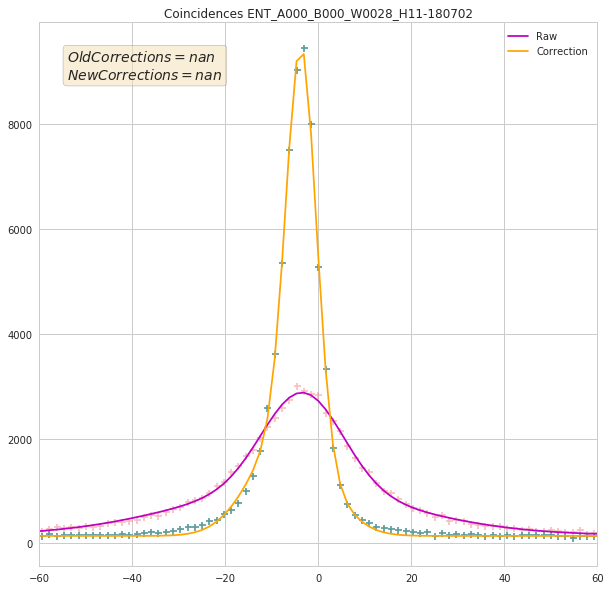

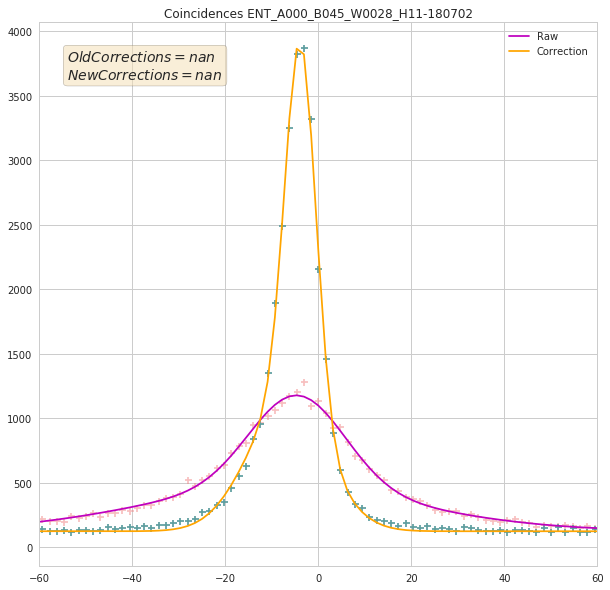

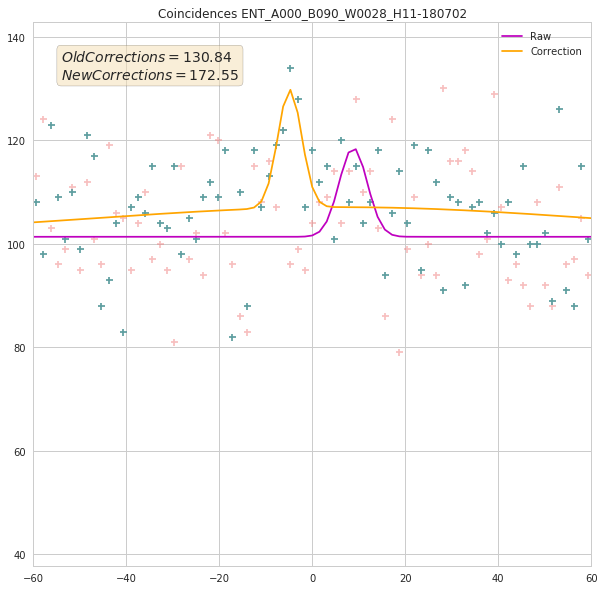

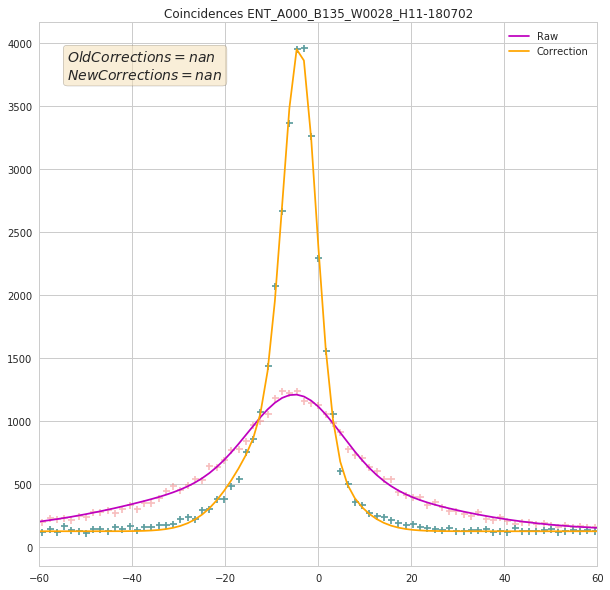

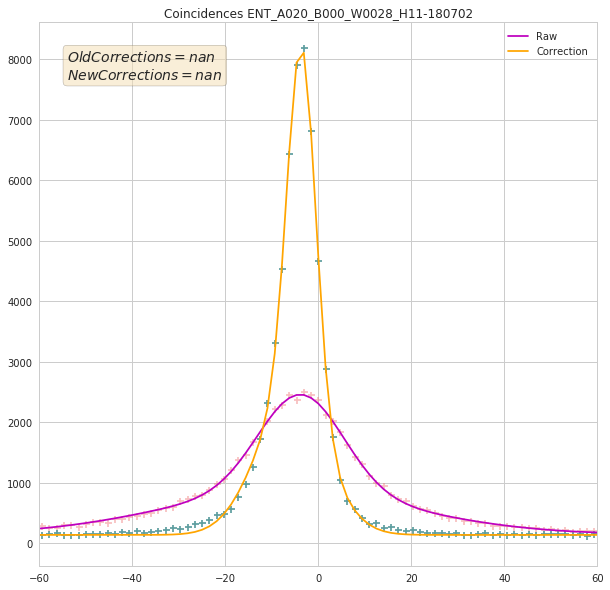

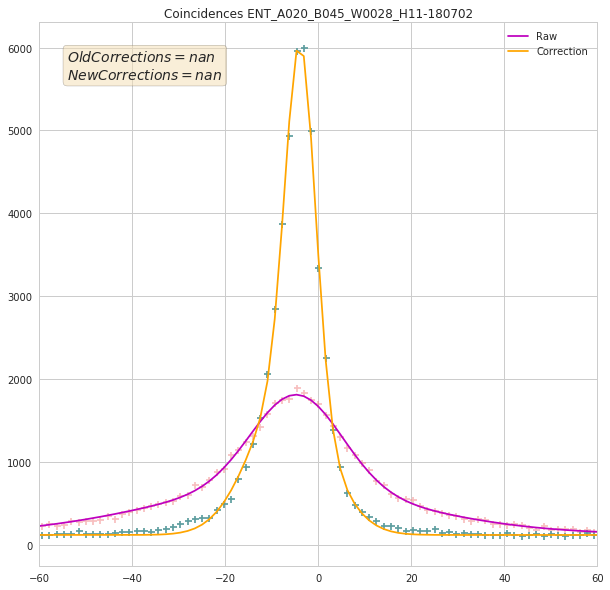

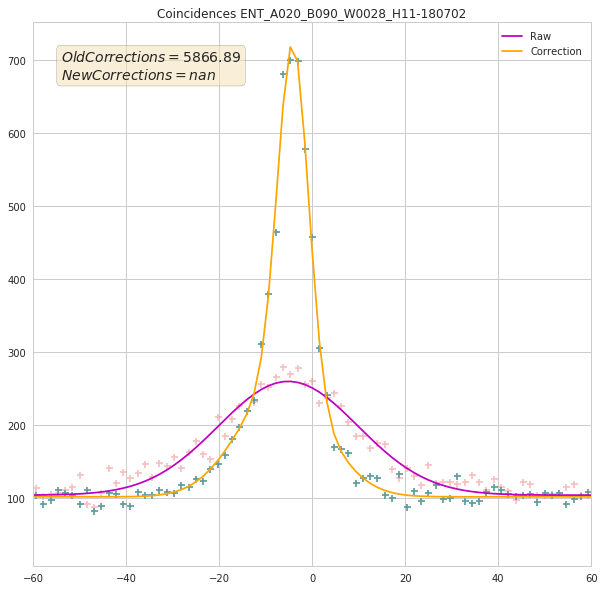

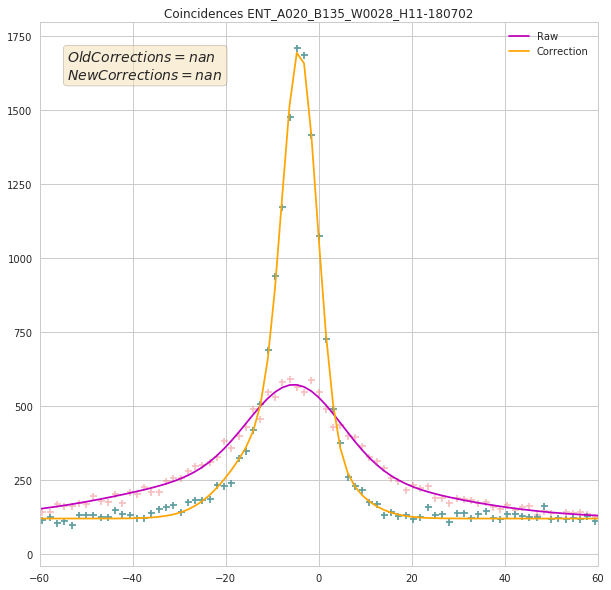

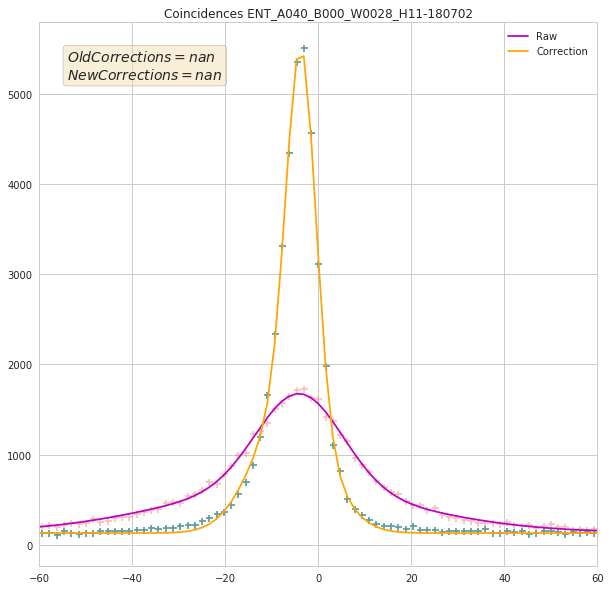

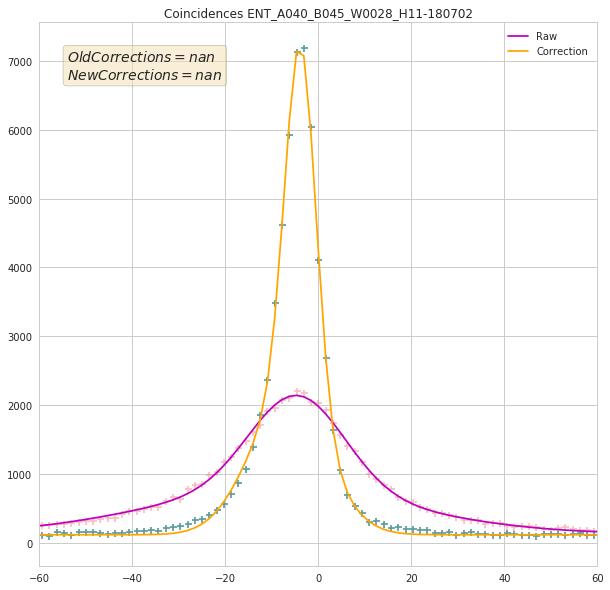

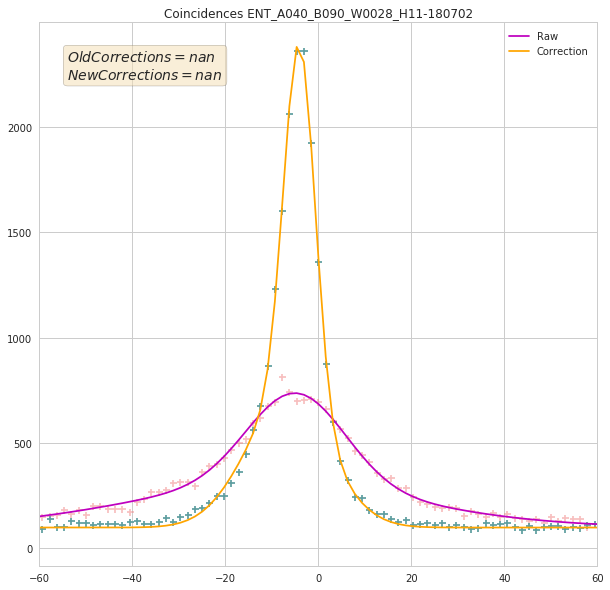

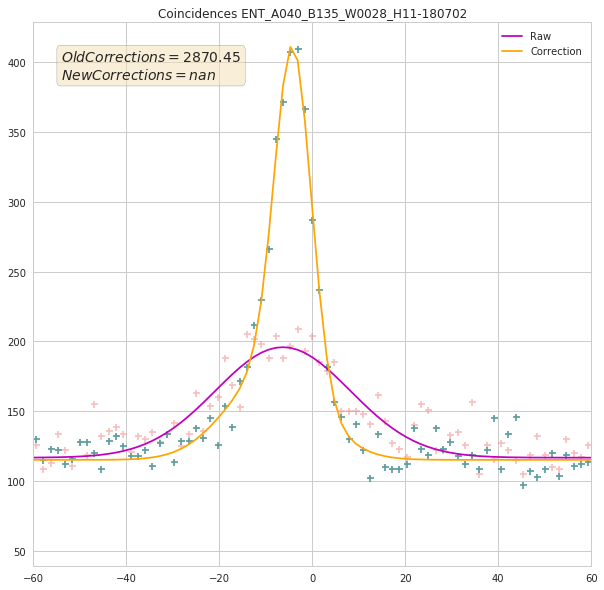

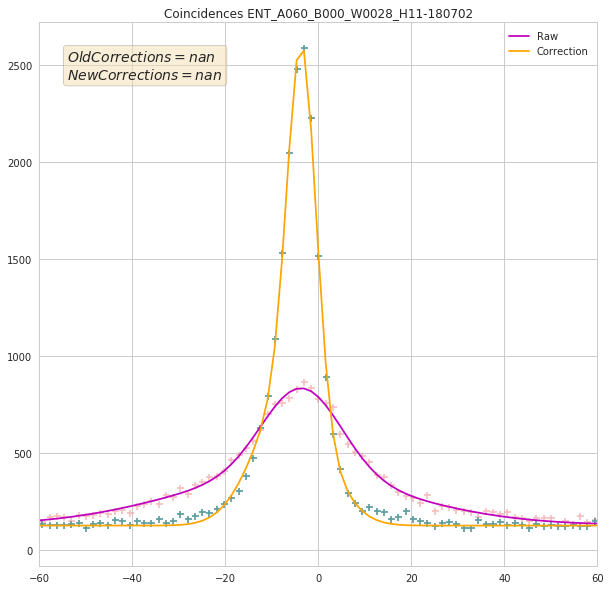

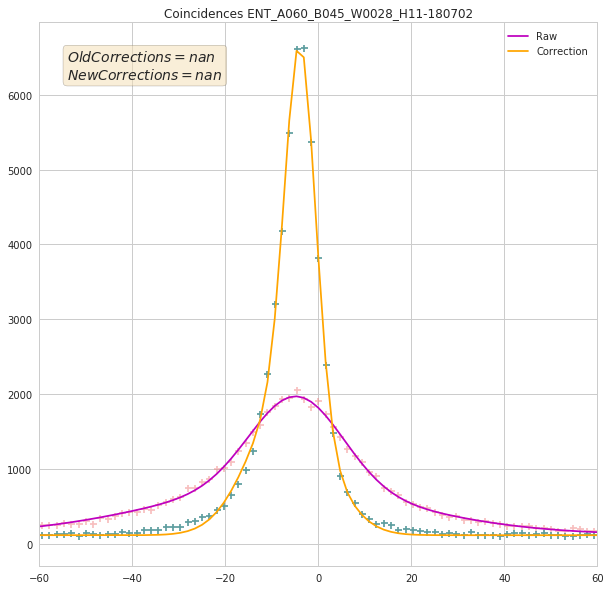

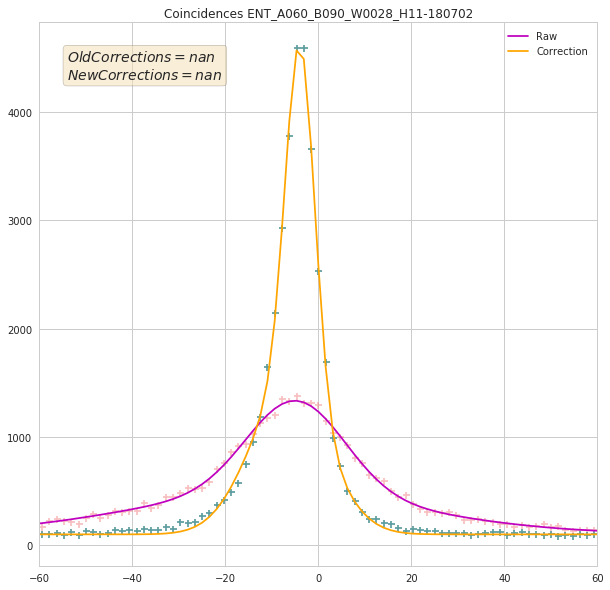

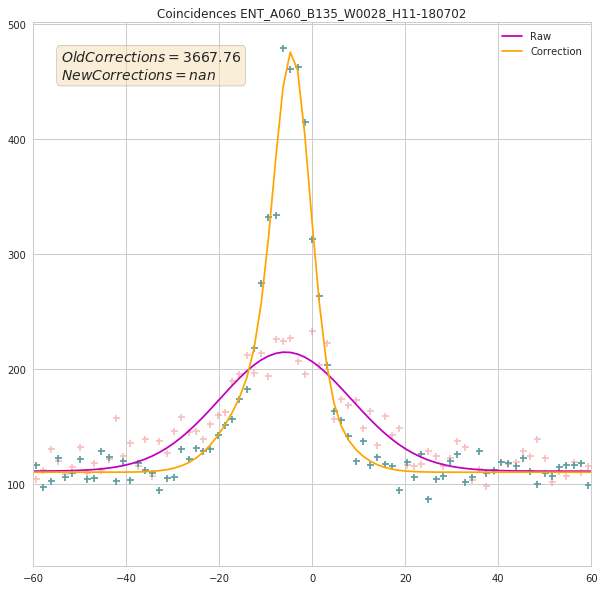

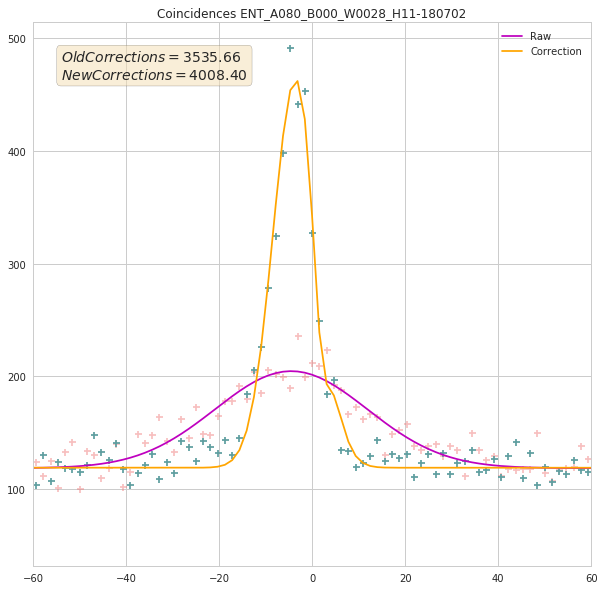

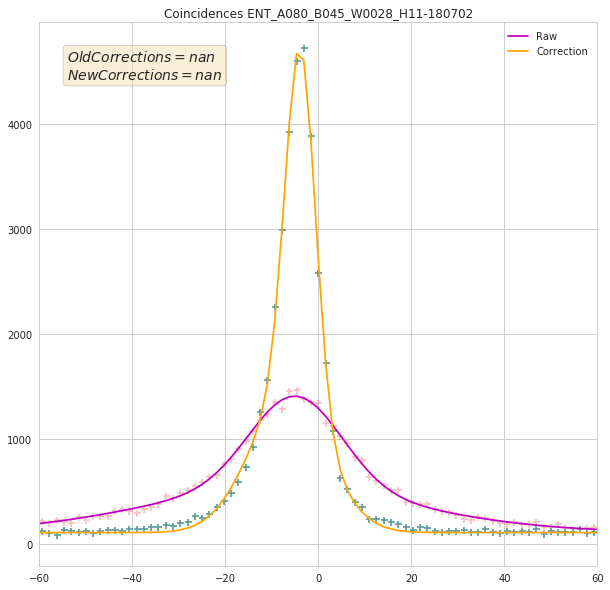

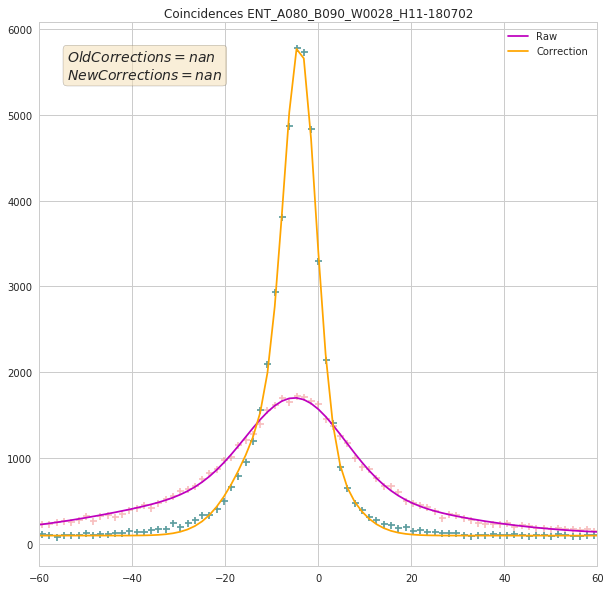

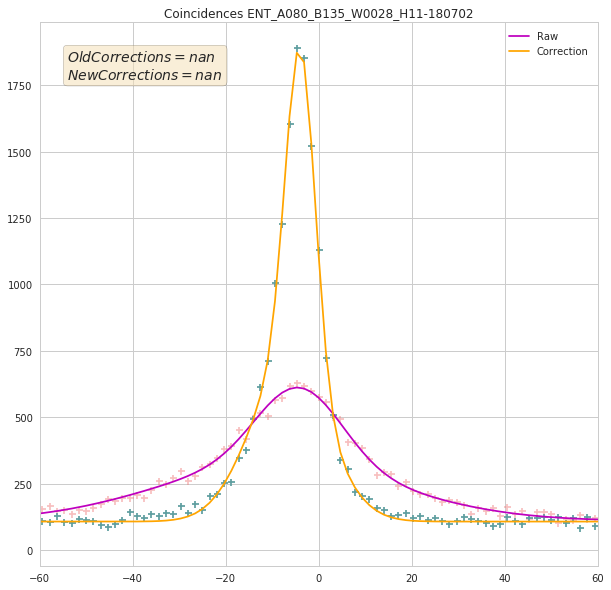

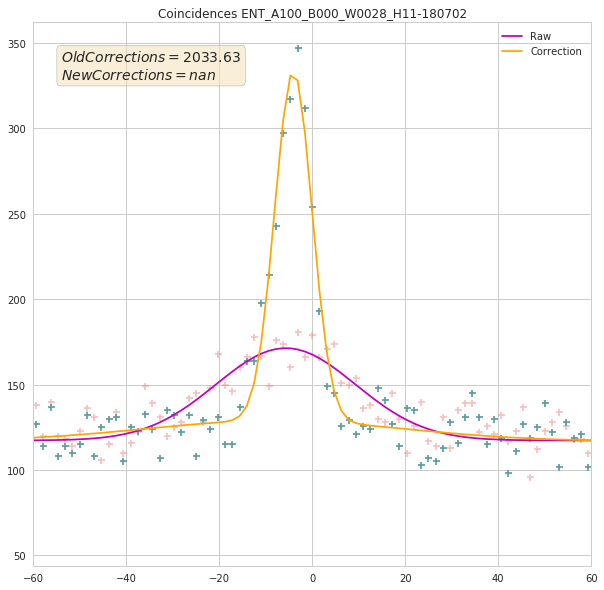

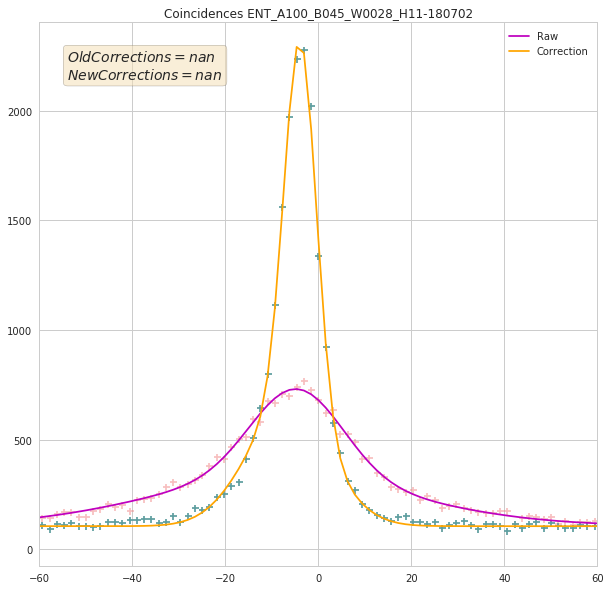

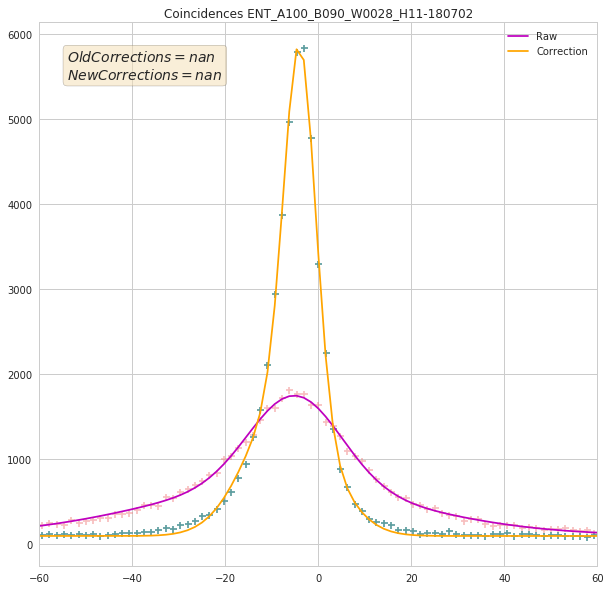

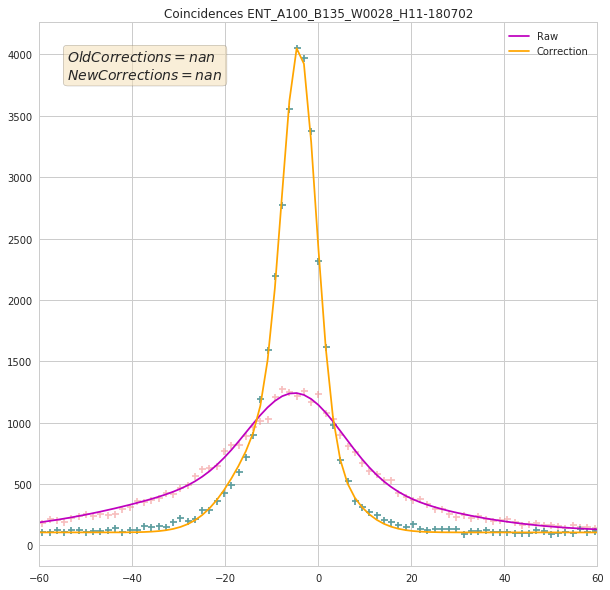

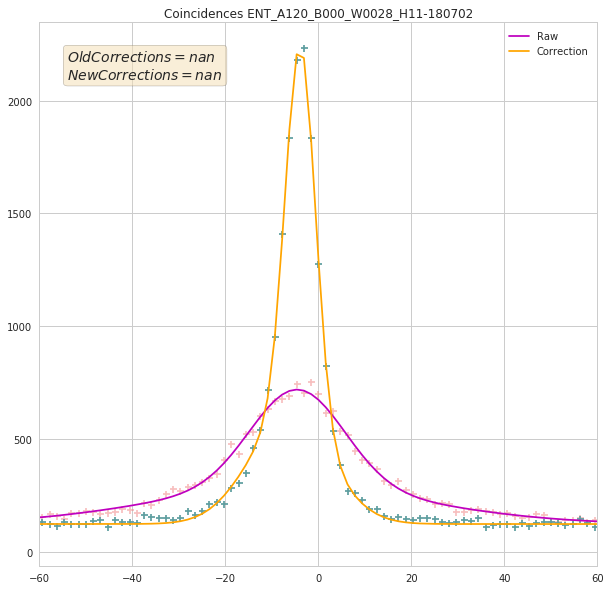

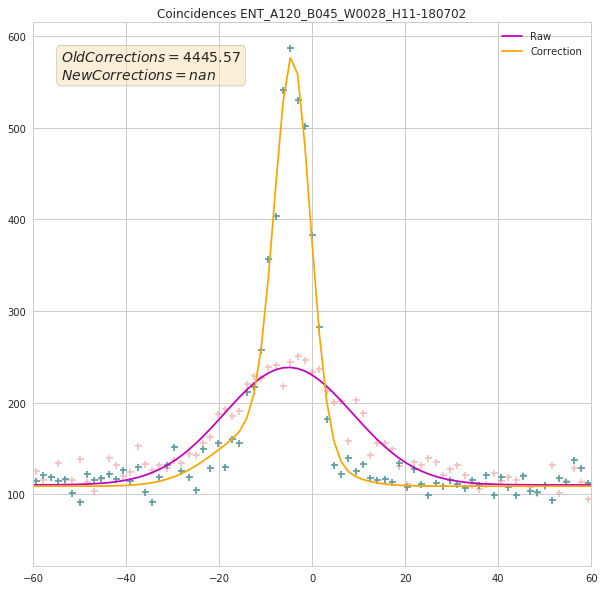

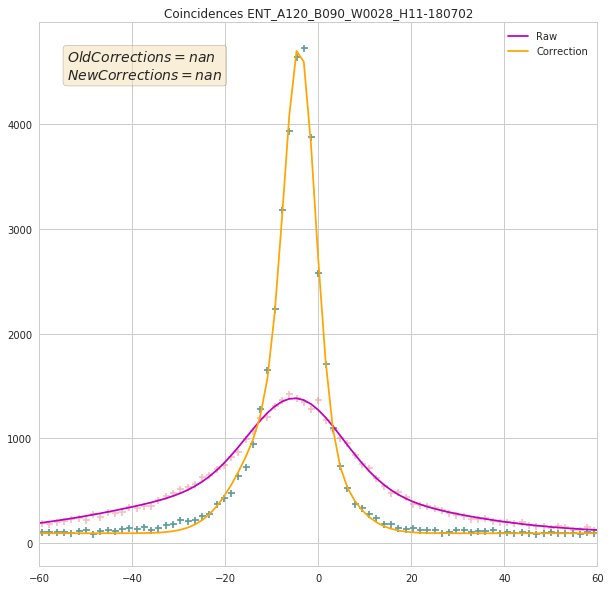

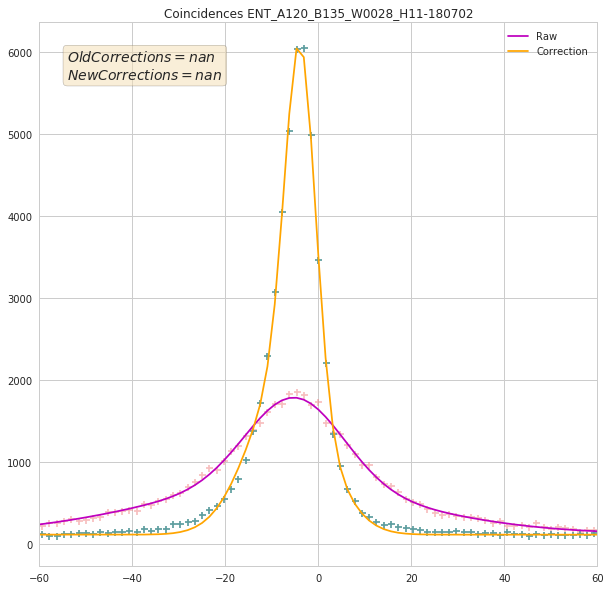

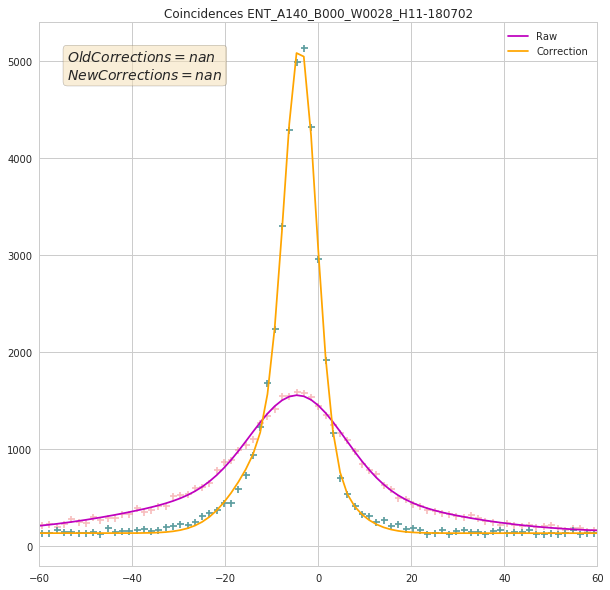

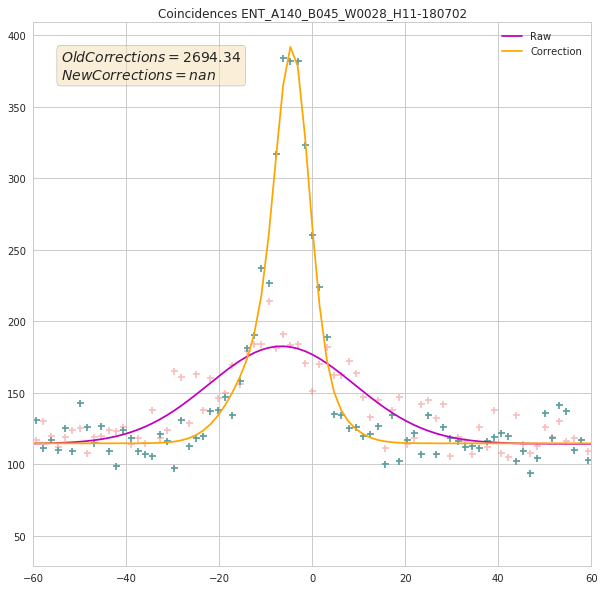

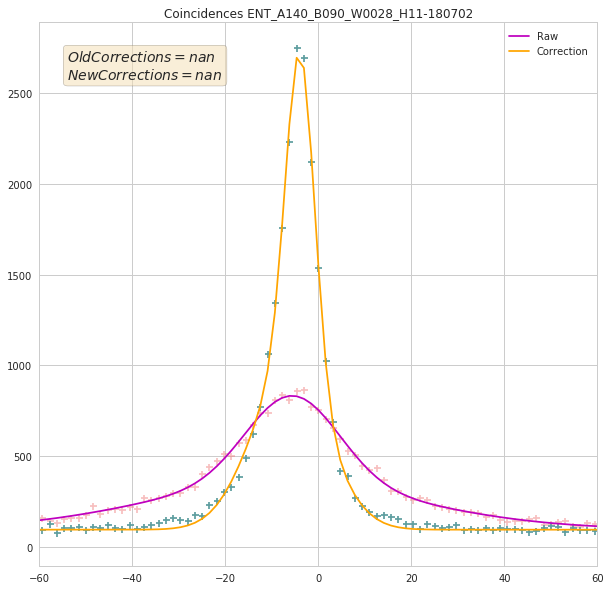

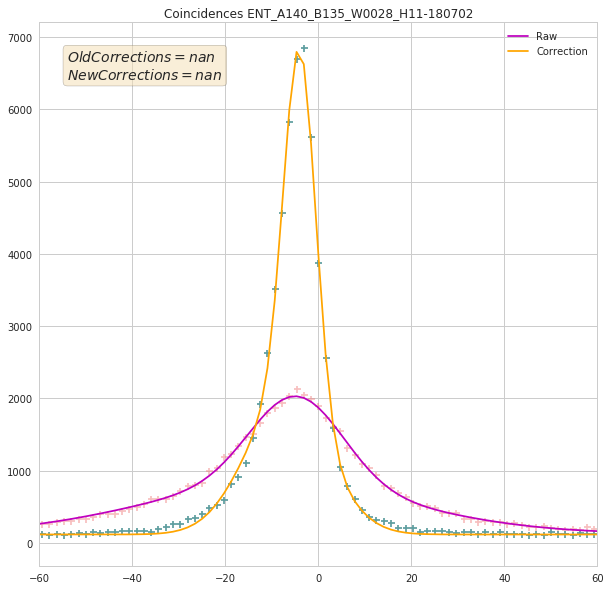

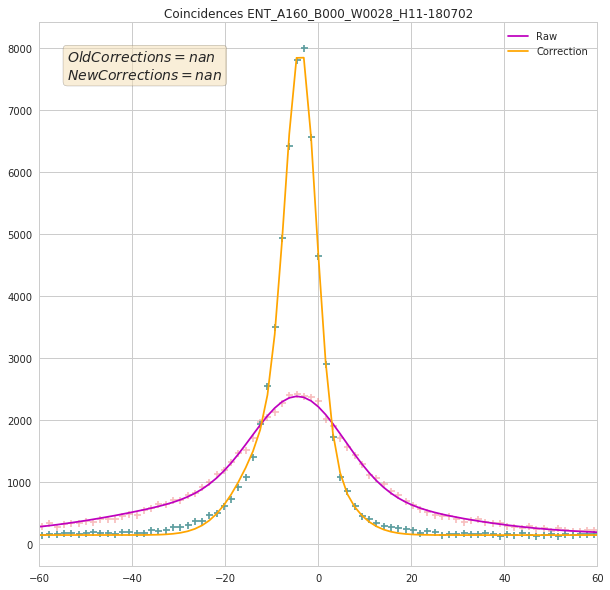

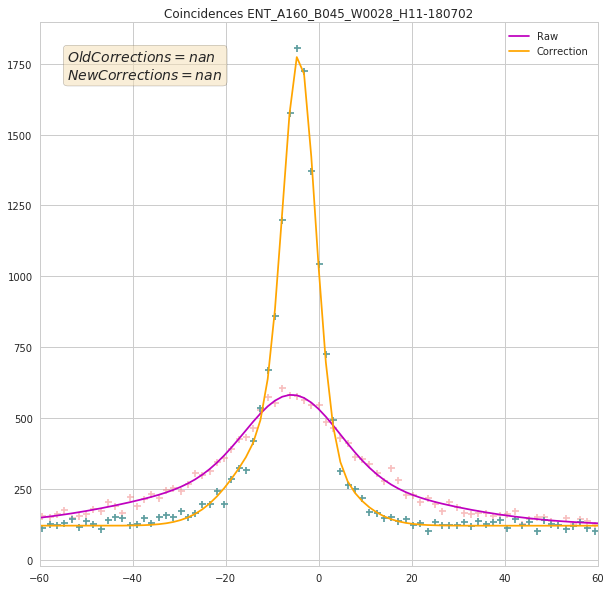

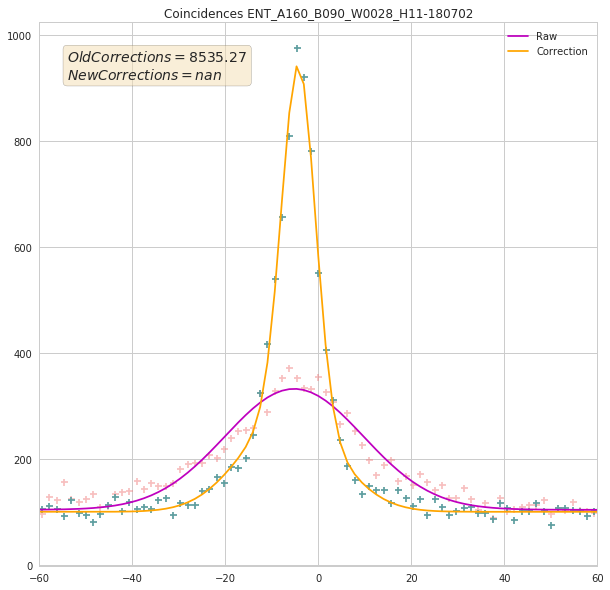

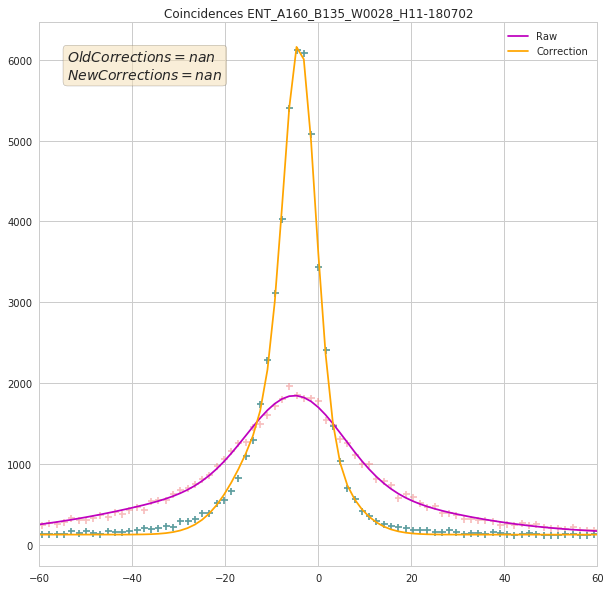

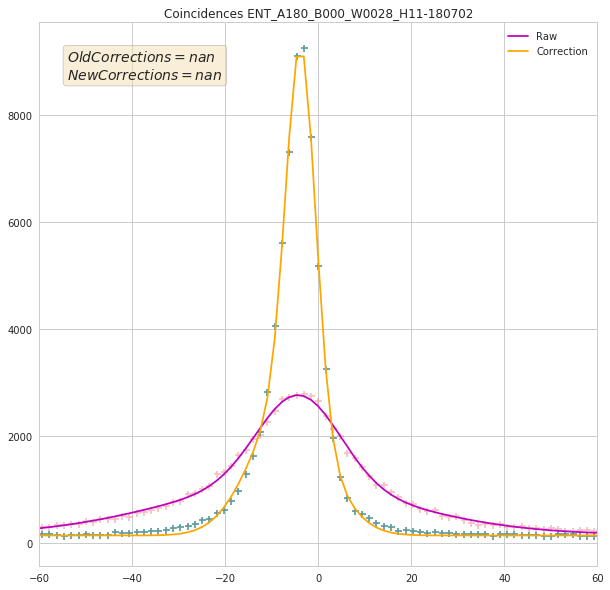

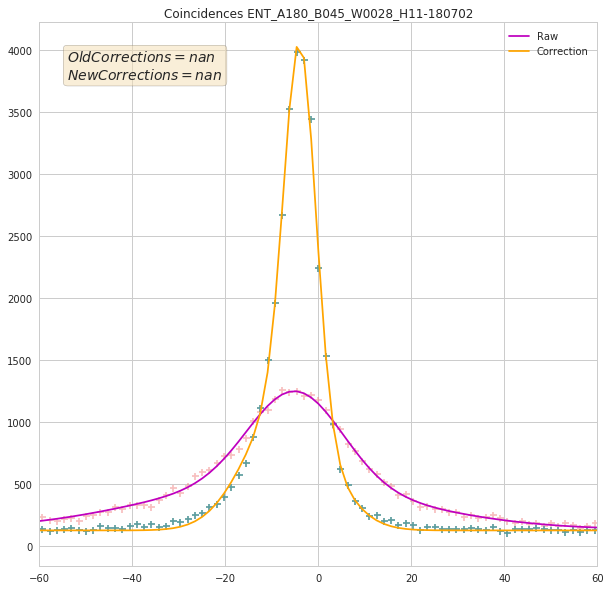

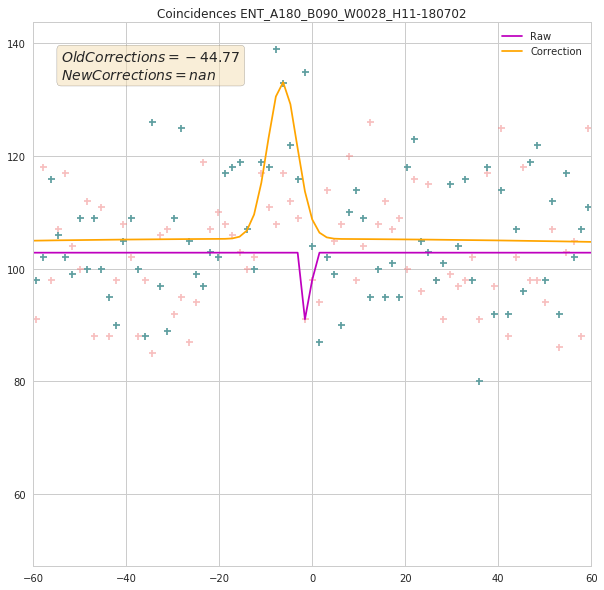

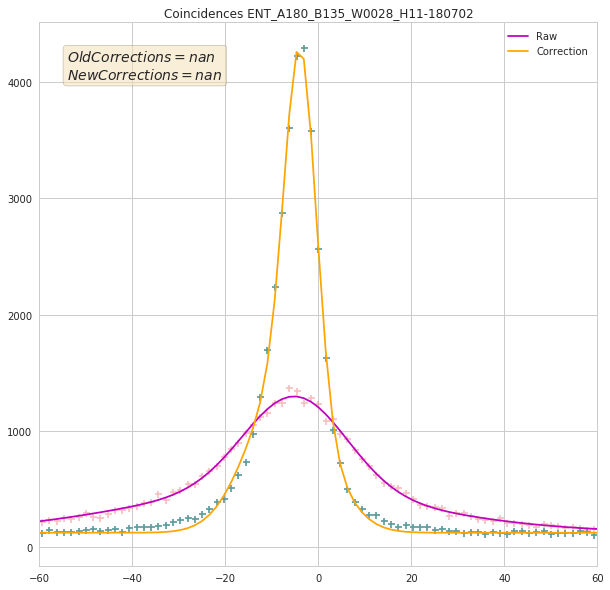

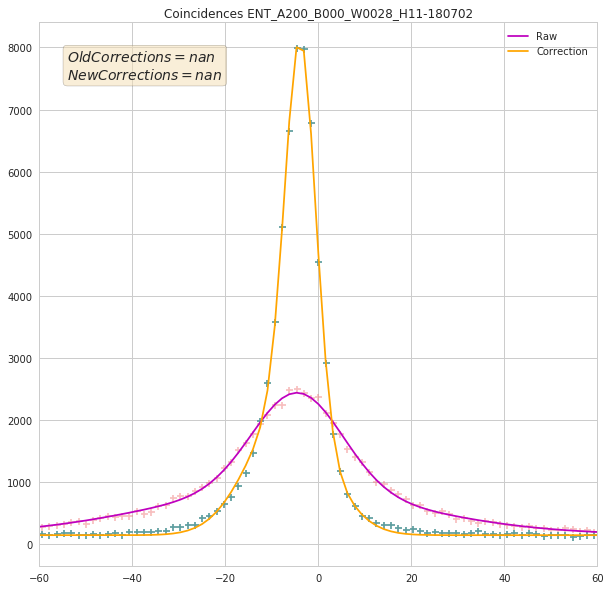

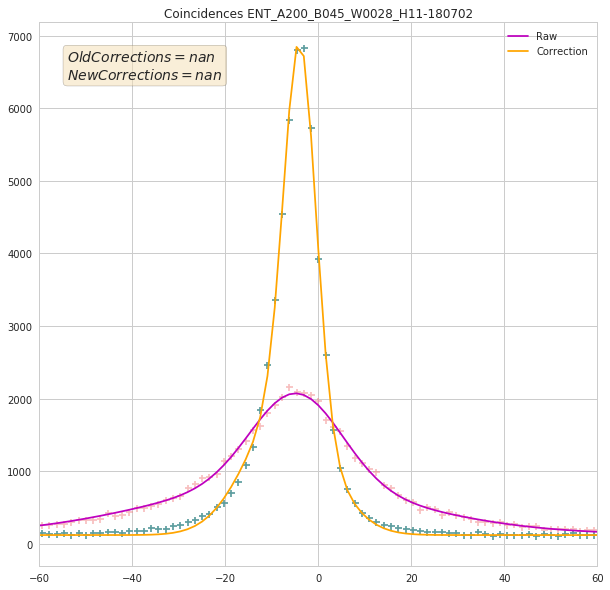

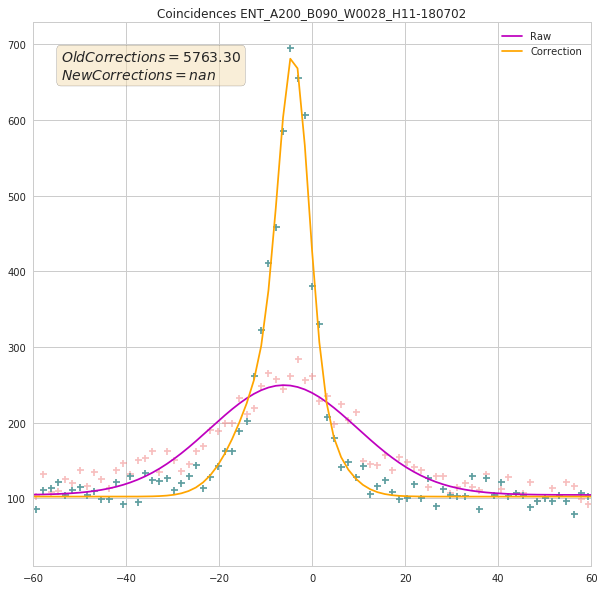

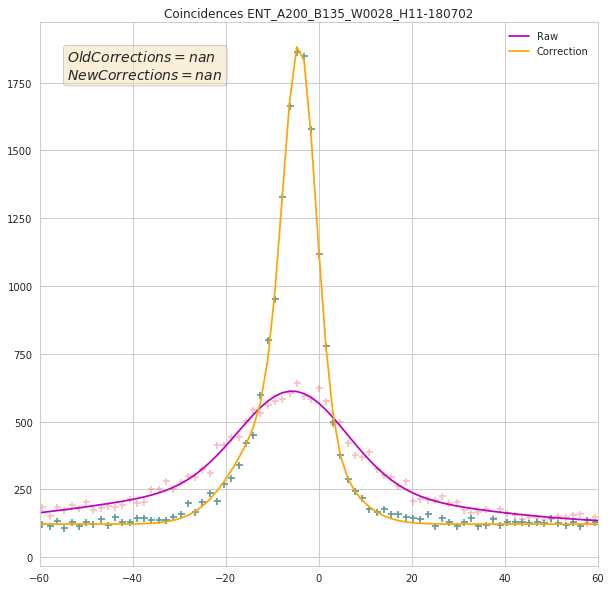

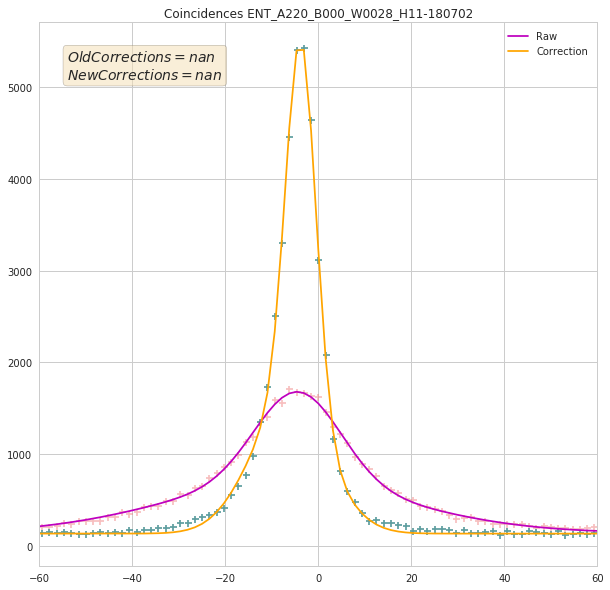

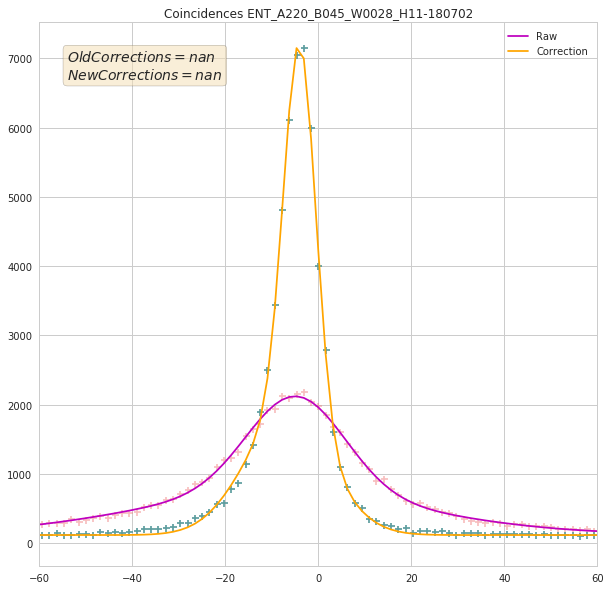

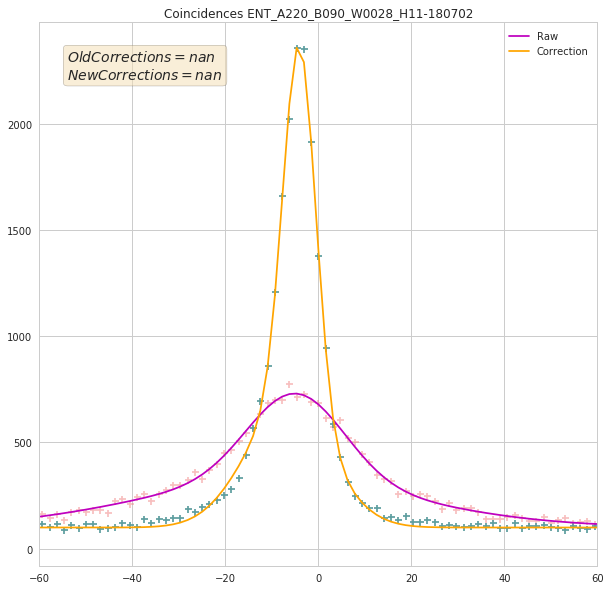

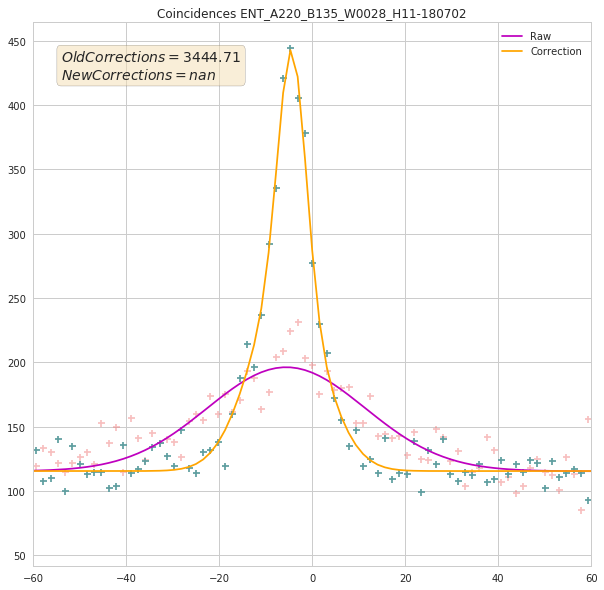

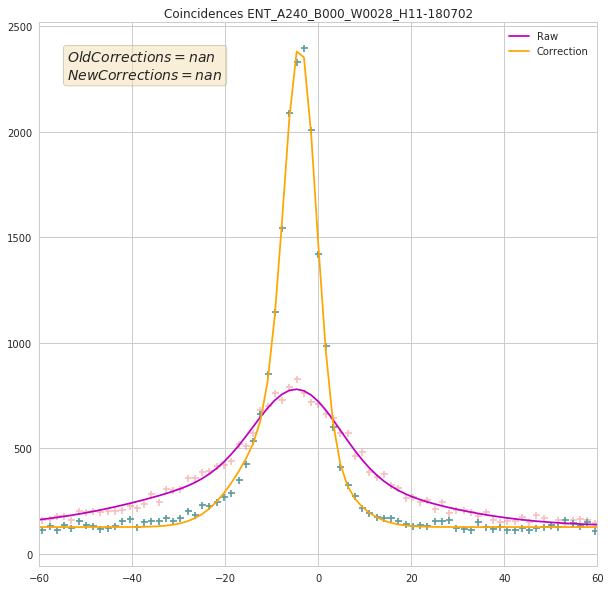

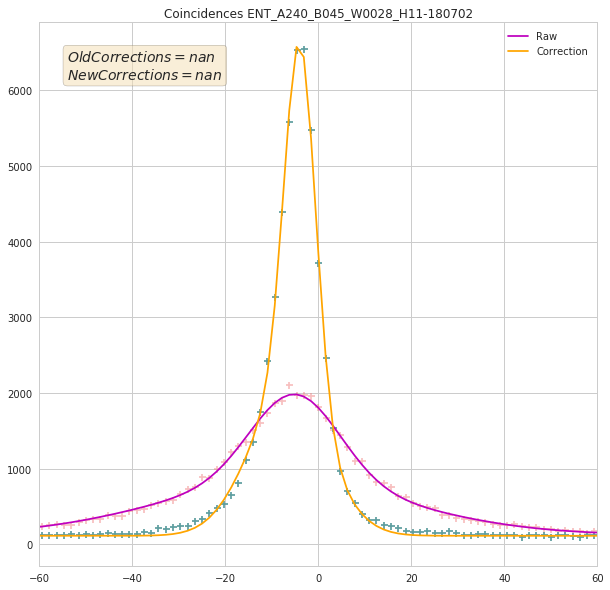

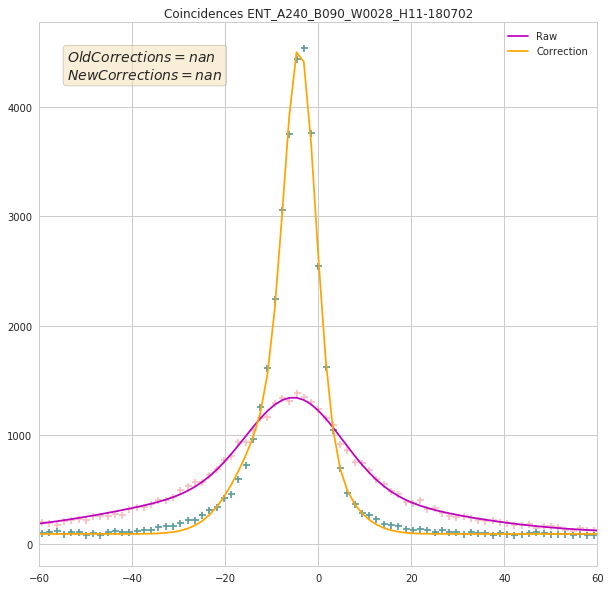

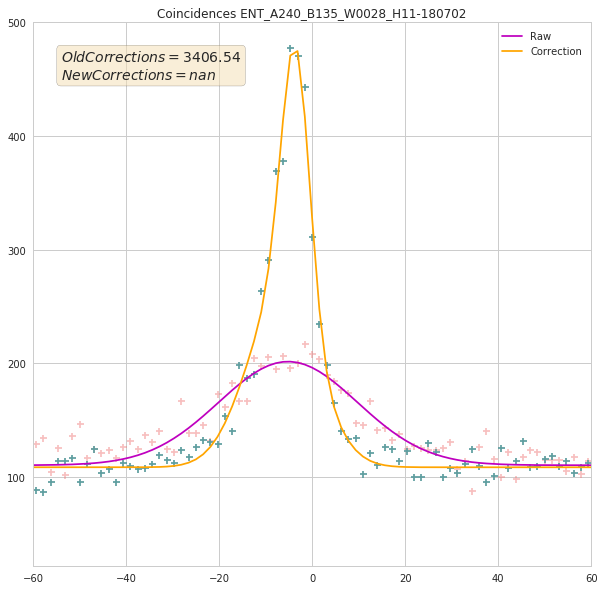

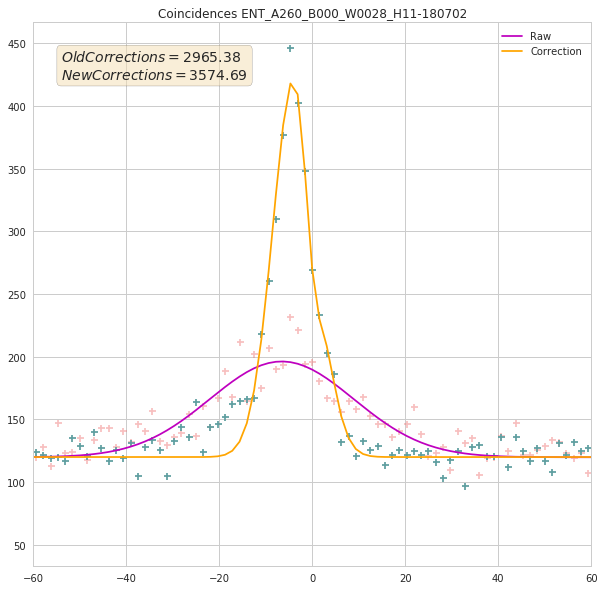

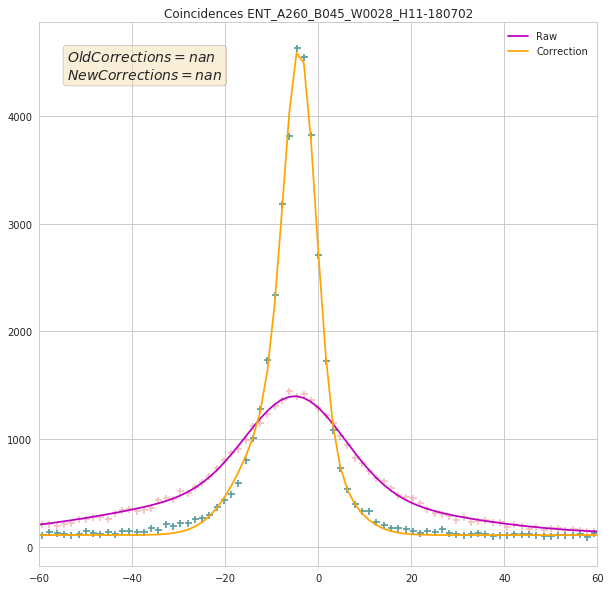

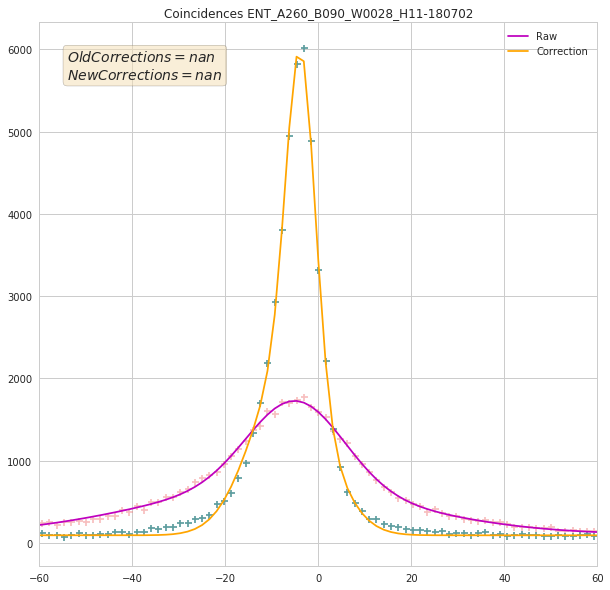

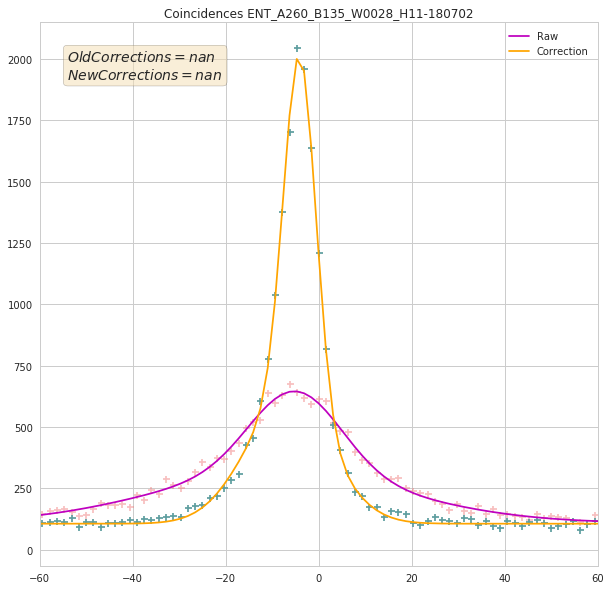

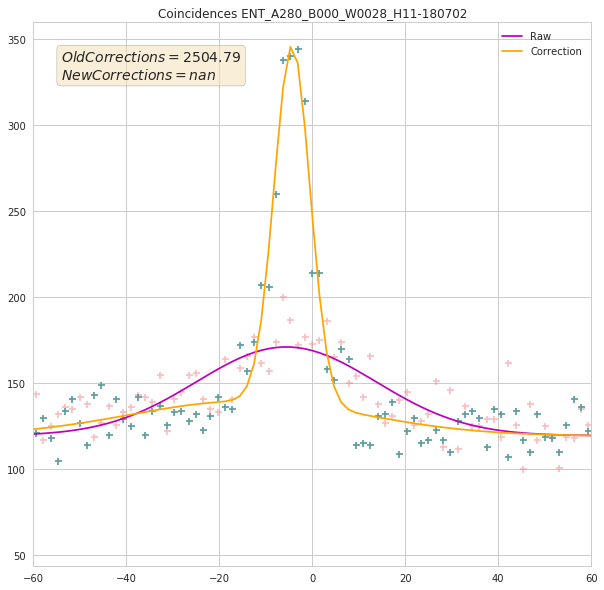

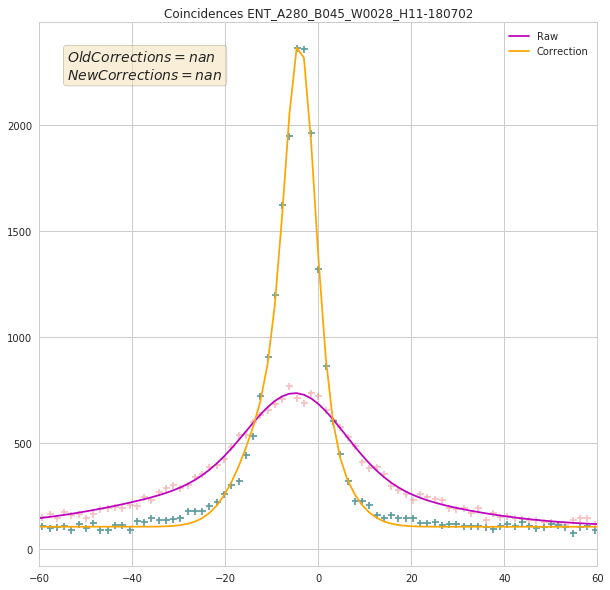

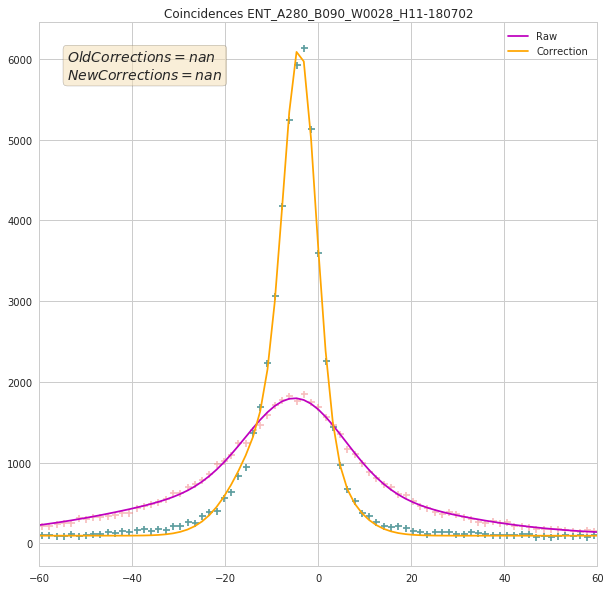

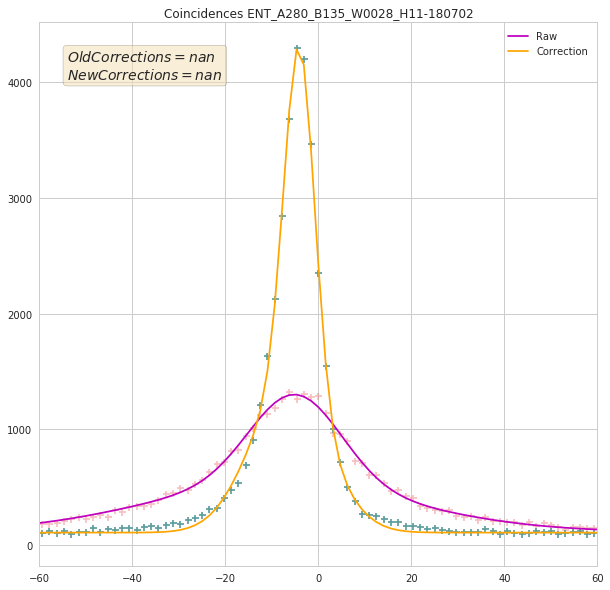

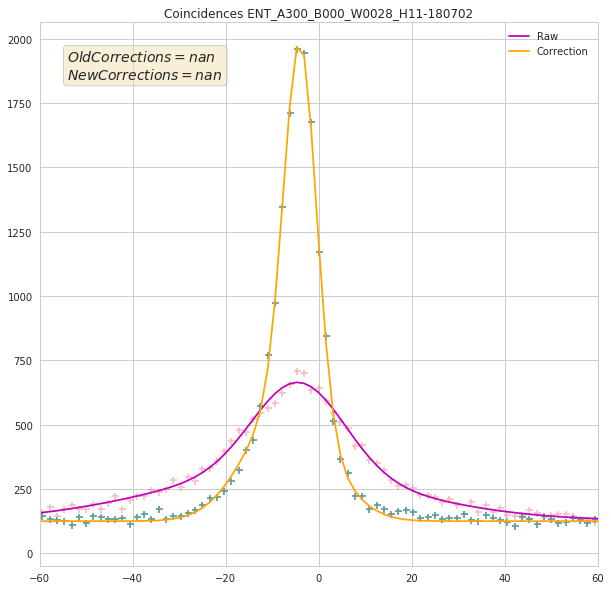

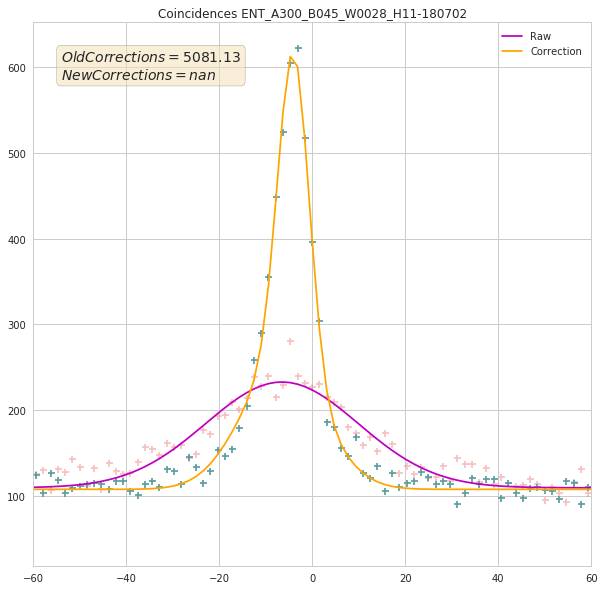

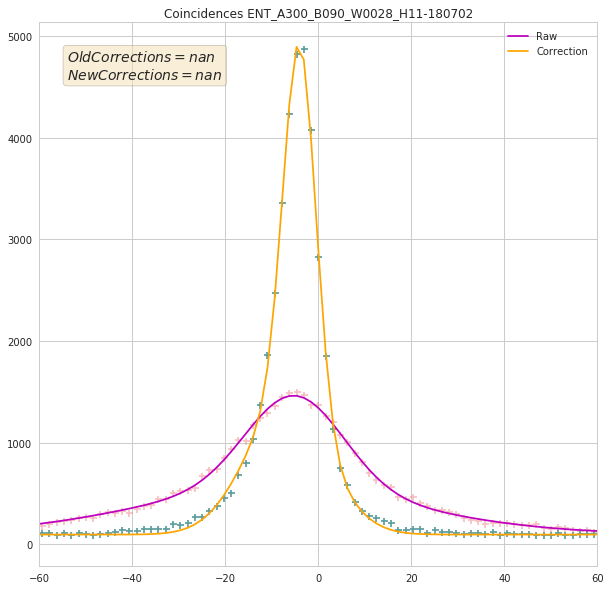

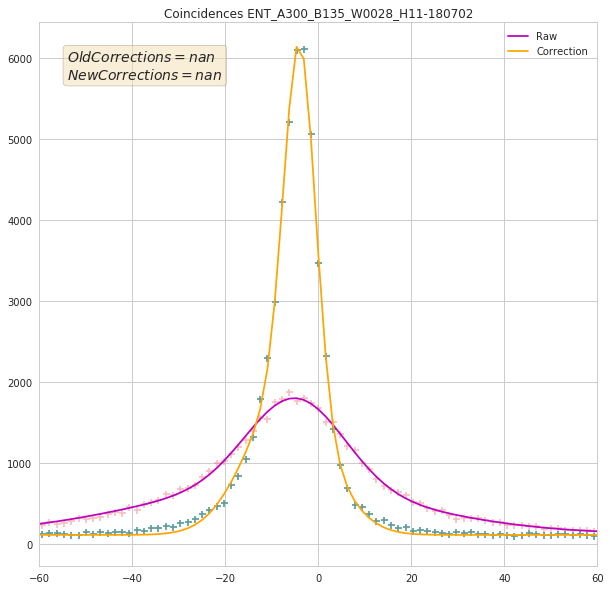

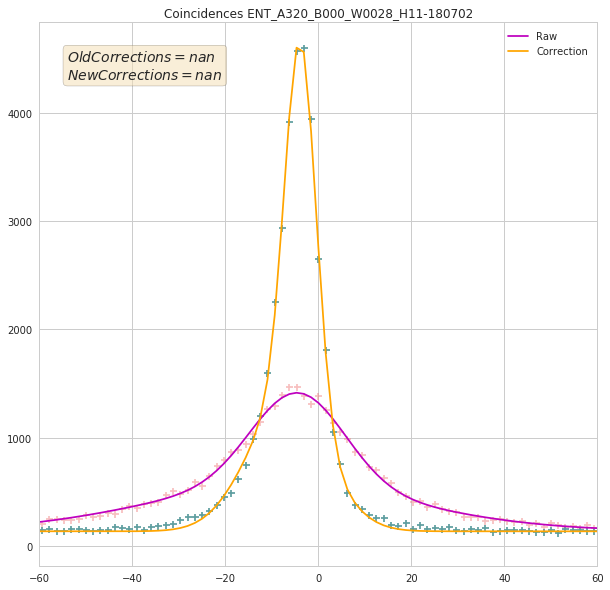

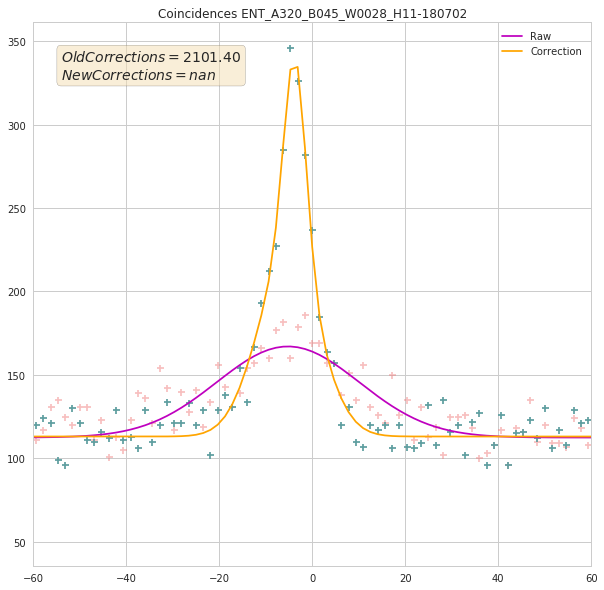

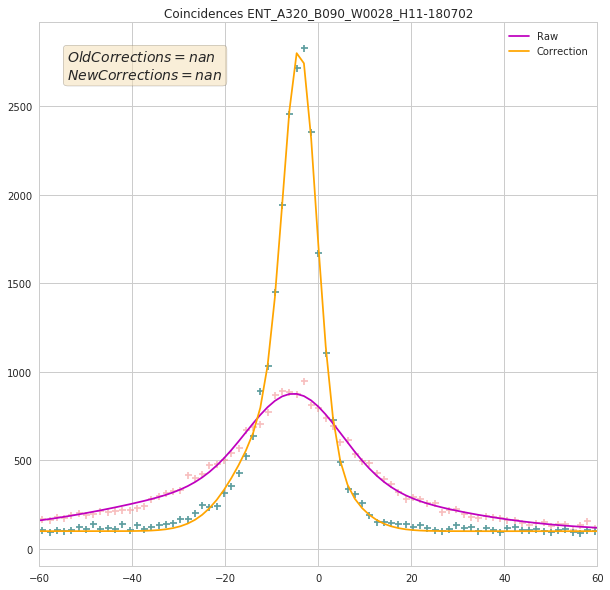

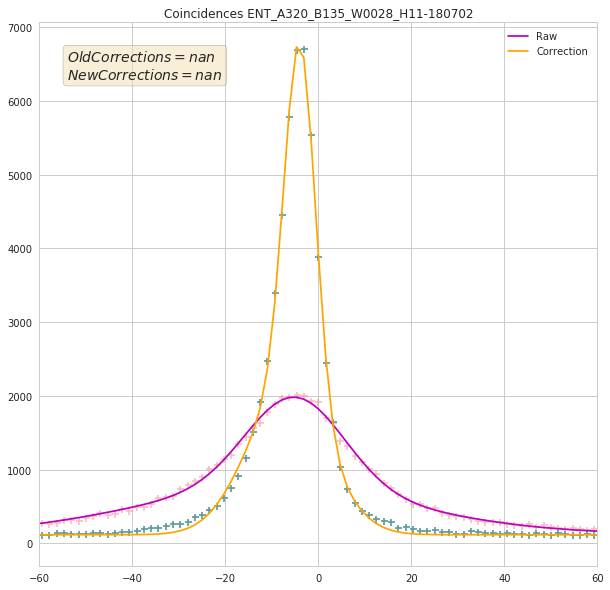

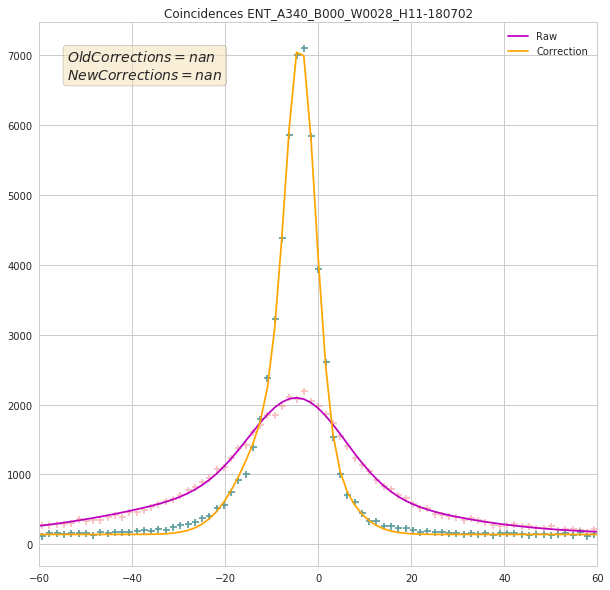

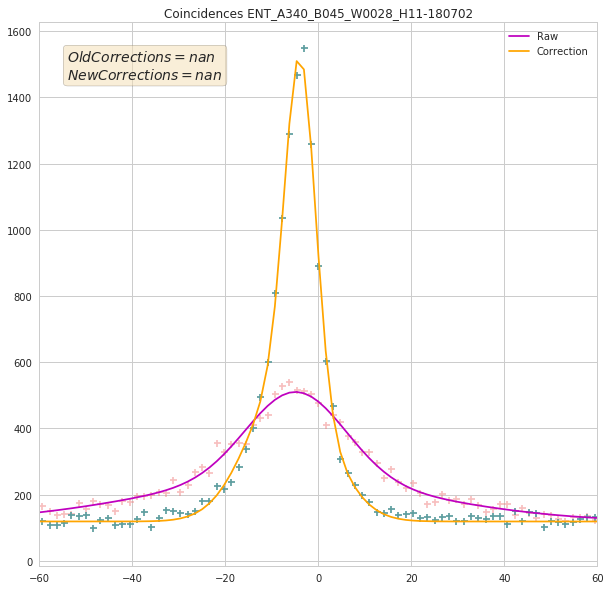

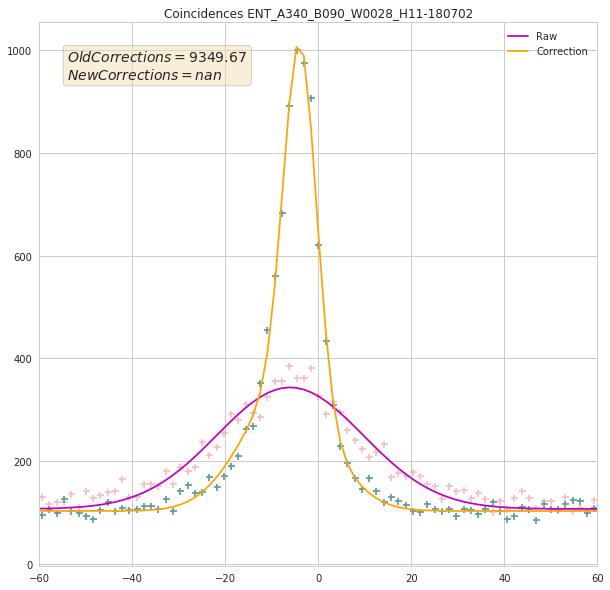

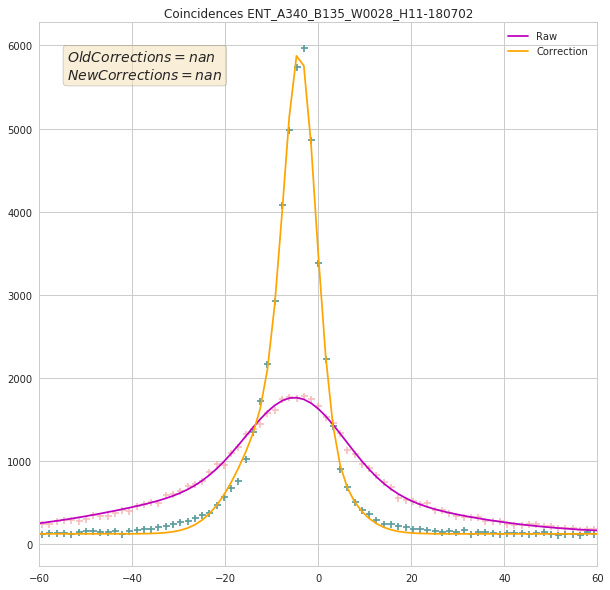

In [21]:
param = (2800,0,30,2800,0,40,300)

#for i in range(16):
for i in range(len(delta)):
    if len(param) < 5:
        param = (900,0,40,500,0,60,200)
    param = CorrectionCheck(delta[i], coi[i], correct_delt[i], correct_coi[i],pol[i], param)


In [22]:
totalcts= np.empty(len(delta))
first = np.empty(len(delta))
second = np.empty(len(delta))
#print(coi[0])
for i in range(len(delta)):
    totalcts[i],first[i],second[i] = CoincidenceCount(correct_delt[i],correct_coi[i],correct_fiber[i],pol[i])
np.savetxt('corrsum.csv',totalcts)
for i in range(len(delta)):
    totalcts[i],first[i],second[i] = CoincidenceCount(delta[i],coi[i],fiber[i],pol[i])
np.savetxt('rawsum.csv',totalcts)

65948.06617647057 120717.0 136.5808823529412 401
29746.632352941182 78132.0 120.66176470588235 401
528.8897058823495 41310.0 101.69852941176471 401
31722.198529411762 79739.0 119.74264705882354 401
58240.01102941176 111545.0 132.93014705882354 401
46630.28676470588 93621.0 117.18382352941177 401
4677.0477941176505 45725.0 102.36397058823529 401
13283.23529411765 61073.0 119.17647058823529 401
39523.66176470588 90775.0 127.80882352941177 401
56074.89705882353 100981.0 111.98529411764706 401
18922.716911764706 57603.0 96.4595588235294 401
2949.617647058818 48699.0 114.08823529411765 401
18207.54044117647 67361.0 122.57720588235294 401
51425.091911764706 95168.0 109.0845588235294 401
35876.01470588235 72998.0 92.57352941176471 401
3212.705882352937 47134.0 109.52941176470588 401
3080.8713235294126 50191.0 117.48161764705883 401
36244.79044117647 77679.0 103.32720588235294 401
46922.74264705882 82196.0 87.96323529411765 401
14528.316176470587 56766.0 105.33088235294117 401
1878.41544117646

In [82]:
print(len(pol))
print(len(correct_delt))

76
76


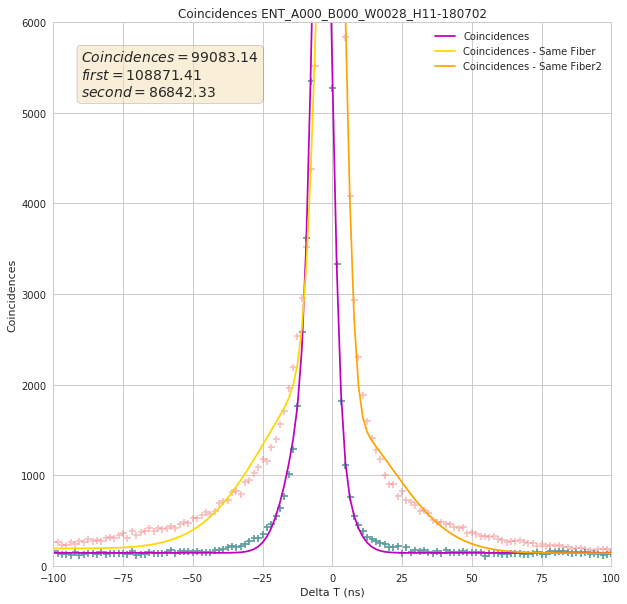

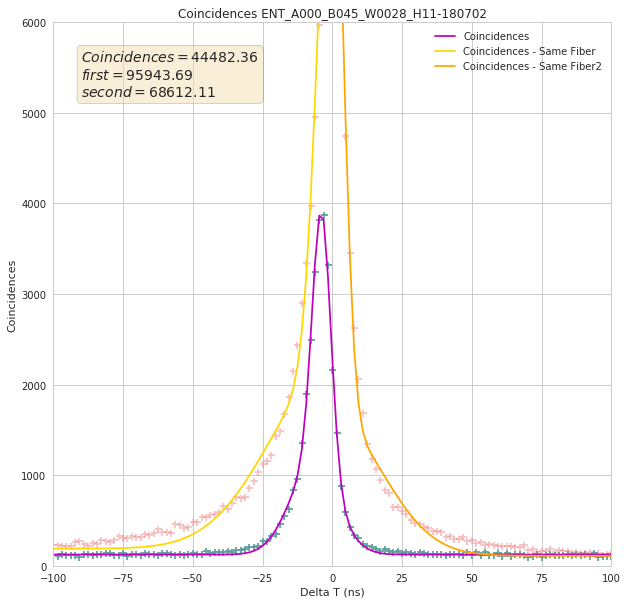

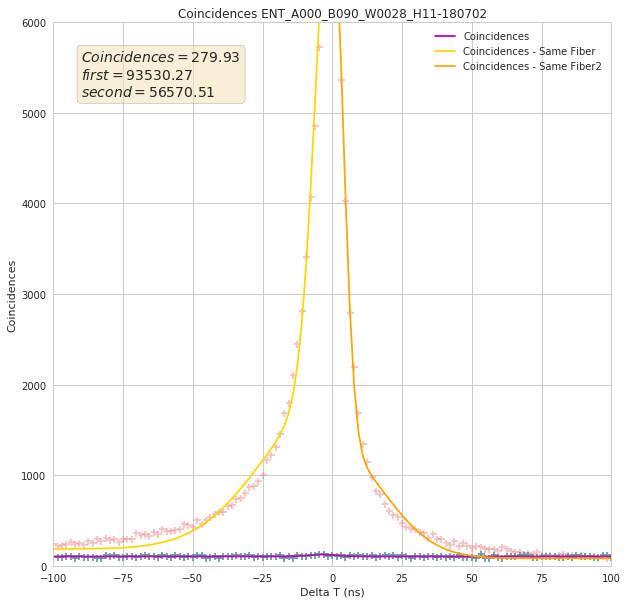

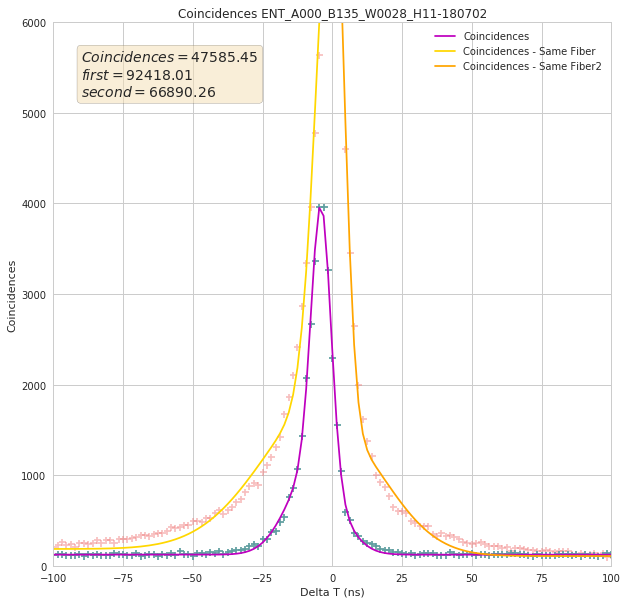

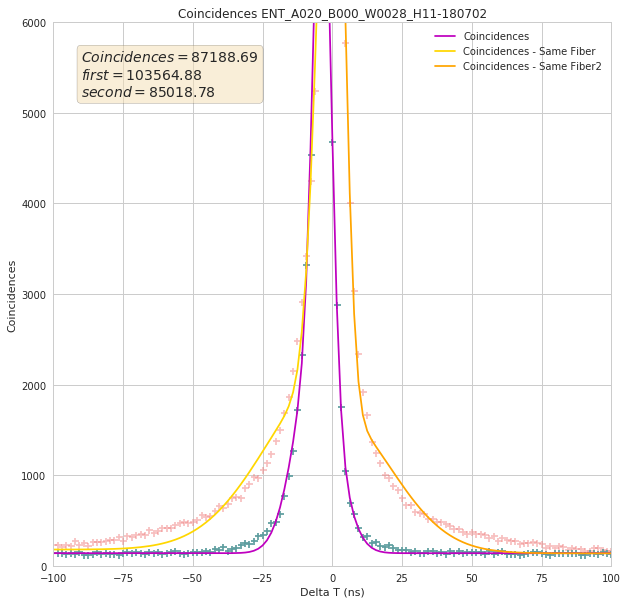

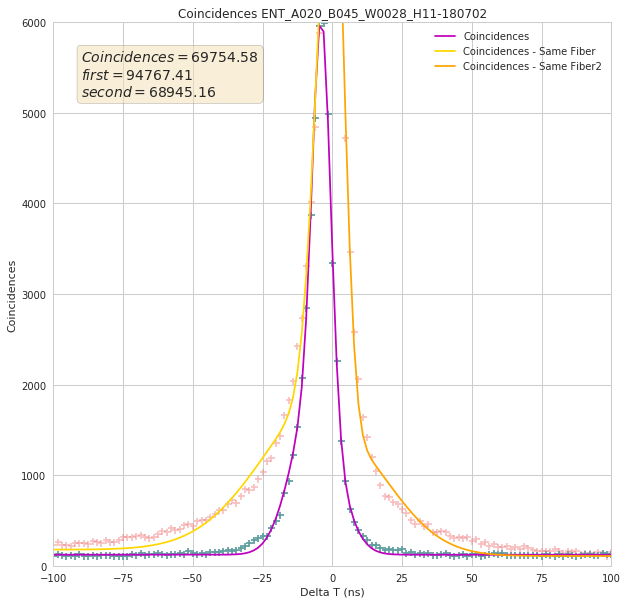

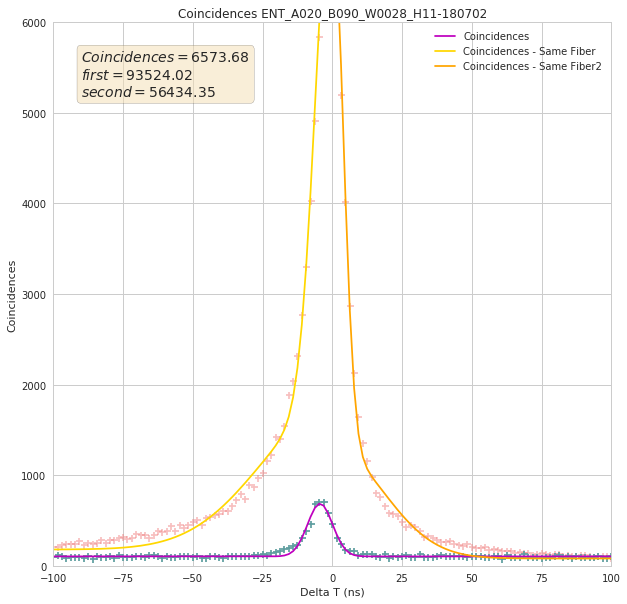

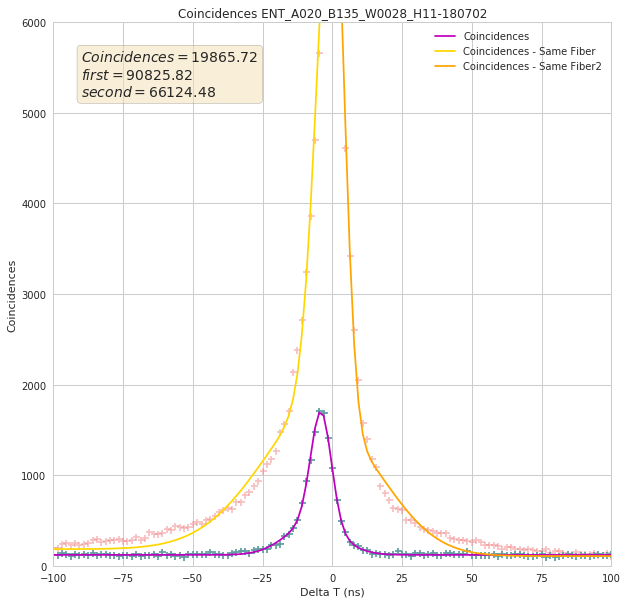

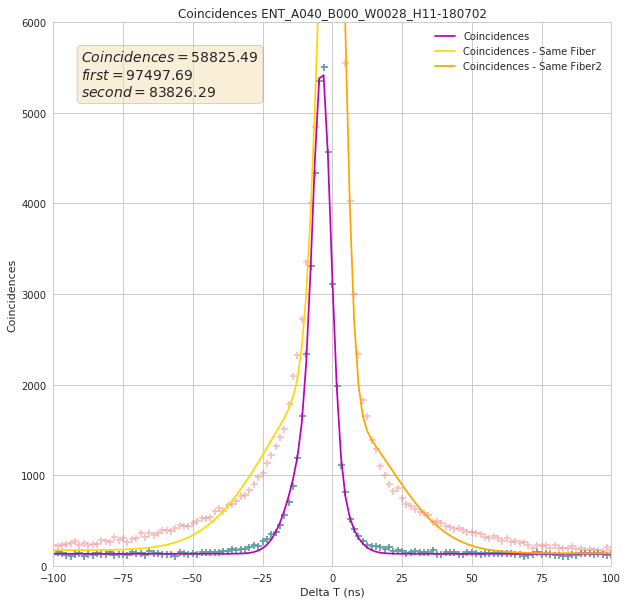

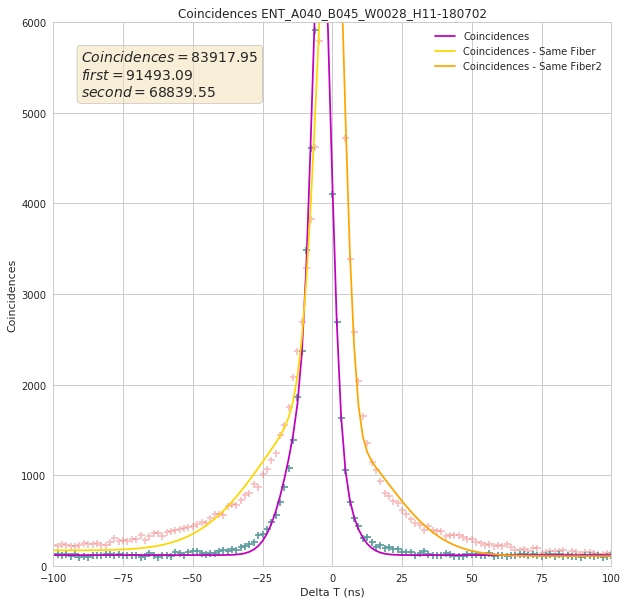

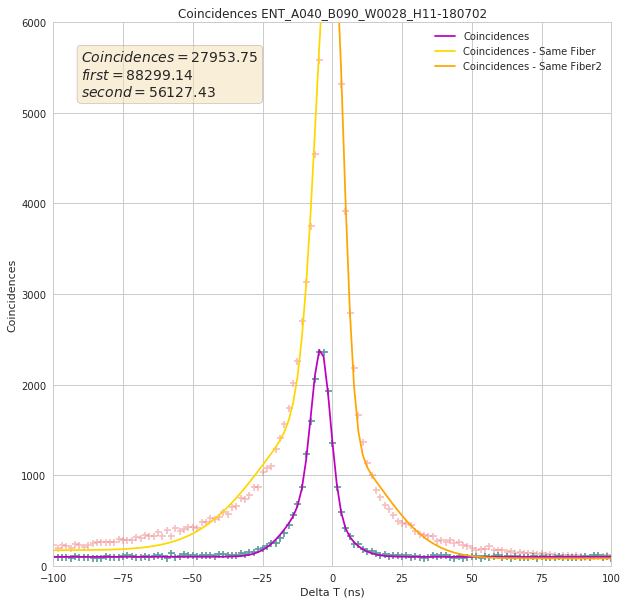

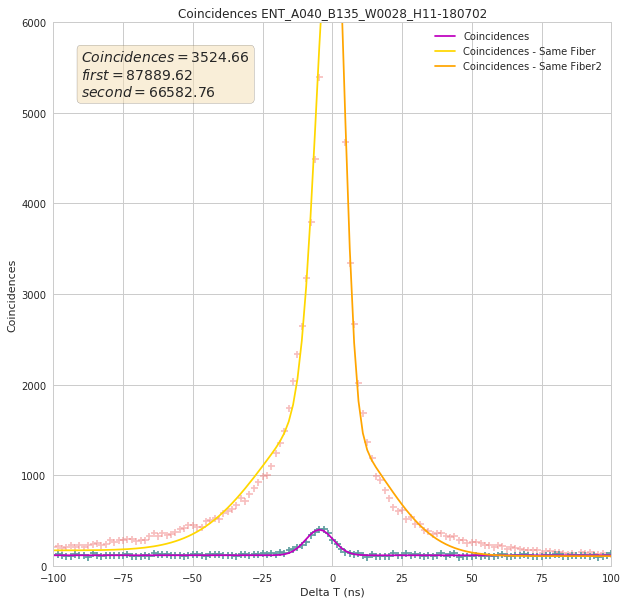

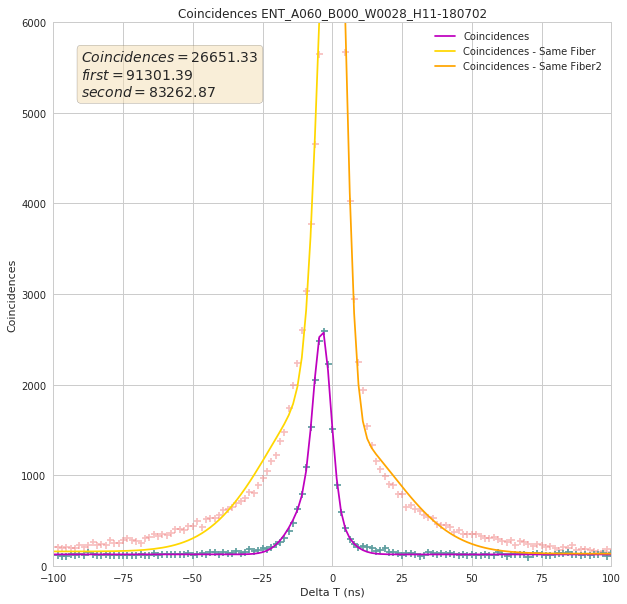

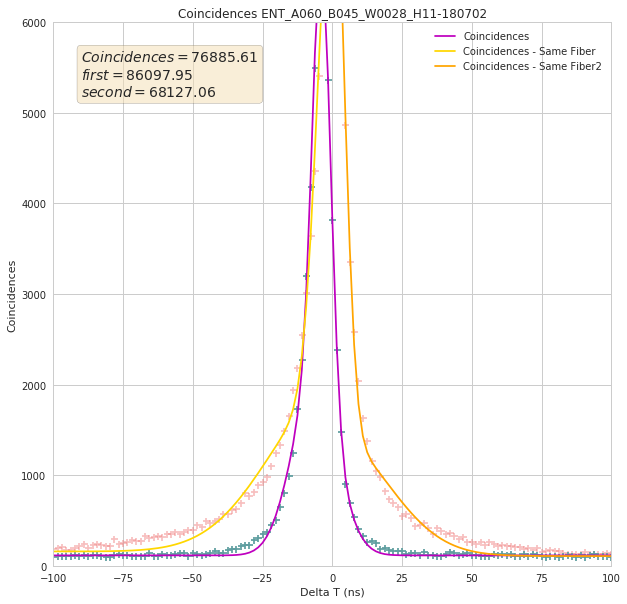

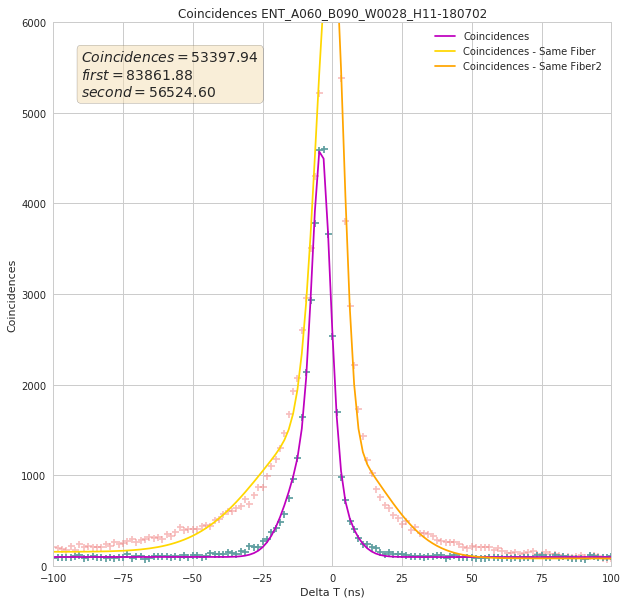

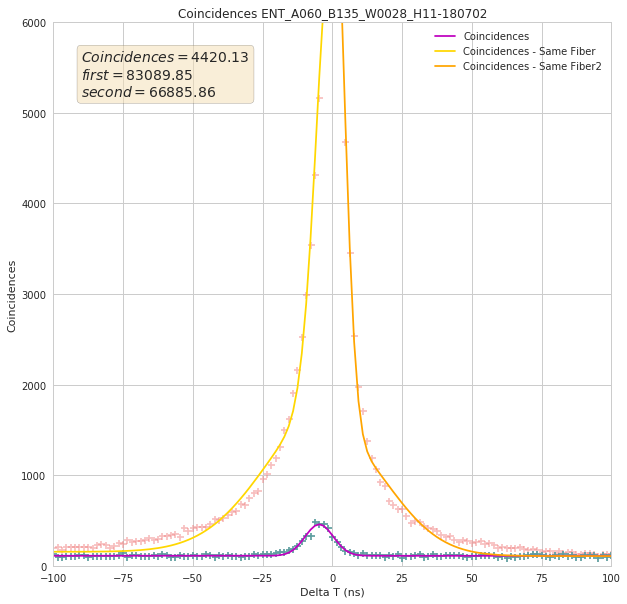

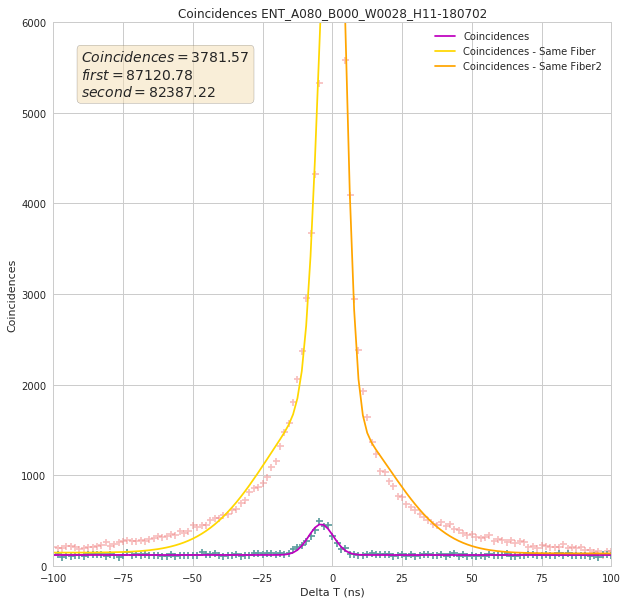

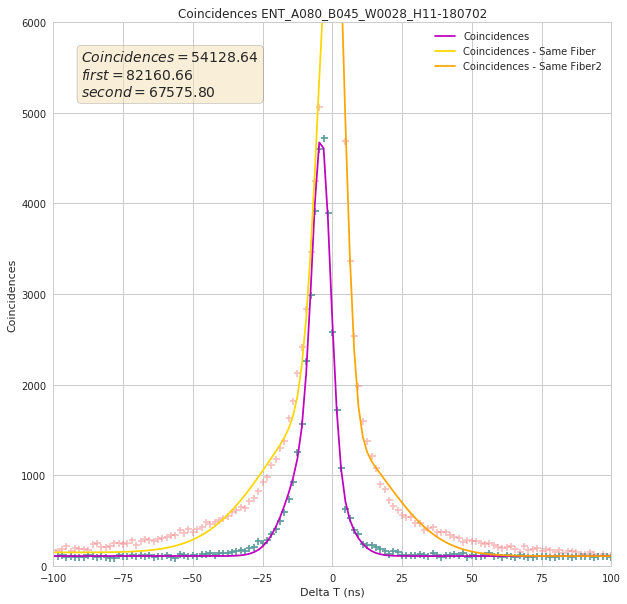

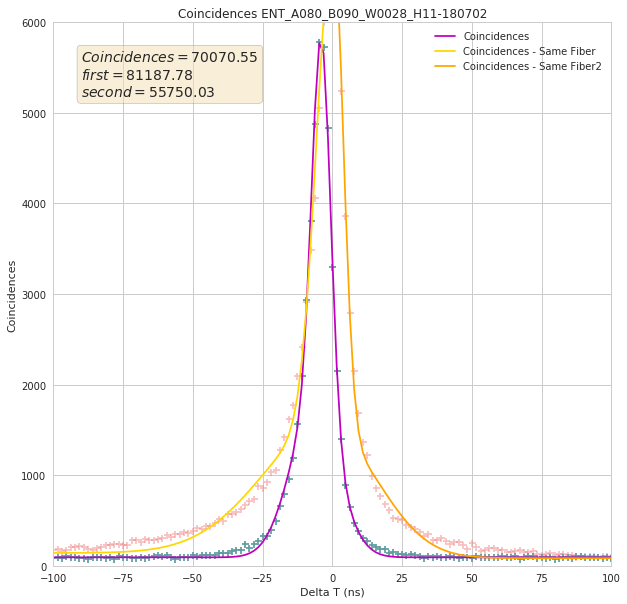

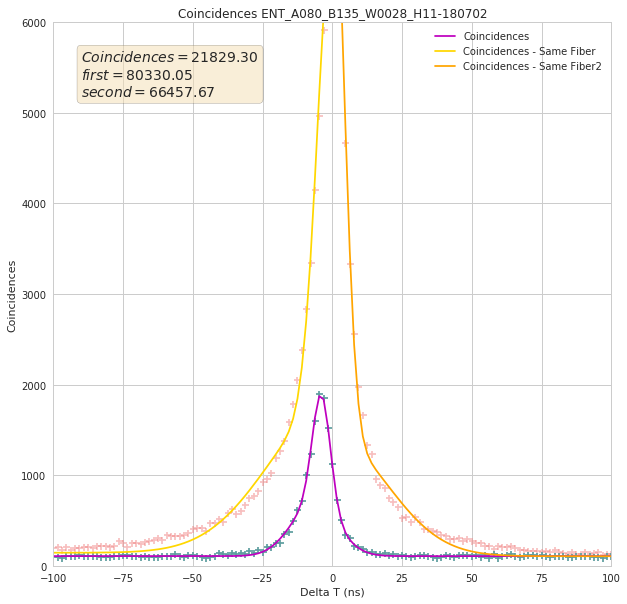

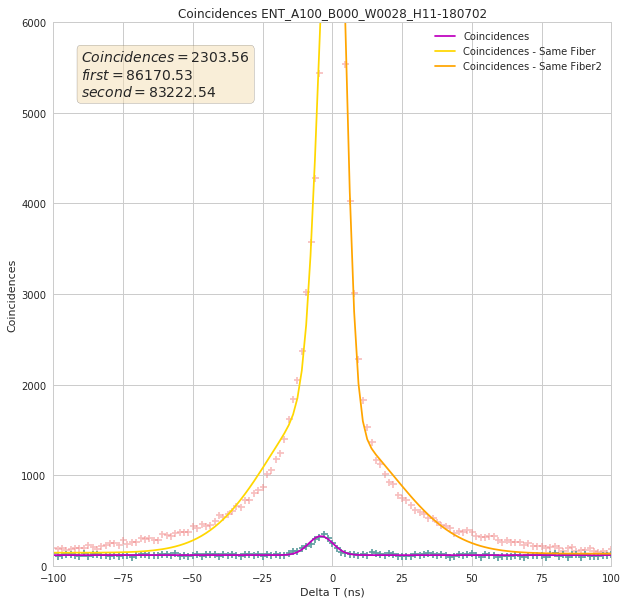

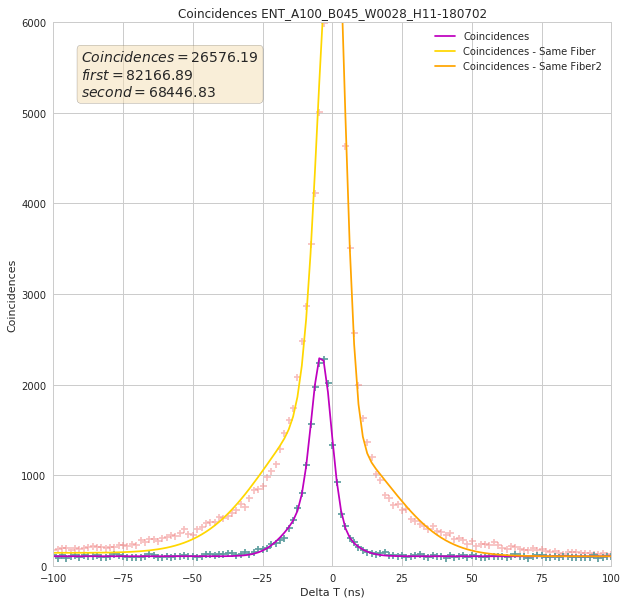

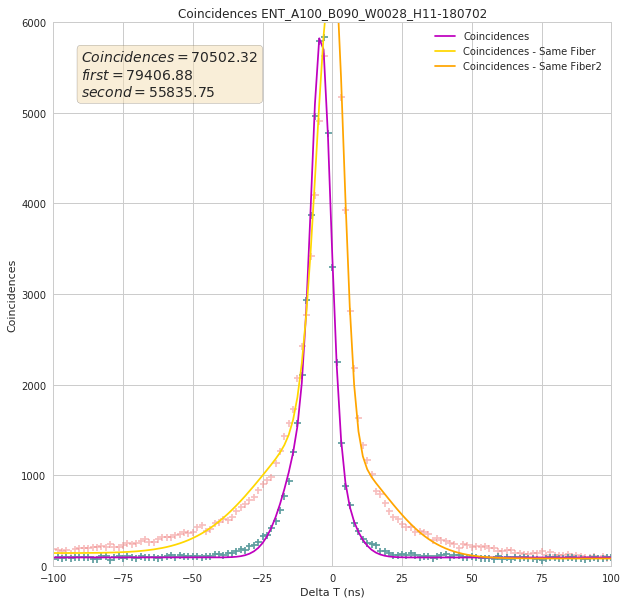

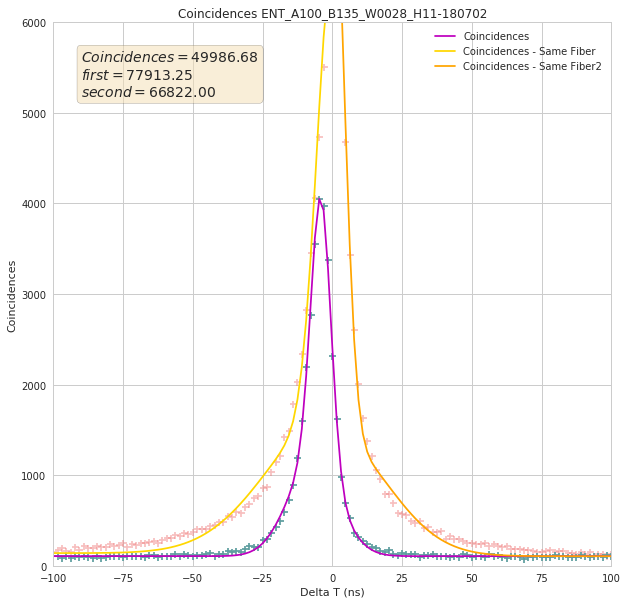

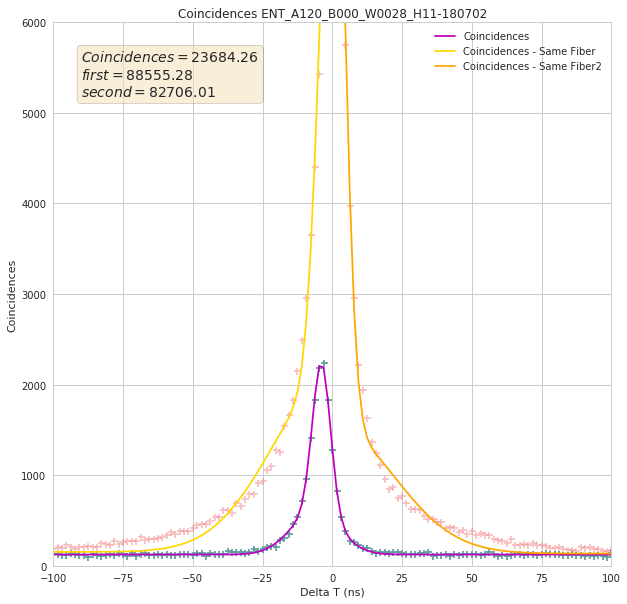

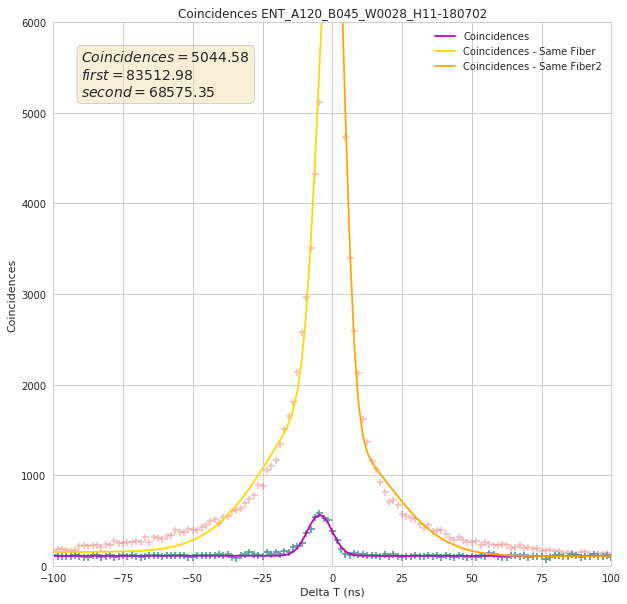

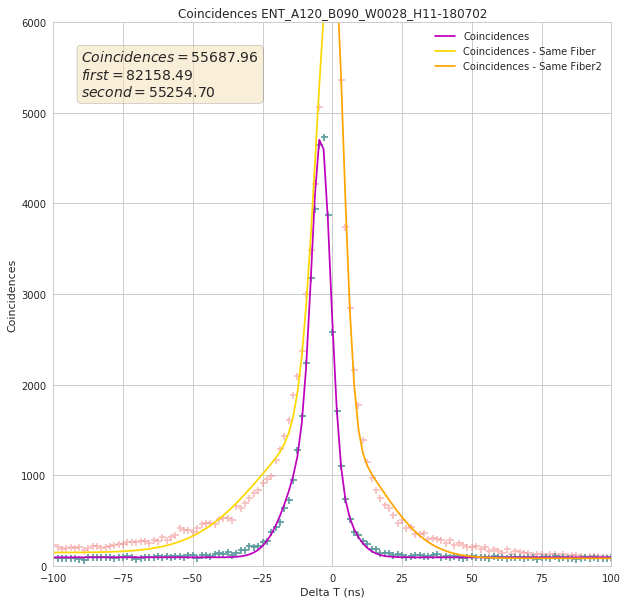

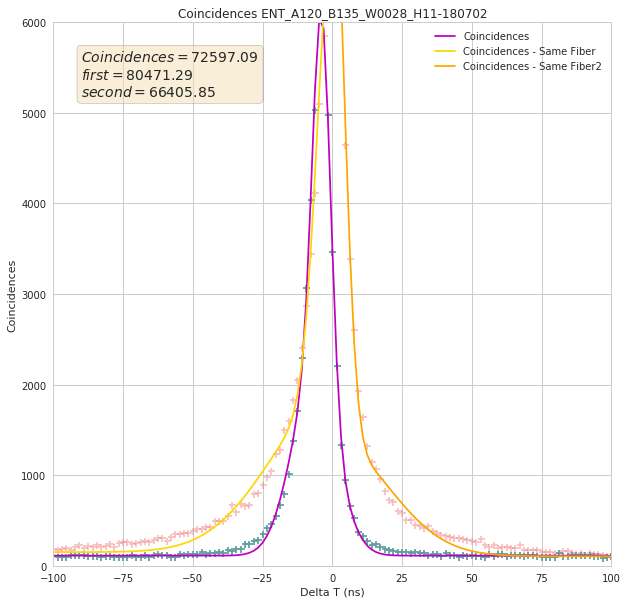

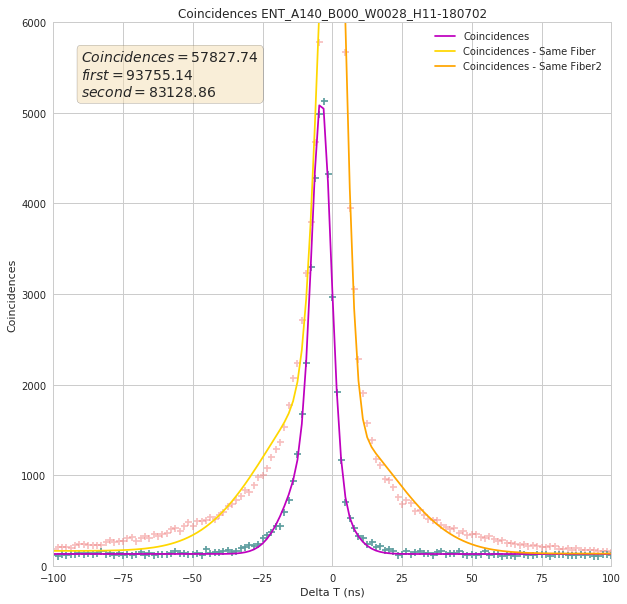

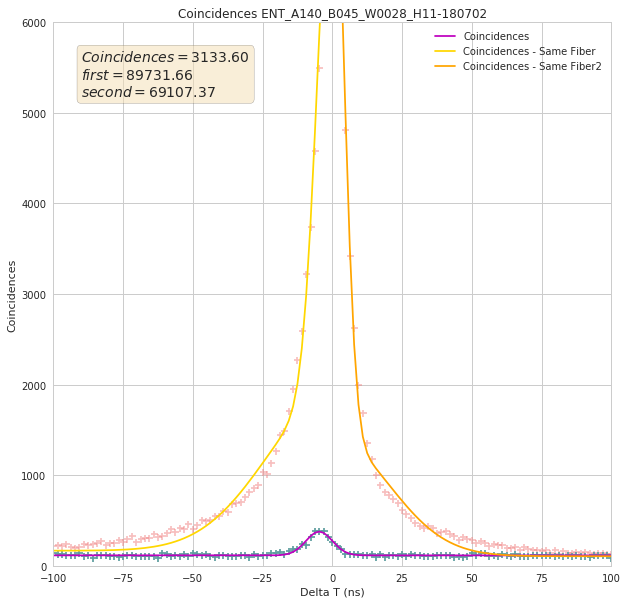

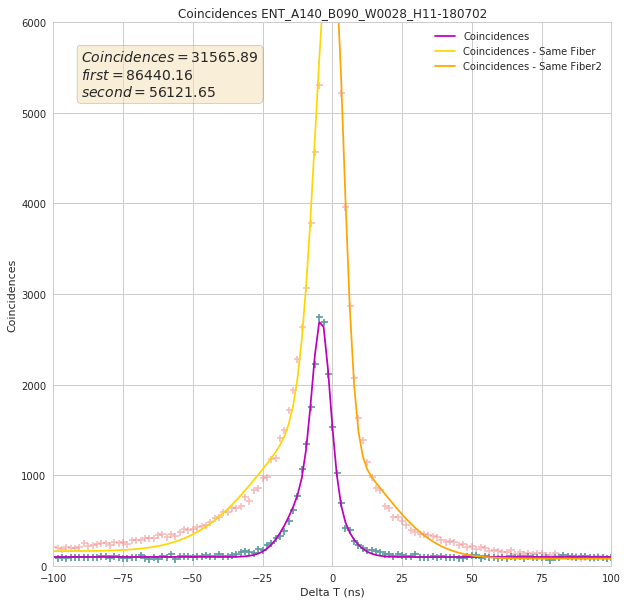

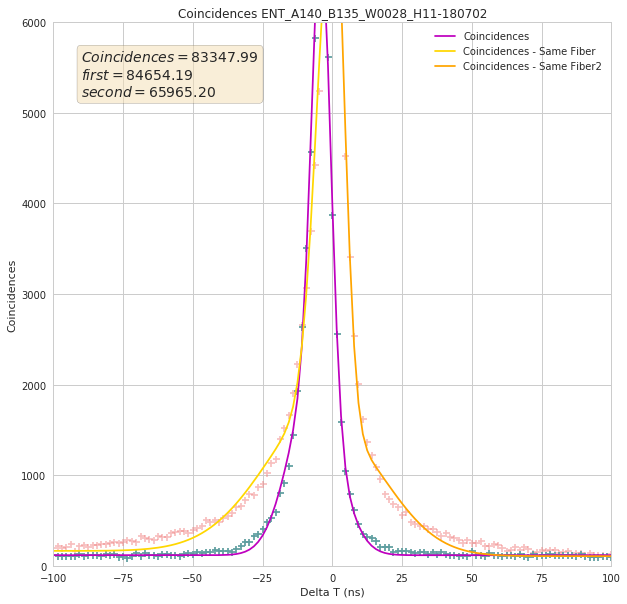

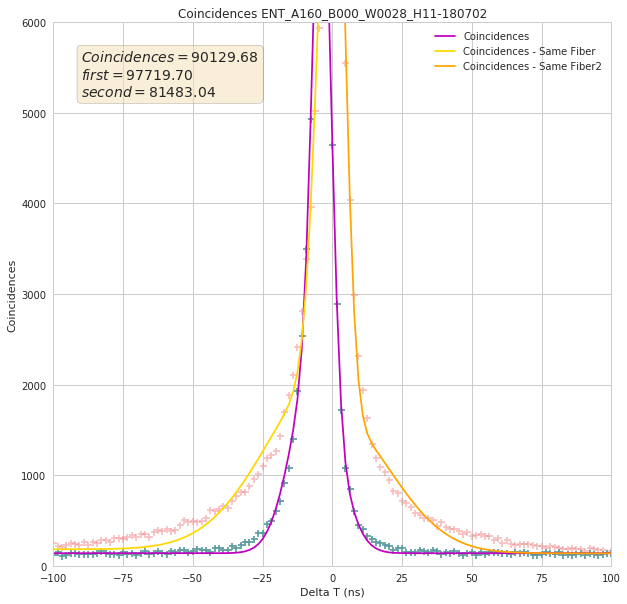

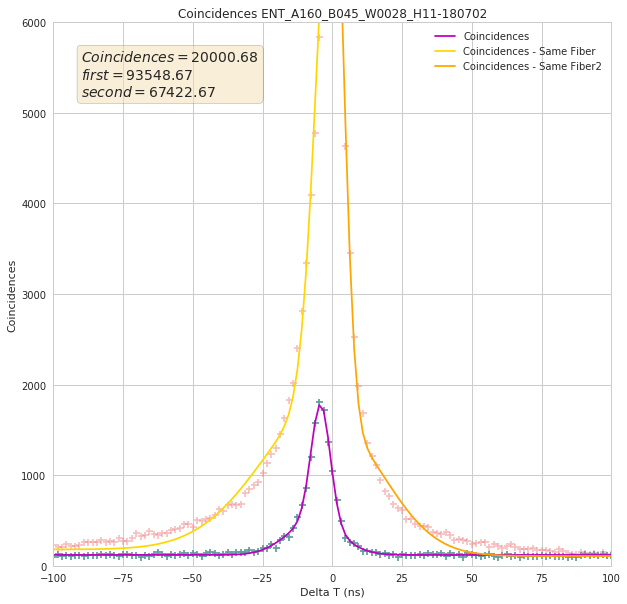

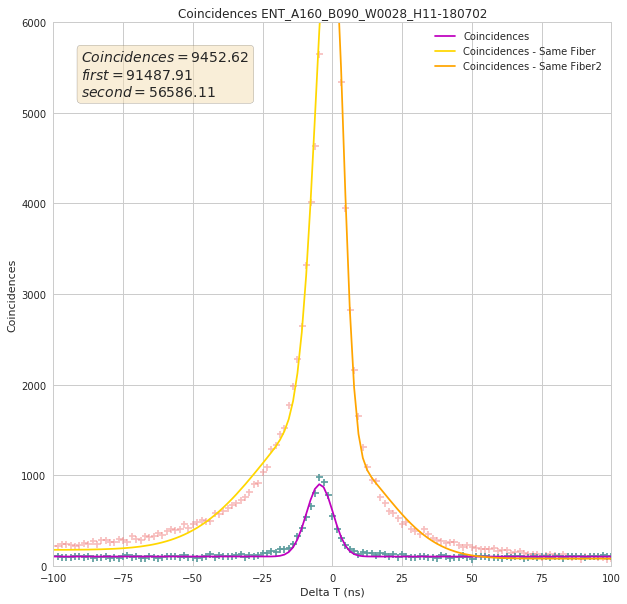

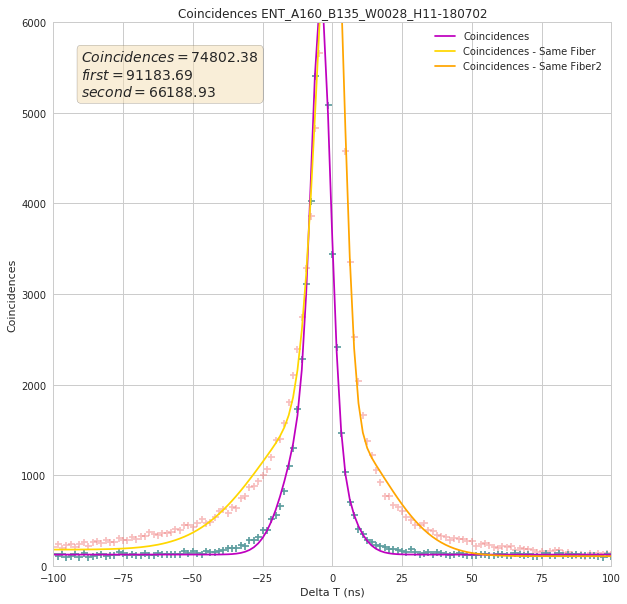

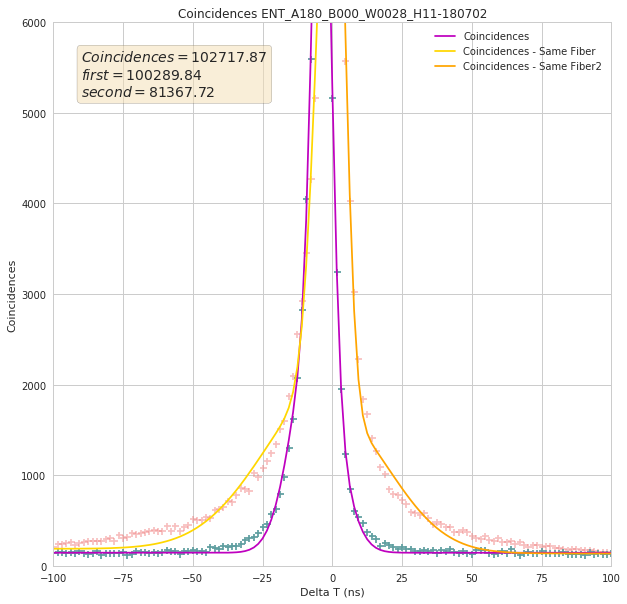

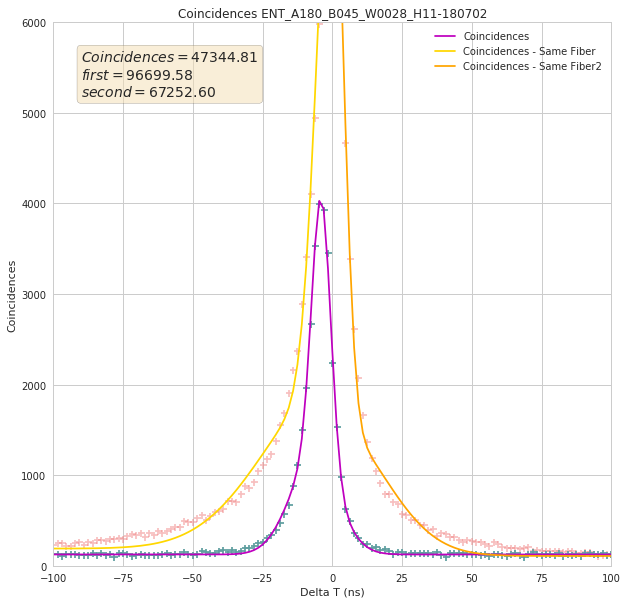

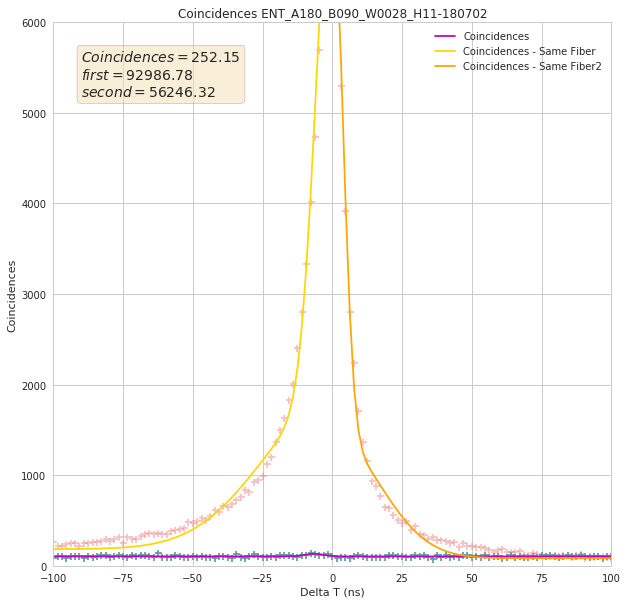

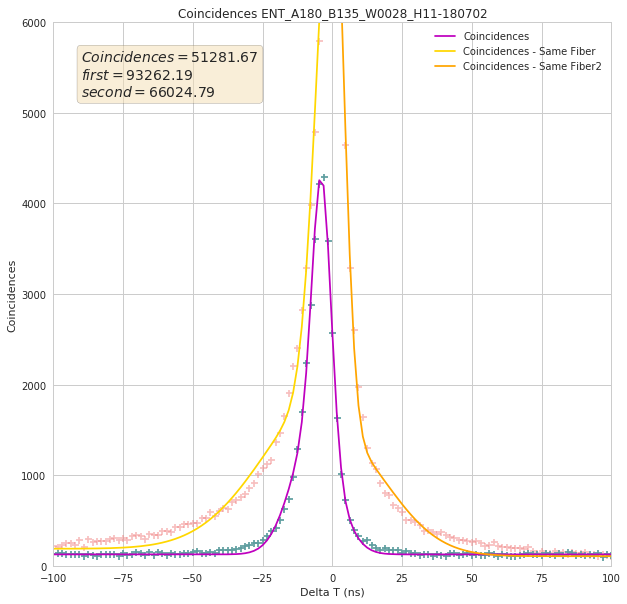

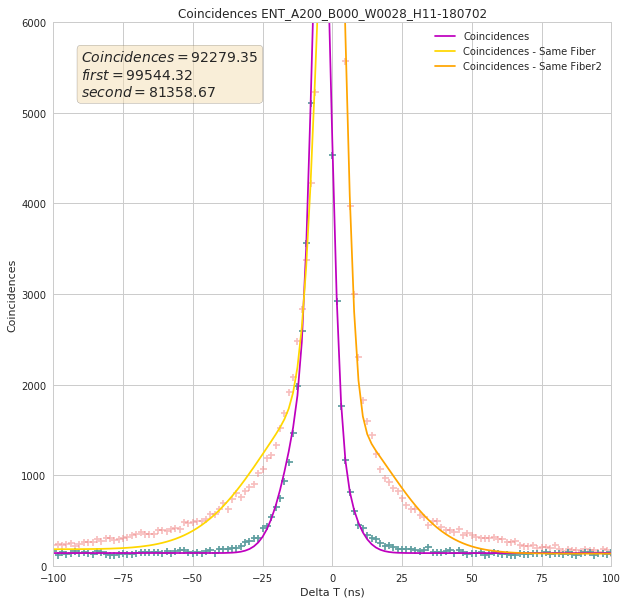

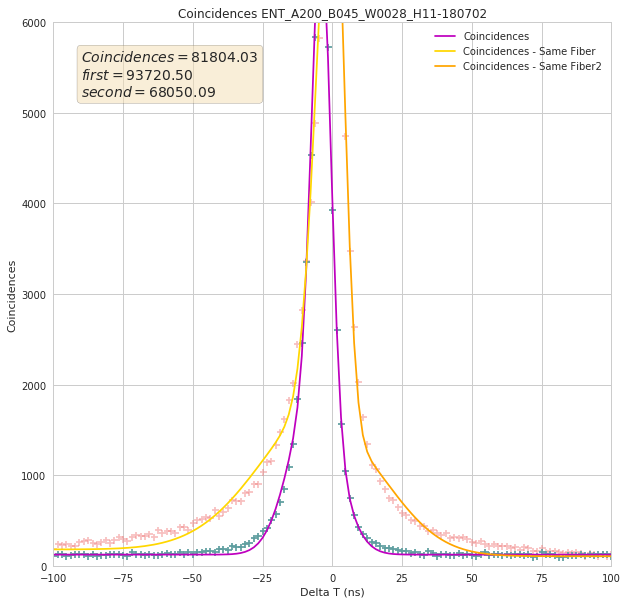

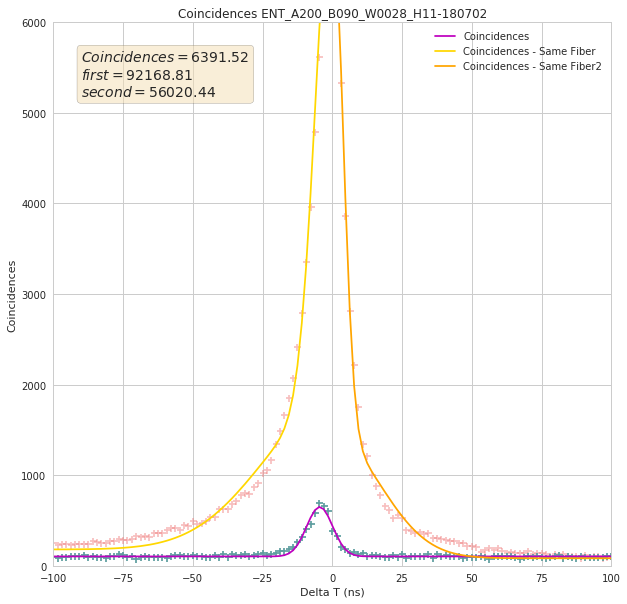

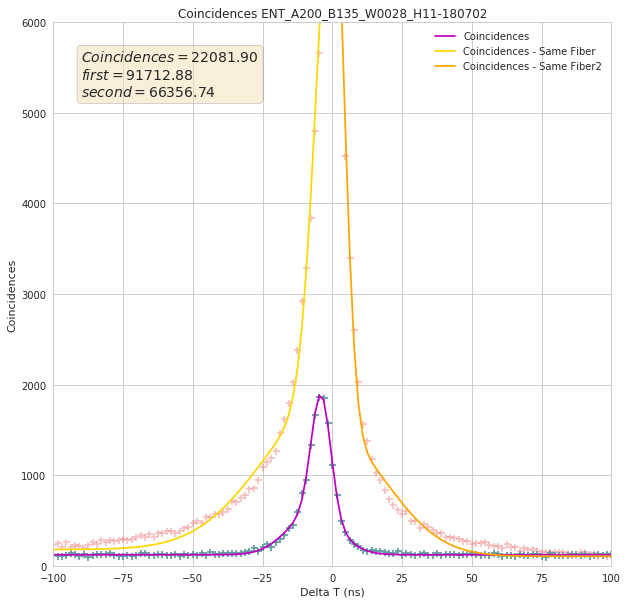

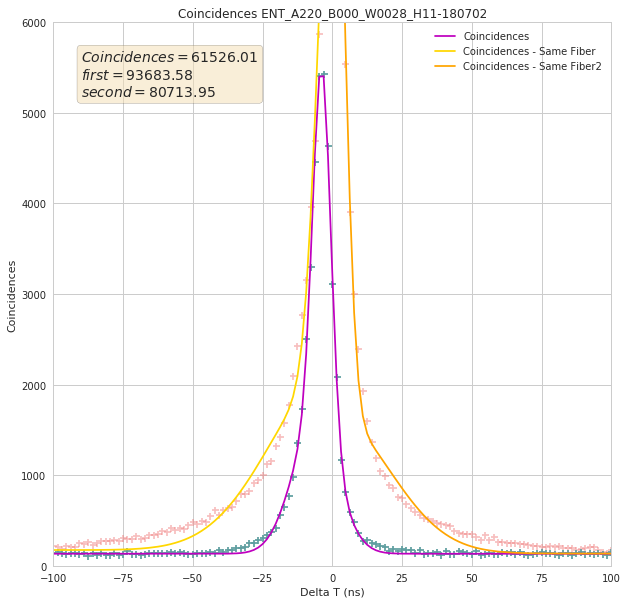

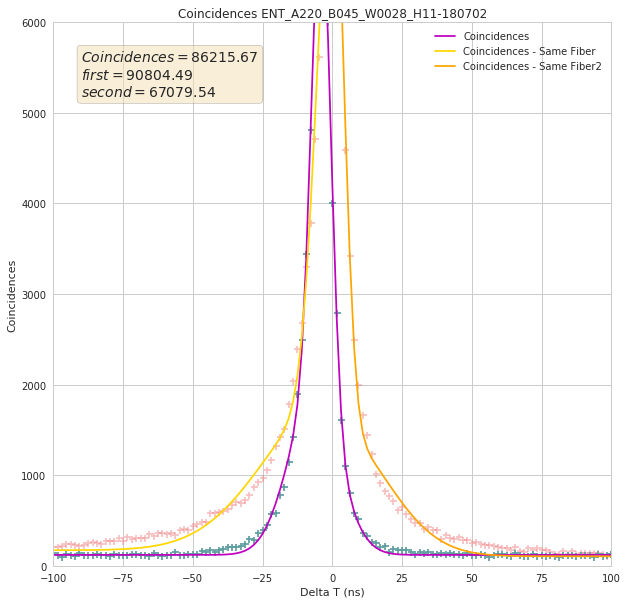

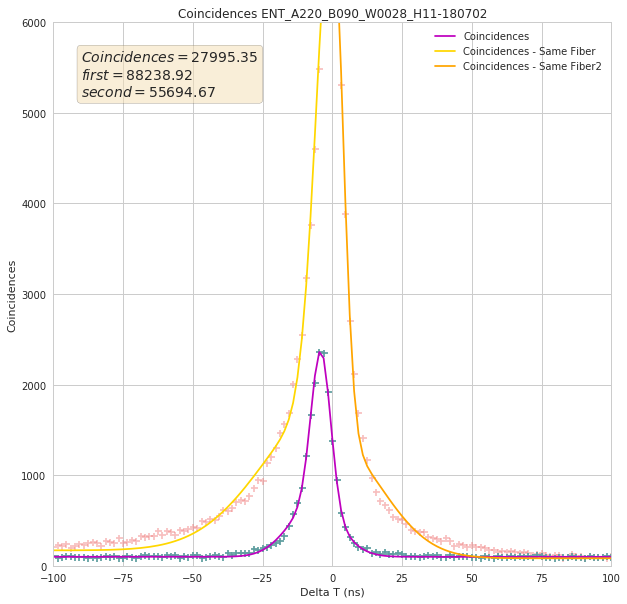

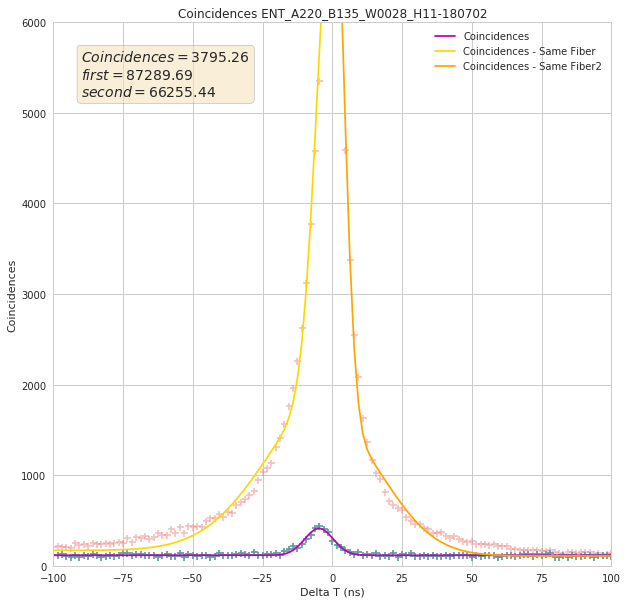

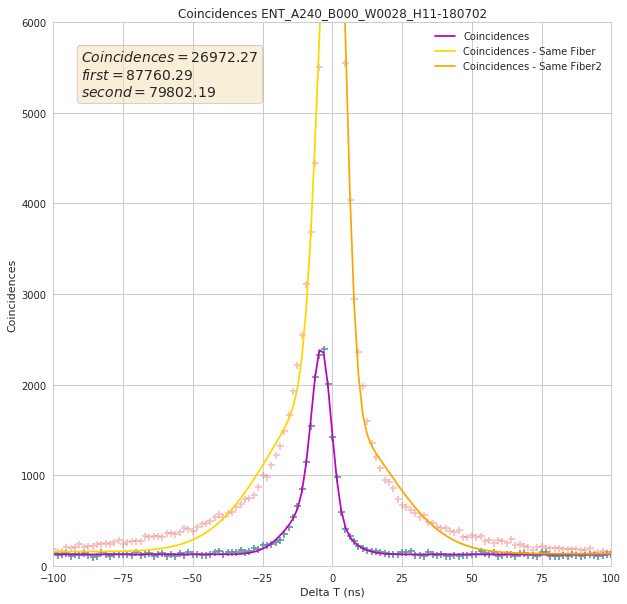

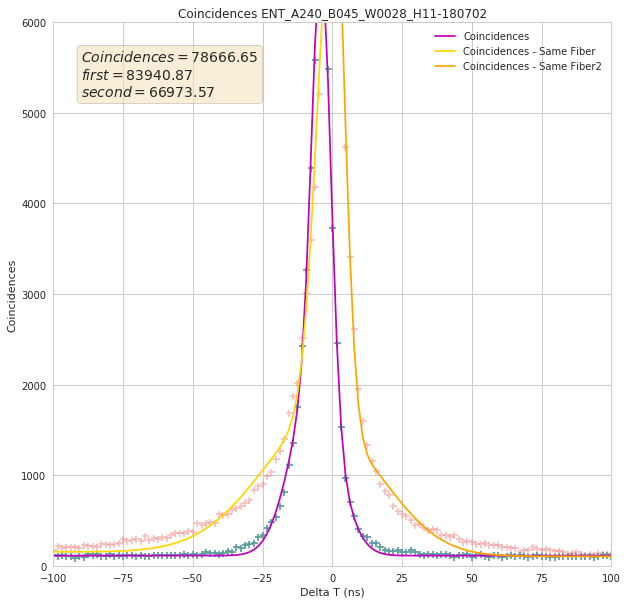

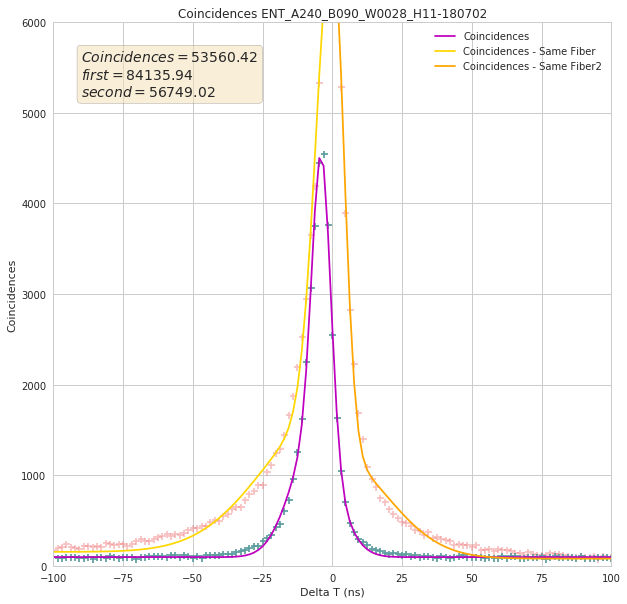

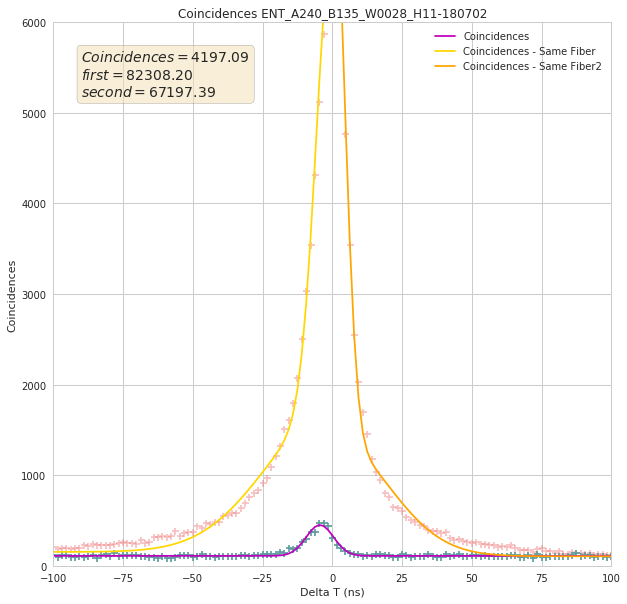

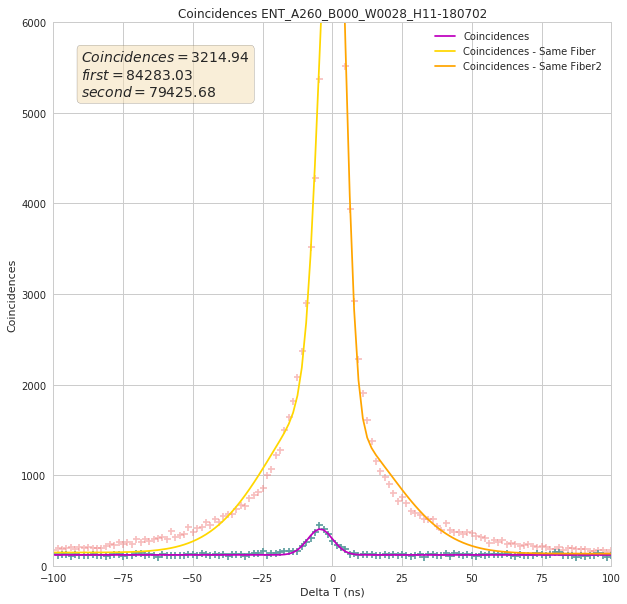

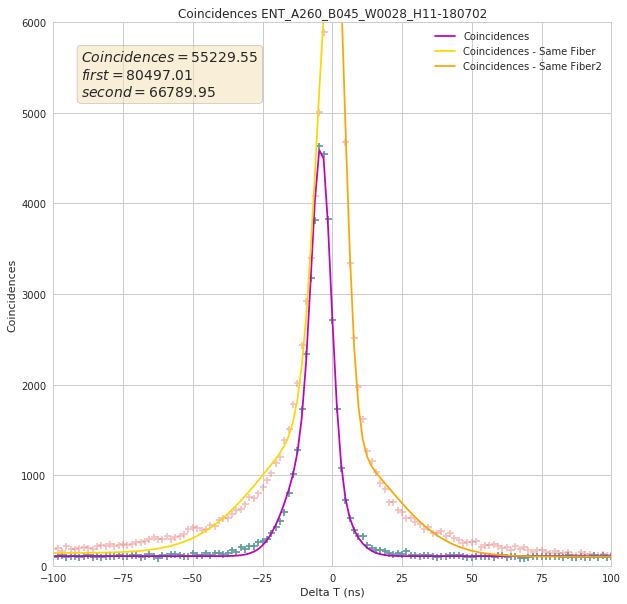

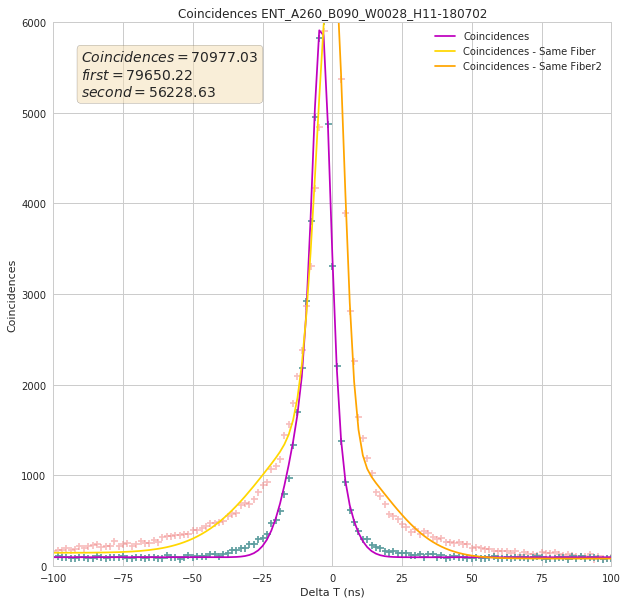

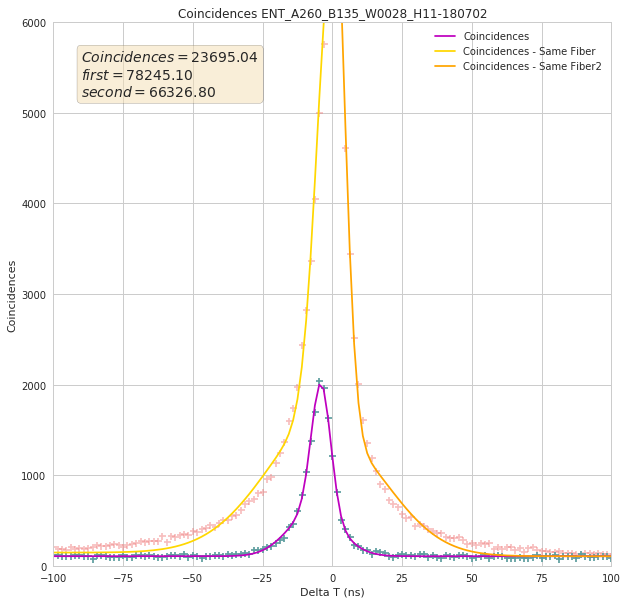

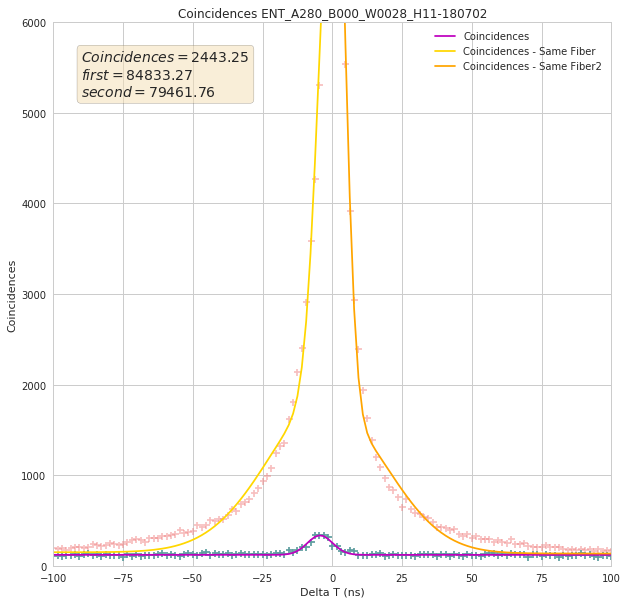

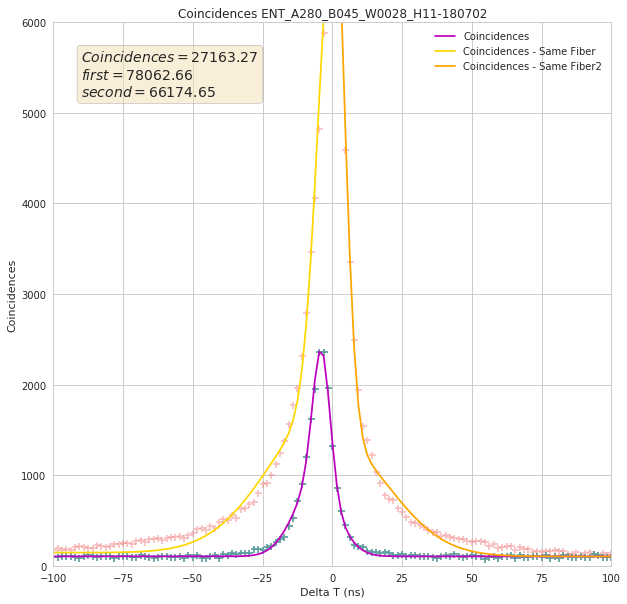

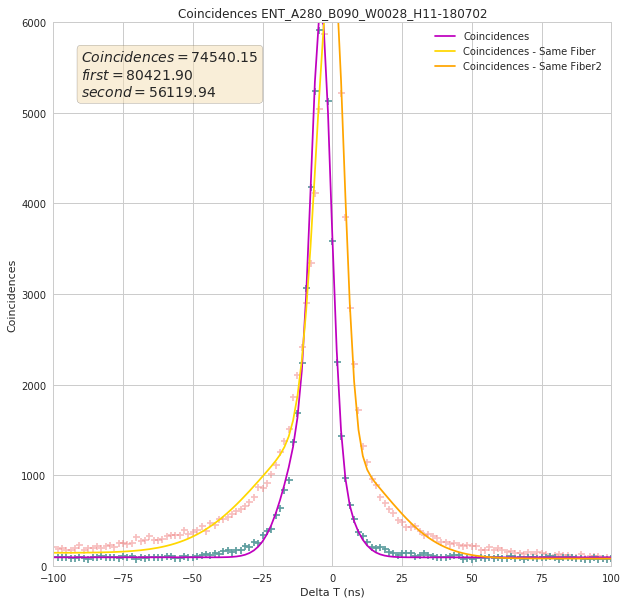

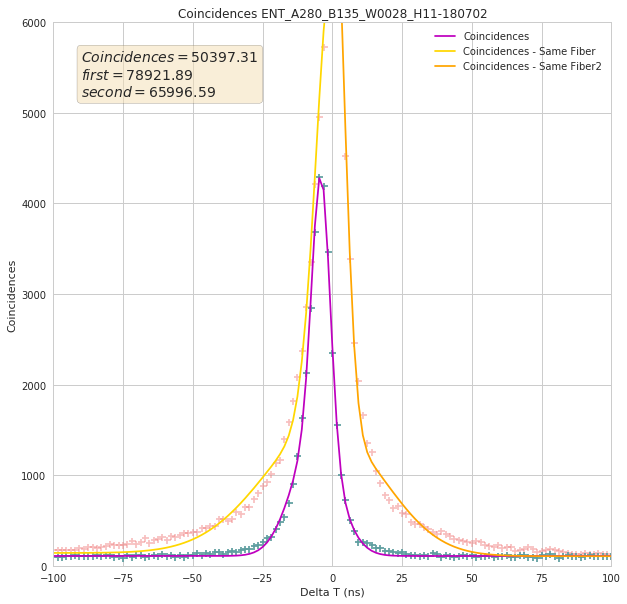

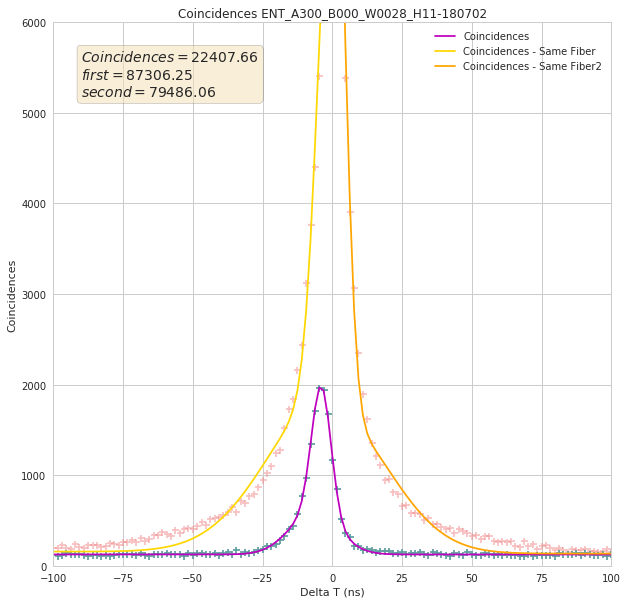

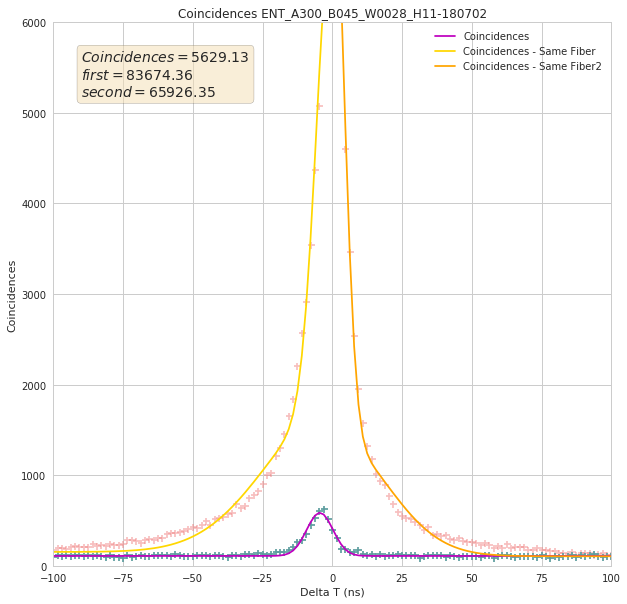

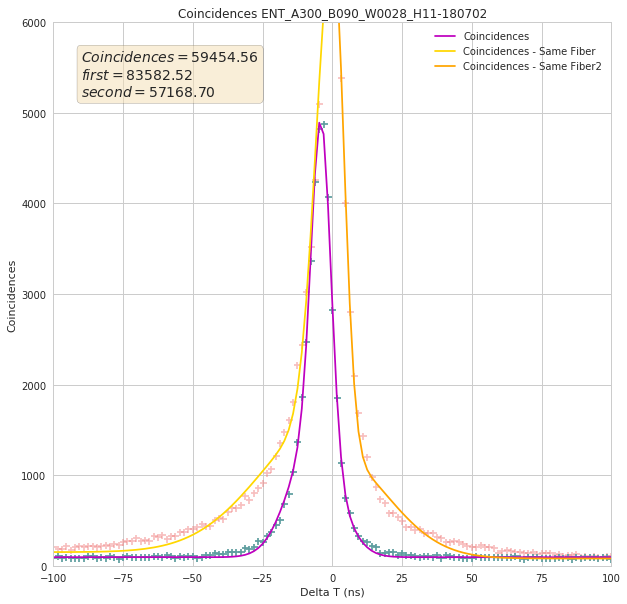

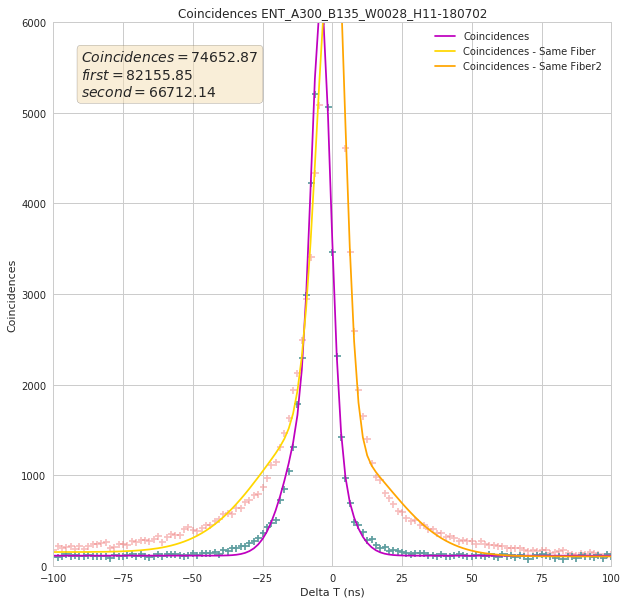

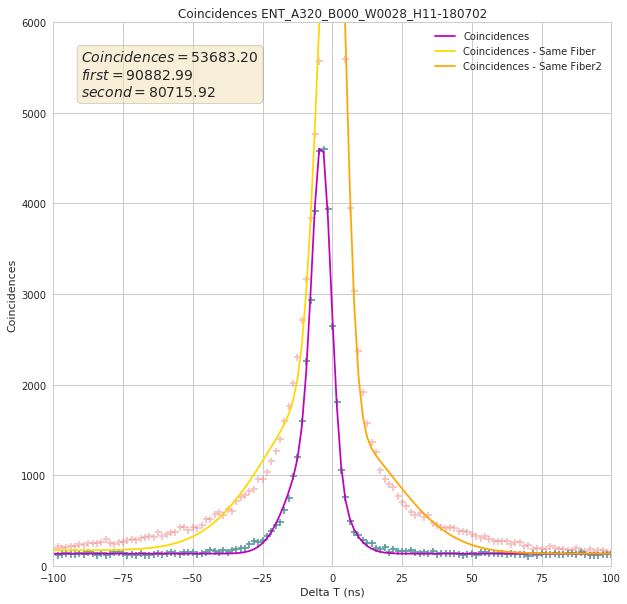

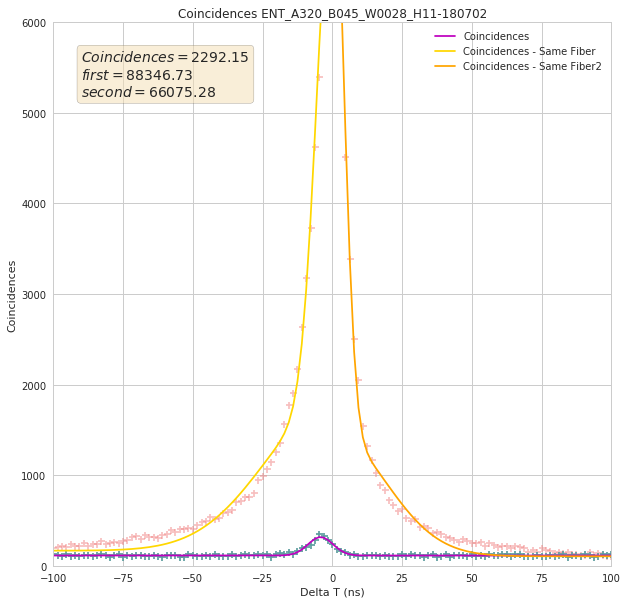

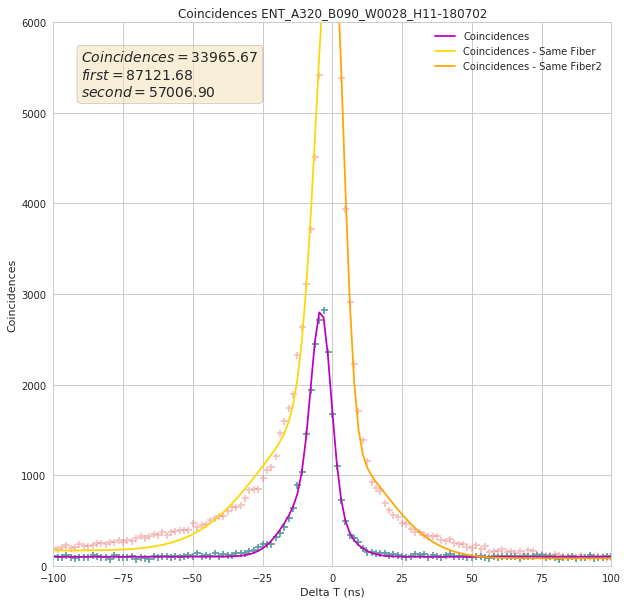

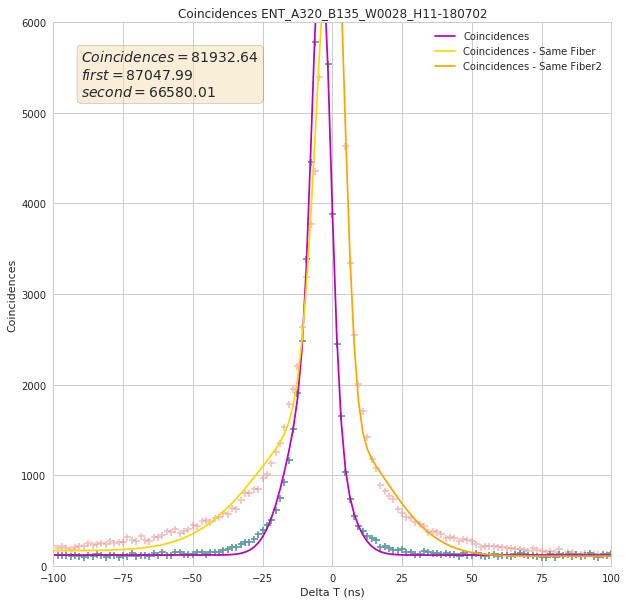

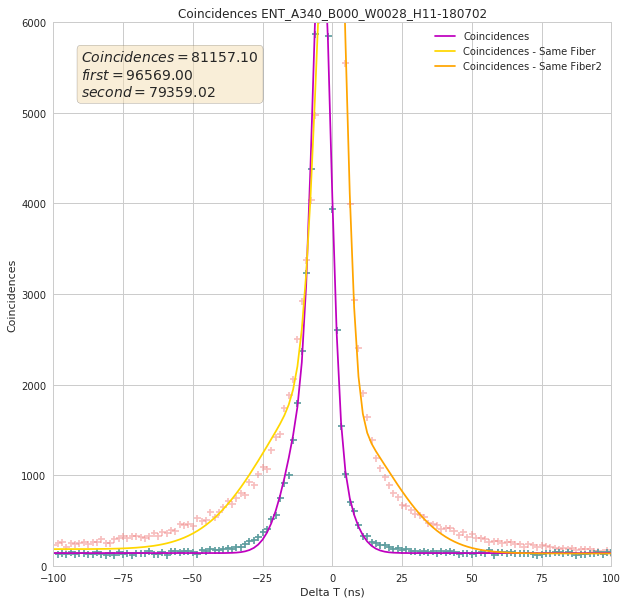

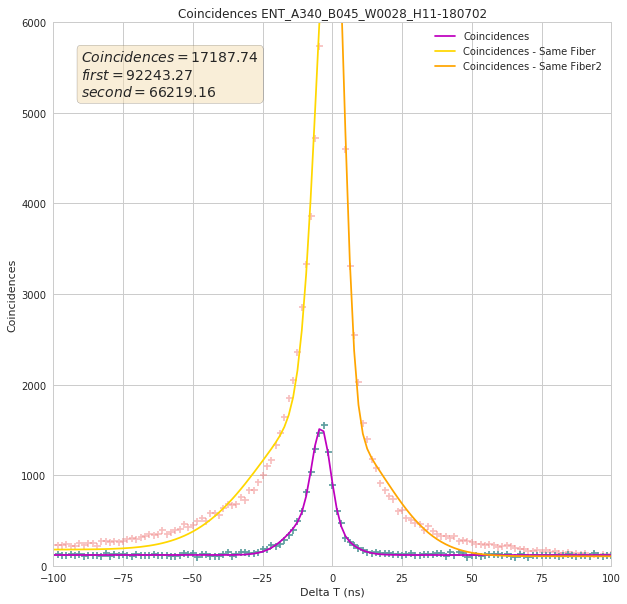

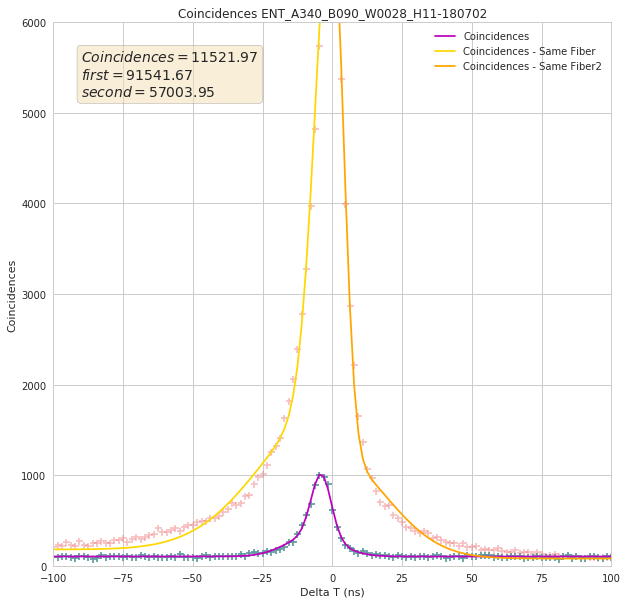

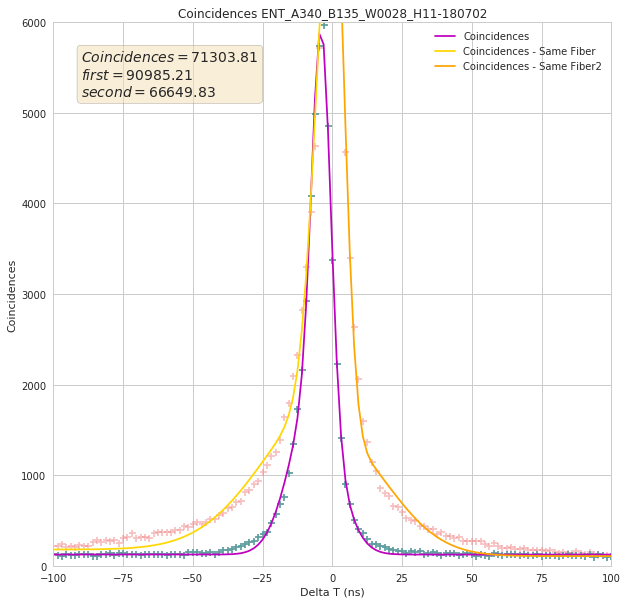

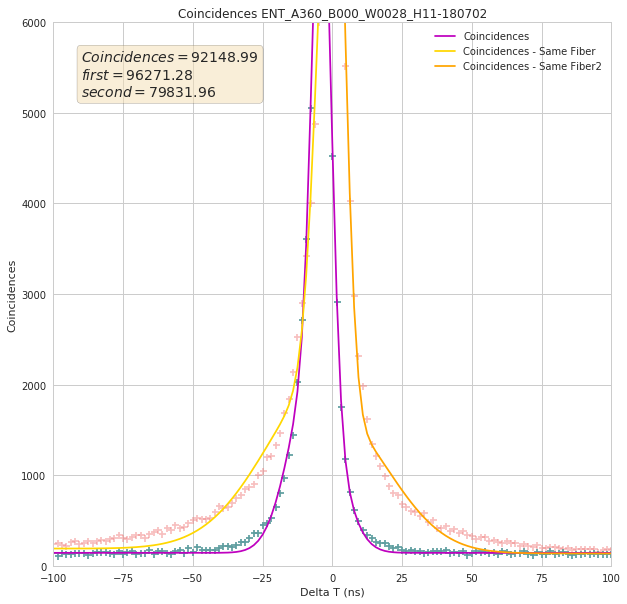

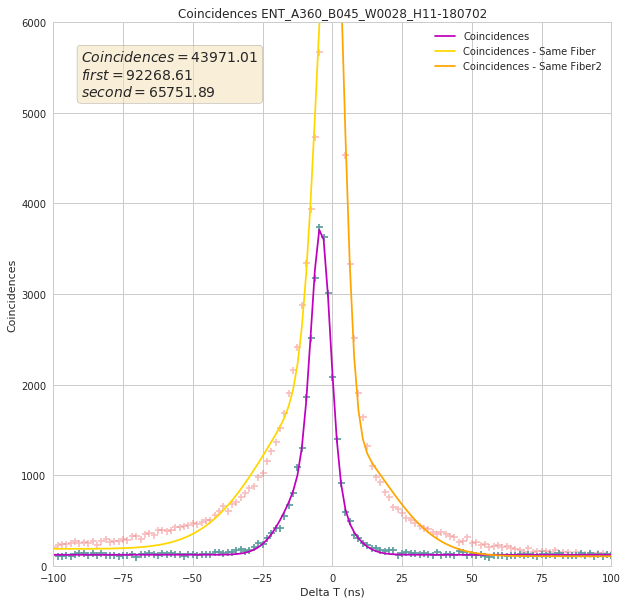

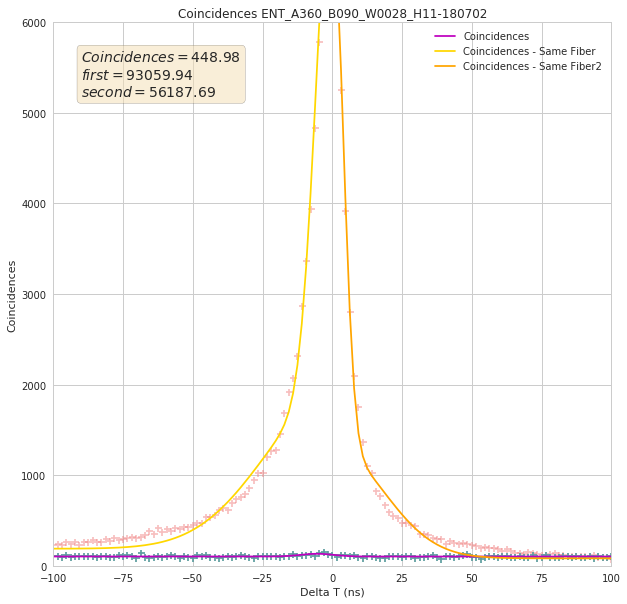

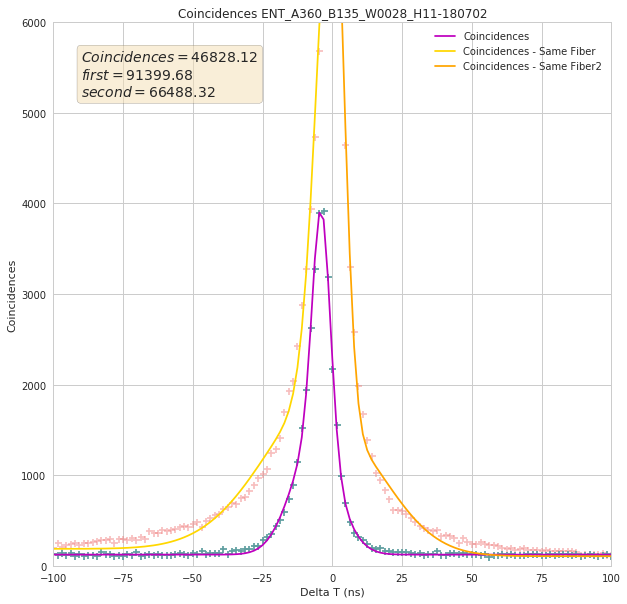

In [23]:
total= np.empty(len(correct_delt))
error = np.empty(len(correct_delt))
first = np.empty(len(correct_delt))
firsterror = np.empty(len(correct_delt))
second = np.empty(len(correct_delt))
seconderror = np.empty(len(correct_delt))
param = (2200,0,40,2200,0,60,300)
param3 = (1000,0,50,800,0,80,300)
#for i in range(16):
for i in range(len(correct_delt)):
    if len(param) < 5:
        param = (900,0,40,500,0,60,200)
    total[i], error[i], first[i], firsterror[i], second[i],seconderror[i],param,param3 = GaussianFit(correct_delt[i],correct_coi[i],correct_fiber[i],'/home/andrew/Documents/BNL 2018/Coding/Images/Gaussians/Gauss'+np.str(i)+'.png',pol[i],param,param3)


In [36]:
datamap = np.column_stack((pol[:72],total,error))       
print(type(datamap))
np.savetxt('coincidences.csv',datamap,fmt='%s')

<class 'numpy.ndarray'>


In [ ]:
 plt.figure(figsize=(10,10))
xaxis = np.linspace(30,50,5)
alpha = first[:5]/total[:5]
beta = second[:5]/total[:5]
delta = first[6:]/total[:5]
epsilon = second[6:]/total[:5]
yaxis = [alpha,beta,delta,epsilon]
#yaxis = [first[:5],second[:5],first[6:],second[6:]]
color = ['r','b','r','b']
yerrorpart = [np.sqrt((firsterror[:5]/first[:5])**2+(error[:5]/total[:5])**2),np.sqrt((seconderror[:5]/second[:5])**2+(error[:5]/total[:5])**2),np.sqrt((firsterror[6:]/first[6:])**2+(error[:5]/total[:5])**2),np.sqrt((seconderror[6:]/second[6:])**2+(error[:5]/total[:5])**2)]
yerror = []
for i in range(len(yaxis)):
    yfill = yaxis[i]*yerrorpart[i]
    yerror.append(yfill)
#yerror = [firsterror[:5],seconderror[:5],firsterror[6:],seconderror[6:]]
labelname = ['Fiber 1 ||','Fiber 2 ||','Fiber 1 _|_','Fiber 2_|_']
for i in range(len(yaxis)):
    print(yaxis[i], 'yaxis')
    print(yerrorpart[i], 'ypart[i]')
    print(yerror[i][1], 'yerror[i]')

    a = 1
    if i > 1:
        a = 0.3
    plt.scatter(xaxis,yaxis[i], label = labelname[i],color = color[i],alpha = a)
    fit = fitting(exp_decay,xaxis,yaxis[i], guess = (22,.5,1))
    plt.errorbar(xaxis,yaxis[i],yerror[i], fmt = 'none', capsize = 3,capthick = 2,linewidth = 2,ecolor = 'k')
    plt.plot(xaxis,fit[0],color = color[i], alpha = a)
    

plt.legend()
#plt.ylim(0,2.5)
plt.ylabel('Same Fiber/Coincidences')
plt.xlabel('Diode Current mA')
plt.title('Coincidences as a Function of  Laser Diode Current', size = 20)
plt.savefig('Images/Current',  bbox_inches='tight')


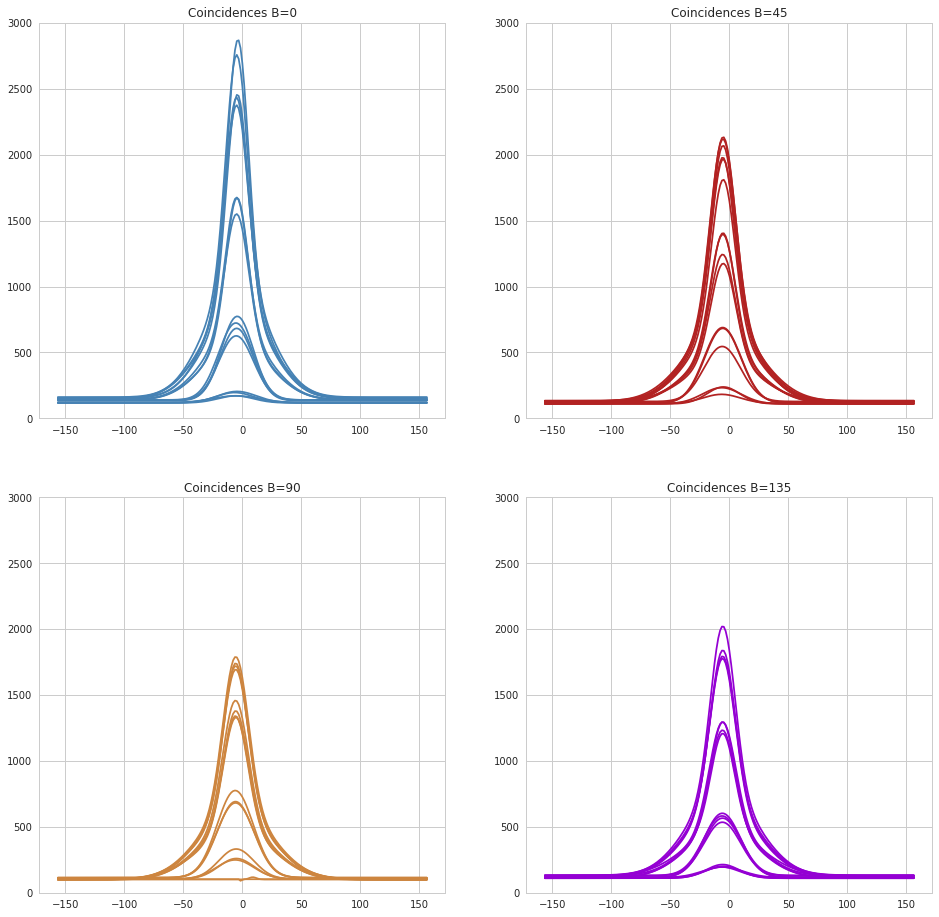

In [28]:
fig = plt.figure(figsize = (16,16))
param = np.array([900,0,40,500,60,200])
polnum = [0,45,90,135]
colorarray = ['steelblue','firebrick','peru','darkviolet'] # colors I will use

for i in range(4):
    plt.subplot(221+i)
    plt.ylim(0,3000)
    plt.title('Coincidences B='+np.str(polnum[i]))
    for j in range(16):  
        if len(param) < 5:
            param = (900,0,40,500,60,200)
        param = GaussCompare(delta[4*j+i],coi[4*j+i],colorarray[i],param)       
plt.show()

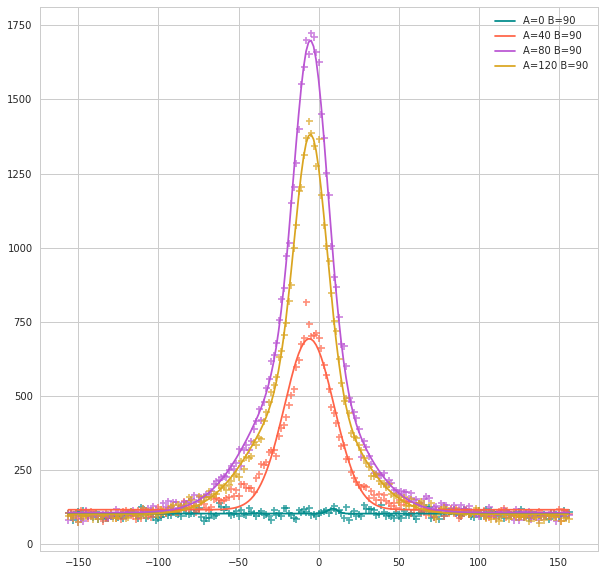

In [26]:
plt.figure(figsize =(10,10) ) 
colorarray = ['darkcyan','tomato','mediumorchid','goldenrod']
param = (2200,0,40,2200,60,300)
plt.rcParams["font.family"] = "Times New Roman"
csfont = {'fontname':'Times New Roman'}
for i in range(4):
    if len(param) < 5:
        param = (900,0,40,500,0,60,200)
    param = GaussianPlot(delta[i*8+2],coi[i*8+2],pol[i],i,param,colorarray[i])
plt.legend()
plt.show()

In [30]:
badcodingpractices = False
# warning cheat to convert file names
if badcodingpractices == True:
    total = total1/2
    error = error1/2
    noisetotal = noisetotal1/2
    noiseerror = noiseerror1/2

In [31]:
if badcodingpractices == True:
    datamap = np.column_stack((total,error,noisetotal, noiseerror))
    np.savetxt("coincidences.csv",datamap , delimiter=',', header="#Coincidences,#Error", comments="")

In [32]:
tot

72


[-4.94323917e+04  1.99818020e+00  4.67997711e+00  4.93747545e+04]
5.623125966842565 [2.45725339e+02 2.12884802e-03 7.55431422e-03 2.23995573e+02] chisq & perr
0
[-4.20629347e+04  1.99084885e+00  3.25066366e+00  4.33742138e+04]
7.219309857963862 [2.25908212e+02 2.07115925e-03 8.38106595e-03 2.02726761e+02] chisq & perr
1
[3.63186775e+04 1.99425147e+00 4.65442720e+00 3.61964617e+04]
6.367302054129893 [2.00577482e+02 2.04350810e-03 6.13446233e-03 1.80347268e+02] chisq & perr
2
[4.06409485e+04 1.99772690e+00 2.99714109e+00 4.21689644e+04]
2.358454385985704 [2.27095628e+02 2.19656763e-03 6.78533586e-03 2.04552590e+02] chisq & perr
3


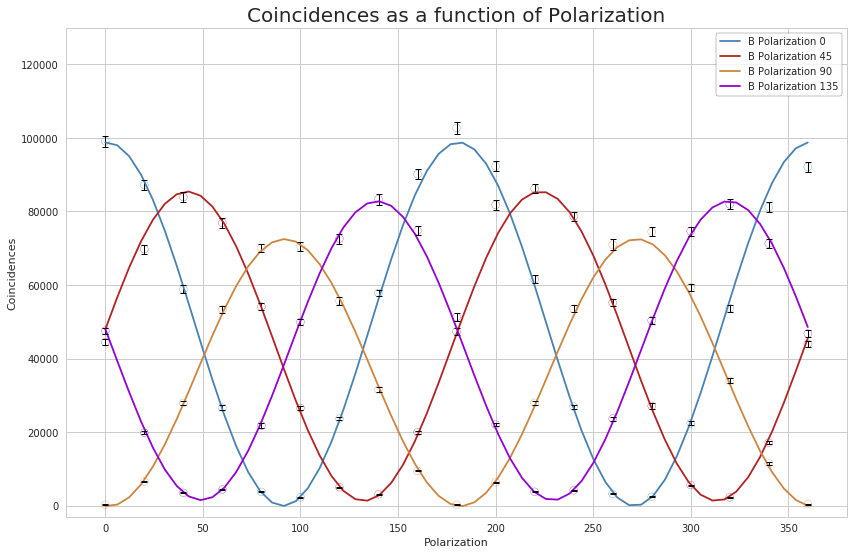

In [24]:
normalized = division(total, first+second)
plt.figure(figsize =(14,9))

parameters = np.empty(16)
normparameters = np.empty(16)
errors = np.empty(16)
normerrors = np.empty(16)
colorarray = ['steelblue','firebrick','peru','darkviolet'] # colors I will use
# plotting function 
#plt.subplot(121)
#'''
for i in range(4):
    plottotal = total[i::4]
    yerror = error[i::4]
    polar = np.linspace(0,360,19)
    polar = polar[:len(plottotal)]
    plt.scatter(polar,plottotal,color = colorarray[i], marker = "o", facecolors='none', s = 60)
    init = (5e+4,2,4,3e+4)
    fit = fitting(sin,polar, plottotal, guess = init, sigma = yerror)
    #fit = fitting(sin,polar, plottotal, guess = init)
    newpol = np.linspace(0,360,60)
    newsin = sin(newpol,*fit[1])
    plt.plot(newpol,newsin,color = colorarray[i], label ='B Polarization '+np.str(i*45),linewidth = 1.8)
    plt.errorbar(polar,plottotal,yerror, fmt = 'none',capsize = 3,capthick = 1,linewidth = 1.0, ecolor = 'k')
    chisq = chi_square_red(polar, plottotal, yerror, sin, fit[1])
    print(fit[1])
    parameters[i*4:(i*4+4)] = fit[1]
    perr = np.sqrt(np.diag(fit[2]))
    errors[i*4:(i*4+4)] = perr
    print(chisq, perr, 'chisq & perr')
    print(i)
plt.ylim(-3000,130000)
plt.xlabel('Polarization')
plt.ylabel('Coincidences')
plt.title('Coincidences as a function of Polarization', fontsize=20 )
plt.legend(frameon=True,edgecolor = 'k')
'''
#plt.subplot(122)

for i in range(4):
    plottotal = first[i::4]
    yerror = firsterror[i::4]
    secerror = seconderror[i::4]
    plt.scatter(polar,plottotal, color = colorarray[i],marker = "o",facecolors='none', s = 60)
    plt.plot(polar,plottotal, color = colorarray[i], label ='B Polarization '+np.str(i*45),linewidth=2.0)
    plt.errorbar(polar,plottotal,yerror, fmt = 'none', capsize = 3,capthick = 1,linewidth = 1, ecolor = 'k')
    plottotal = second[i::4]
    plt.scatter(polar,plottotal, color = colorarray[i],marker = "o", facecolors='none', s = 60)
    plt.plot(polar,plottotal, color = colorarray[i],linewidth=2.0,alpha = 0.6)
    plt.errorbar(polar,plottotal,secerror, fmt = 'none', capsize = 3,capthick = 1,linewidth = 1, ecolor = 'k')
    plt.title('Same Fiber Coincidences', fontsize=20 )
    plt.legend(frameon=True,edgecolor = 'k', loc = 1)
plt.ylim(0,100000)
plt.subplot(133)
for i in range(4):
    plottotal = normalized[i::4]
    yerror = error[i::4]
    plt.scatter(polar,plottotal,color = colorarray[i], marker = "o",facecolors='none', s = 60)
    init = (1,180,90,0.2)
    fitnorm = fitting(sin,polar, plottotal, guess = init)
    newpol = np.linspace(0,360,60)
    newy = sin(newpol,*fitnorm[1])
    normparameters[i*4:(i*4+4)] = fitnorm[1]
    plt.plot(newpol,newy,color = colorarray[i], label ='B Polarization '+np.str(i*45),linewidth=2.0)
    chisq = chi_square_red(polar, plottotal, yerror/1e+5, sin, fitnorm[1])
    perr = np.sqrt(np.diag(fitnorm[2]))
    normerrors[i*4:(i*4+4)] = perr
    print(fitnorm[1])
    print(chisq, perr, 'chisq & perr')
plt.legend(loc = 1,frameon=True)    
'''
plt.show()

In [35]:
const= np.empty(len(delta))
consterror = np.empty(len(delta))
param = (2200,0,40,2200,60,300)

for i in range(len(delta)):
    if len(param) < 5:
        param = (900,0,40,500,60,200)
  
    const[i], consterror[i],param = GaussianConst(delta[i],coi[i],param)

In [36]:
width= np.empty(len(delta))
widtherror = np.empty(len(delta))
param = (2200,0,40,2200,60,300)
for i in range(len(delta)):
    if len(param) < 5:
        param = (900,0,40,500,60,200)
    width[i], widtherror[i],param = Gaussianwidth(delta[i],coi[i],param)
print(width)
print(np.mean(width))
    

[20.41875675 24.32341265  7.14359348 22.65171598 21.49041074 22.90382514
 35.38735459 36.78643608 21.90070122 24.50680322 36.53332468 34.10787466
 31.98892839 23.66289678 24.89131045 33.2359229  38.60590823 23.39358005
 25.03488723 37.24800565 35.34290316 35.9804415  23.32941617 24.71938821
 32.97503721 32.54418077 23.83764261 24.99073694 23.65390586 37.05284832
 36.13573241 24.03868604 23.14545473 36.55408064 35.09815679 24.19138927
 21.29816671 24.42424457  1.00283226 25.97884612 22.74139943 23.18107968
 37.30420416 37.20973337 21.7682662  24.95015379 37.49298143 40.0141843
 34.54003584 22.60261875 24.10656246 35.16840878 36.4752317  24.56500964
 24.84395733 36.58957832 45.58638175 36.71987779 24.81367782 23.74539283
 34.56347643 38.69585928 24.83393262 25.09942802 23.8755379  36.12685316
 37.09185476 25.50245168 24.39594825 36.91943622 37.07727931 24.79432263]
28.832011872004916


In [ ]:
plt.figure(figsize =(20,10))
#plt.subplot(121)
colorarray = ['steelblue','firebrick','peru','darkviolet'] # colors I will use
# plotting function 
for i in range(4):
    plottotal = const[i::4]
    yerror =consterror[i::4]  
    polar = np.linspace(0,360,19)
    polar = polar[:len(plottotal)]
    plt.scatter(polar,plottotal, marker = "x", s = 48,color = colorarray[i])
    plt.plot(polar,plottotal, label ='B Polarization '+np.str(i*45),color = colorarray[i],linewidth=1.0)
plt.errorbar(polar,plottotal,yerror, fmt = 'none', ecolor = 'r')
plt.title('Background  Values',fontsize = 18)
plt.xlabel('A Polarization')
plt.ylabel('# of Coincidences')
plt.legend()
'''
plt.subplot(122)
for i in range(4):
    SN = total[i::4]/(const[i::4])
    plt.scatter(polar,SN, marker = "x", s = 48,color = colorarray[i])
    plt.plot(polar,SN, label ='B Polarization '+np.str(i*45),color = colorarray[i],linewidth=1.0)
'''
plt.title('Signal to Background Ratio', fontsize = 18)
plt.xlabel('A Polarization')
plt.ylabel('Signal/Noise')
plt.show()

In [26]:
def fixer(parameters):
    x = np.linspace(60,300,60)
    plt.figure(figsize =(20,10))
    plt.subplot(121)
    for i in range(4):
        plt.plot(x,sin(x,*parameters[i*4:(i*4+4)]))
    plt.show
    print(parameters)
    for i in range(0,4):
        if parameters[i*4] < 0:
            print(parameters[i*4])
            parameters[i*4] = np.absolute(parameters[i*4])
            parameters[4*i+2] = -parameters[((4*i)+2)]  
            parameters[4*i+1] = -parameters[((4*i)+1)]   
    print(parameters)
    plt.subplot(122)
    for i in range(4):
        plt.plot(x,sin(x,*parameters[i*4:(i*4+4)]))
    plt.show()                                              
    return(parameters)

In [27]:
def Sval(parameters):
    # Bell Inequality s values
    E = np.zeros(4)
    x = np.array([22.5,67.5,112.5,157.5])
    C= np.zeros(16)
    index = np.array([1,3,9,11,5,7,13,15,8,10,0,2,12,14,4,6])
    for i in range(4):
        parm = parameters[i*4:(i*4+4)]
        C[i::4]= sin(x,*parm)
    for i in range(4):
        num = C[index[4*i]]-C[index[4*i+1]]-C[index[4*i+2]]+C[index[4*i+3]]
        den = (C[index[4*i]]+C[index[4*i+1]]+C[index[4*i+2]]+C[index[4*i+3]])
        E[i] = num/den
        #print(den)
        #print(i)
    print(E, "E")
    S = E[0]+E[1]-E[2]+E[3]
    print(S)
    max = 2*np.sqrt(2)
    print(max)
    return S,C,E

In [28]:
def errorprop(parameters,C,E,errors):
# Error Propogation for each C
    coi_err = np.zeros(16)
    E_err = np.zeros(4)
    x = np.array([22.5,67.5,112.5,157.5])
    index = np.array([1,3,9,11,5,7,13,15,8,10,0,2,12,14,4,6])
    for i in range(4):
        parm = parameters[i*4:(i*4+4)]
        perr = errors[i*4:(i*4+4)]
        a =  parm[0]
        b =  parm[1]
        c =  parm[2]
        d =  parm[3]
        a_err = perr[0]
        b_err = perr[1]
        c_err = perr[2]
        d_err = perr[3]
        #print(a,b,c,d)
        #print(a_err,b_err,c_err,d_err)
        for j in range(4):
            coi_err[4*i+j] =np.sqrt(np.sin((np.pi*c)/180 + (2*np.pi*x[j])/b)**2*a_err**2 +  \
            (2*a* np.pi*x[j])**2 * (np.cos((np.pi*c)/180 + (2*np.pi*x[j])/b)**2*b_err**2)/b**4 +  \
            (a/180)**2* np.cos((np.pi*c)/180 + (2*np.pi*x[j])/b)**2*(c_err*np.pi)**2 + \
            d_err**2)
    print(C)
    print(coi_err)
    for i in range(16):
        if np.isnan(coi_err[i]) == True:
            print(i, 'C FUCKED UP')
    # Error Propogation in E
    for i in range(4):
        num = C[index[4*i]]-C[index[4*i+1]]-C[index[4*i+2]]+C[index[4*i+3]]
        den = (C[index[4*i]]+C[index[4*i+1]]+C[index[4*i+2]]+C[index[4*i+3]])
        num_err = np.sqrt(coi_err[index[4*i]]**2+coi_err[index[4*i+1]]**2+coi_err[index[4*i+2]]**2+coi_err[index[4*i+3]]**2)
        den_err = np.sqrt(coi_err[index[4*i]]**2+coi_err[index[4*i+1]]**2+coi_err[index[4*i+2]]**2+coi_err[index[4*i+3]]**2)
        E_err[i] = E[i]*np.sqrt((num_err/num)**2+(den_err/den)**2)
    #Error Propogation in S
    print(E_err)
    S_err = np.sqrt(E_err[0]**2+E_err[1]**2+E_err[2]**2+E_err[3]**2)
    print(S_err,'error')
    return(S_err)

In [26]:
para = np.copy(parameters)
print(parameters)
print(para)
print(para[2::4])
para[2] += np.pi
para[6] += np.pi
print(para[2::4])
phaseshift = (-1)*(para[2::4]/para[1::4])*(180/np.pi)
print(phaseshift)
print(phaseshift+180.2)


[-4.94323917e+04  1.99818020e+00  4.67997711e+00  4.93747545e+04
 -4.20629347e+04  1.99084885e+00  3.25066366e+00  4.33742138e+04
  3.63186775e+04  1.99425147e+00  4.65442720e+00  3.61964617e+04
  4.06409485e+04  1.99772690e+00  2.99714109e+00  4.21689644e+04]
[-4.94323917e+04  1.99818020e+00  4.67997711e+00  4.93747545e+04
 -4.20629347e+04  1.99084885e+00  3.25066366e+00  4.33742138e+04
  3.63186775e+04  1.99425147e+00  4.65442720e+00  3.61964617e+04
  4.06409485e+04  1.99772690e+00  2.99714109e+00  4.21689644e+04]
[4.67997711 3.25066366 4.6544272  2.99714109]
[7.82156976 6.39225632 4.6544272  2.99714109]
[-224.27553695 -183.96640651 -133.72387519  -85.9594648 ]
[-44.07553695  -3.76640651  46.47612481  94.2405352 ]


In [49]:
p= fixer(parameters)
S,C,E = Sval(p)
S_error = errorprop(p,C,E,errors)


NameError: name 'fixer' is not defined

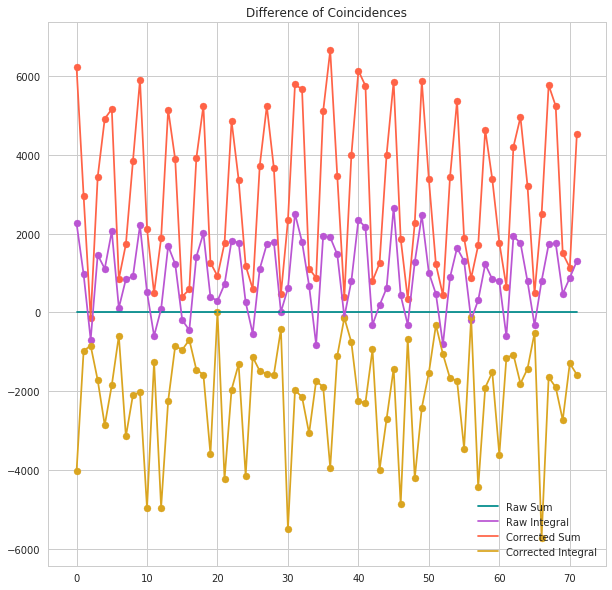

In [27]:
raw_sum = np.genfromtxt('totsum.csv')
raw_int = np.loadtxt('totint.csv')
corr_sum = np.loadtxt('corrsum.csv')
corr_int = np.loadtxt('corrint.csv')
color = ['darkcyan','tomato','mediumorchid','goldenrod']
plt.figure(figsize = (10,10))
x = np.linspace(0,71,72)
off = 1.5625
plt.plot(raw_sum*off-raw_sum*off, label = 'Raw Sum',color =color[0])
plt.plot(x,raw_int-(raw_sum*off), label = 'Raw Integral',color =color[2])
plt.plot(x,corr_sum[:72]*off-(raw_sum*off),label ='Corrected Sum',color =color[1])
plt.plot(x,corr_int[:72]-(raw_sum*off),label = 'Corrected Integral',color =color[3])
plt.scatter(x,raw_int-(raw_sum*off),marker = 'o', color=color[2])
plt.scatter(x,corr_sum[:72]*off-(raw_sum*off),marker = 'o', color =color[1])
plt.scatter(x,corr_int[:72]-(raw_sum*off),marker = 'o',color =color[3])
#plt.ylim(-0.5,2.5)
plt.legend(loc = 4)
plt.title('Difference of Coincidences')
plt.show()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]


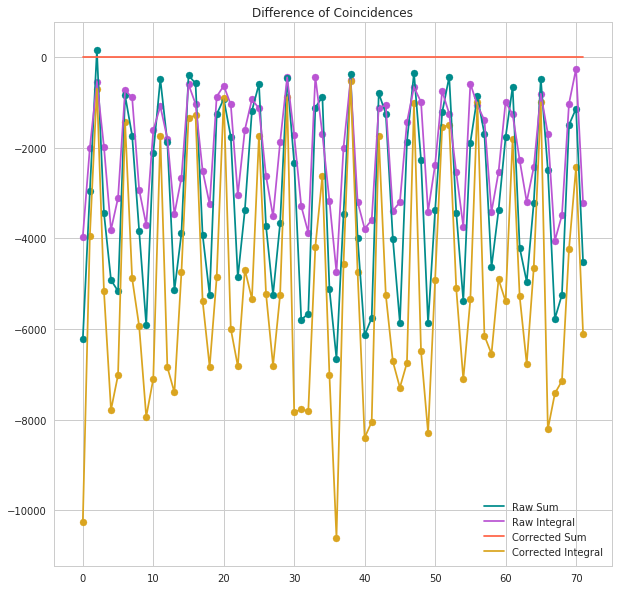

In [28]:
raw_sum = np.genfromtxt('totsum.csv')
raw_int = np.loadtxt('totint.csv')
corr_sum = np.loadtxt('corrsum.csv')
corr_int = np.loadtxt('corrint.csv')
color = ['darkcyan','tomato','mediumorchid','goldenrod']
plt.figure(figsize = (10,10))
x = np.linspace(0,71,72)
print(x)
off = 1.5625
plt.plot(x,raw_sum*off-(corr_sum[:72]*off), label = 'Raw Sum',color =color[0])
plt.plot(x,raw_int-(corr_sum[:72]*off), label = 'Raw Integral',color =color[2])
plt.plot(x,corr_sum[:72]*off-corr_sum[:72]*off,label ='Corrected Sum',color =color[1])
plt.plot(x,corr_int[:72]-(corr_sum[:72]*off),label = 'Corrected Integral',color =color[3])
plt.scatter(x,raw_int-(corr_sum[:72]*off),marker = 'o', color=color[2])
plt.scatter(x,raw_sum*off-(corr_sum[0:72]*off),marker = 'o', color =color[0])
plt.scatter(x,corr_int[:72]-(corr_sum[:72]*off),marker = 'o',color =color[3])
#plt.ylim(-0.5,2.5)
plt.legend(loc = 4)
plt.title('Difference of Coincidences')
plt.show()

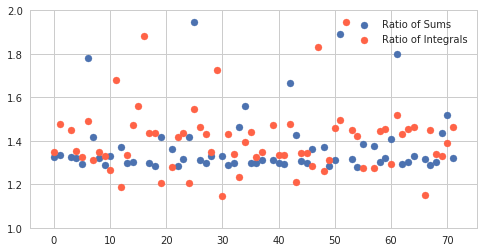

In [88]:
plt.figure(figsize = (8,4))
plt.scatter(x,raw_sum*1.5625/(corr_sum*1.5625)[:72],label = 'Ratio of Sums')
plt.scatter(x,raw_int/(corr_int)[:72],color = color[1], label = 'Ratio of Integrals')
plt.ylim(1,2)
plt.legend()

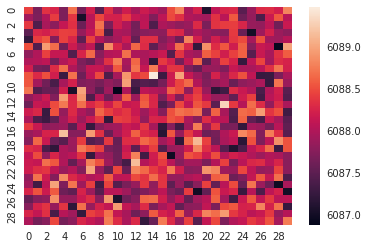

In [195]:
a = np.random.uniform(low=2.4, high=2.8, size =(30,30))
b = np.random.uniform(low=2.4, high=2.8, size =(30,30))
z= spy.correlate2d(a,b,mode ='same',boundary = 'wrap')
#print(z)
sns.heatmap(z)

In [219]:
print(pol[38], corr_sum[38], raw_sum[38])
print(pol[65], corr_sum[65], raw_sum[65])

ENT_A180_B090_W0028_H11-180702 -604.0367647058811 235.75
ENT_A320_B045_W0028_H11-180702 404.10294117646845 1676.4583333333358


In [51]:
x = [0,1,2,3,4,5,6,7]
print(x)
print(x[:5])

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4]
